In [1]:
%matplotlib inline
import sys
import os
import torch.multiprocessing as mp
from auv_control.parallel_train import parallel_train

print(sys.path)
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
import seaborn as sns
import numpy as np
import holoocean
from tqdm import tqdm

from auv_control.estimation import InEKF
from auv_control.control import LQR
from auv_control.planning.LQR_SAC import LQRSACPlanner
from auv_control.planning.Dijkstras import Dijkstra
from auv_control.planning.astar import Astar
from auv_control.planning.aco_astar import ACO_AStar
from auv_control.planning import Traj, RRT
from auv_control import State
from plotter import Plotter
from auv_control import scenario
sns.set(context="paper", style="whitegrid", font_scale=0.8)

from mpl_toolkits.mplot3d import Axes3D

class Plotter:
    def __init__(self, names):
        # Where all the data is stored
        self.t = []
        self.data = None

        self.num_row = 5
        self.num_col = 3
        self.num_items = len(names)

        # Setup figure
        self.fig, self.ax = plt.subplots(
            self.num_row, self.num_col, figsize=(6, 8), sharex=True
        )

        # Setup all lines
        self.lines = [[[] for _ in range(self.num_row)] for _ in range(len(names))]
        for i in range(self.num_row):
            for j in range(self.num_col):
                for k, n in enumerate(names):
                    (p,) = self.ax[i, j].plot([], [], label=n)
                    self.lines[k][i].append(p)

        self.ax[-1, 2].legend()

        # Add axes labels
        titles = ["Position", "Velocity", "RPY", "Bias - Omega", "Bias - Acceleration"]
        for i in range(self.num_row):
            self.ax[i, 1].set_title(titles[i])
        self.fig.tight_layout()
        plt.savefig("layout.png")
        
        plt.ion()
        # Additional setup for 3D plot
        self.fig_3d = plt.figure(figsize=(8, 6))
        self.ax_3d = self.fig_3d.add_subplot(111, projection='3d')
        self.ax_3d.set_title("AUV 3D Trajectory")
        self.ax_3d.set_xlabel("X Position (m)")
        self.ax_3d.set_ylabel("Y Position (m)")
        self.ax_3d.set_zlabel("Z Position (m)")

    def add_timestep(self, t, states):
        # Keep the time
        self.t.append(t)

        # Plop our data at the end of the other data
        new_state = np.stack([s.data_plot for s in states])

        if self.data is None:
            # Initialize self.data if it hasn't been initialized yet
            self.data = new_state[:, :, np.newaxis]
        else:
            # Concatenate new data along the third axis
            self.data = np.concatenate((self.data, new_state[:, :, np.newaxis]), axis=2)

    def _rot_to_rpy(self, mat):
        return Rotation.from_matrix(mat).as_euler("xyz")

    def update_plots(self):
        # Update all lines
        for i in range(self.num_row):
            for j in range(self.num_col):
                for k in range(self.num_items):
                    # Ensure that the data is correctly indexed to provide a sequence
                    if self.num_col * i + j < self.data.shape[1]:
                        y_data = self.data[k, self.num_col * i + j, :]
                        # Check if y_data length matches the length of t
                        if len(self.t) == y_data.shape[0] and not (np.any(np.isnan(y_data)) or np.any(np.isinf(y_data))):
                            self.lines[k][i][j].set_data(self.t, y_data)

                self.ax[i, j].relim()
                self.ax[i, j].autoscale_view()

        # Update 3D trajectory plot
        for k in range(self.num_items):
            x_data = self.data[k, 0, :]  # X positions
            y_data = self.data[k, 1, :]  # Y positions
            z_data = self.data[k, 2, :]  # Z positions (height)
            if len(self.t) == x_data.shape[0]:
                self.ax_3d.plot(x_data, y_data, z_data, label=f"{k}-{self.lines[k][0][0].get_label()}")
            
            # Plot start and end points
            if k == 0 and len(x_data) > 0:
                self.ax_3d.scatter(
                    x_data[0], y_data[0], z_data[0], c='green', marker='o', s=100, label=f"{self.lines[k][0][0].get_label()} Start" if k == 0 else None
                )
                self.ax_3d.scatter(
                    x_data[-1], y_data[-1], z_data[-1], c='red', marker='x', s=100, label=f"{self.lines[k][0][0].get_label()} End" if k == 0 else None
                )

        self.ax_3d.legend()

        # Display the updated plot in Jupyter
        plt.show()
        print("Plot updated in Jupyter Notebook.")

# Main function to run the simulation
def main(num_seconds=100, show=False, plot=True, verbose=False, route="rrt", num_workers=10, num_episodes=200,ctrain = False,max_step = 1000,model_path=""):
    if "Ocean" not in holoocean.installed_packages():
        holoocean.install("Ocean")

    # Load in HoloOcean info
    ts = 1 / scenario["ticks_per_sec"]
    num_ticks = int(num_seconds / ts)

    # Set everything up
    controller = LQR()
    observer = InEKF()
    dummy_env = holoocean.make(scenario_cfg=scenario, show_viewport=False, verbose=verbose)
    if route == "rrt":
        planner = RRT(num_seconds)
        print("this RRT way")
    elif route == "astar":
        planner = Astar(num_seconds)
        print("this Astar way")
    elif route == "djs":
        planner = Dijkstra(num_seconds)
        print("this Dijkstra way")
    elif route == "aco":
        planner = ACO_AStar(num_seconds)
        print("this ACO_AStar way")
    elif route == "sac":
        planner = LQRSACPlanner(num_seconds)
        print("Using PPO planner")
        
        
        if not os.path.exists(model_path):
            planner.train(dummy_env, num_episodes=num_episodes, max_steps = max_step, model_path = model_path)
        elif ctrain:
            planner.load_model(model_path)
            new_path = 'ctrain_'+ model_path
            planner.train(dummy_env, num_episodes=num_episodes,max_steps = max_step, model_path = new_path)
            #parallel_train(planner, num_episodes, num_workers, verbose,scenario)

    else:
        planner = Traj(route, num_seconds)
        print("this way")
    if plot:
        plotter = Plotter(["True", "Estimated", "Desired"])

    # Run simulation!
    u = np.zeros(8)
    des_action = np.zeros(8)
    env = dummy_env
    env.set_render_quality(0)
    env.reset()
    if route == "sac":
        planner.load_model(model_path)  # 加载模型
        planner.setup_obstacles()
        planner.draw_traj(env, num_seconds)
        env.act("auv0", u)
        done = False
        sensors = env.tick()
        # Pluck true state from sensors
        t = sensors["t"]
        for i in tqdm(range(num_ticks)):
            true_state = State(sensors)
            d_g, d_n_o = planner.extract_element(true_state)
            if d_g < 5:
                done = True
            true_state_for_planner = np.append(true_state.vec[0:], true_state.bias[0:])
            #true_state_for_planner = np.append(true_state_for_planner, true_state.mat[0:])
            true_state_for_planner = np.append(true_state_for_planner, d_g)
            true_state_for_planner = np.append(true_state_for_planner, d_n_o)
            true_state_for_planner = np.append(true_state_for_planner, done)
            #real_next_state = State(real_next_state)
            # Estimate State
            est_state = observer.tick(sensors, ts)

            # Path planner

            des_action = planner.select_action(true_state_for_planner,inference = True)
            env.act("auv0", des_action)
            sensors = env.tick()

            # Pluck true state from sensors
            t = sensors["t"]
            des_state = State(sensors)
            # Autopilot Commands
            u = controller.u(est_state, des_state)
            # Update visualization
            if plot:
                plotter.add_timestep(t, [true_state, est_state, des_state])
            if done:
                break                
    else:
        for i in tqdm(range(num_ticks)):
            # Tick environment
            env.act("auv0", u)
            sensors = env.tick()

            # Pluck true state from sensors
            t = sensors["t"]
            true_state = State(sensors)

            # Estimate State
            est_state = observer.tick(sensors, ts)

            # Path planner

            des_state = planner.tick(t)

            # Autopilot Commands
            u = controller.u(est_state, des_state)
            #print(u)
            # Update visualization
            if plot:
                plotter.add_timestep(t, [true_state, est_state, des_state])

    # Final plot update after all data is collected
    if plot:
        plotter.update_plots()


['/sciclone/home/dyang06/DecisionMK/AUVControl', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python39.zip', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9/lib-dynload', '', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9/site-packages', '/sciclone/home/dyang06/anaconda3/envs/Path/lib/python3.9/site-packages/setuptools/_vendor']


In [ ]:
if __name__ == "__main__":
    #mp.set_start_method('spawn')  # 为多进程设置启动方法
    main(num_seconds=400, show=False, plot=True, verbose=False, route="sac", num_workers=1, num_episodes=800,ctrain = True, max_step = 1000, model_path = 'SAC_new_dac_1000_best_model.pth')
    print("separated space \n")


/sciclone/home/dyang06/DecisionMK/AUVControl/auv_control/planning/LQR_SAC.py:349: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)
Model loaded fr

Using PPO planner


Episode 1 starting
Episode 1 completed - Total Reward: -500.12428470738115
Model saved at episode 1 to ctrain_SAC_new_dac_1000_best_model.pth
Episode 2 starting
Episode 2 completed - Total Reward: -596.2103675427621
Model saved at episode 2 to ctrain_SAC_new_dac_1000_best_model.pth
Episode 3 starting
Episode 3 completed - Total Reward: -537.8569302199705
Model saved at episode 3 to ctrain_SAC_new_dac_1000_best_model.pth
Episode 4 starting
Episode 4 completed - Total Reward: -767.3382509742098
Model saved at episode 4 to ctrain_SAC_new_dac_1000_best_model.pth
Episode 5 starting
Episode 5 completed - Total Reward: -641.551809545877
Model saved at episode 5 to ctrain_SAC_new_dac_1000_best_model.pth
Episode 6 starting
Episode 6 completed - Total Reward: -480.77173558606086
Model saved at episode 6 to ctrain_SAC_new_dac_1000_best_model.pth
Episode 7 starting
Episode 7 completed - Total Reward: -541.7536067939008
Model saved at episode 7 to ctrain_SAC_new_dac_1000_best_model.pth
Episode 8 st

tensor([[ -41.4570,  109.0759, -127.3140, -137.6927,  -37.8482,   92.6454,
          -90.6273,    0.4974]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -42.1236, -127.7592,  333.2347, -214.6389,  283.7586,  164.3006,
         -177.7956,  166.2142]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -42.5968,  -34.7451,  168.6777,  153.2179,   21.2271, -155.9179,
         -129.1735,   27.6269]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -43.0306,  -30.6113, -163.2222,  153.8009,   79.4320, -158.1134,
           64.6811,  -17.6755]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -43.6751,   45.9622, -218.0370,   87.1886, -126.6718,  -94.7710,
         -203.7559,  -49.1236]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-4.4374e+01, -1.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -39.4365,  -48.5518, -233.7210,  358.2164,  180.6972, -190.8919,
          118.4793, -159.6647]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-39.3886, -17.6378, -90.2822, 215.5313, 188.2923,  82.6266, 145.3951,
         -16.8001]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -39.5556,  -64.2447,  164.5291,  110.9791,    1.4536, -190.1498,
          177.4679,  111.1409]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -39.6707,  -48.1882,  354.7002,   90.4532,   64.6583,  -51.7697,
         -159.7716, -130.3324]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-39.7928,  85.7952,  37.4263, 139.2416,  -6.0268, -12.1853,  57.5296,
         130.6426]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: to

tensor([[ -39.5387,   -1.7712, -116.4305,   -7.7837,  -85.5313,   69.7151,
         -246.2128, -112.6637]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-41.3654, -13.3554,  -9.3270, 271.1777,  68.7210,  41.8571,  20.8610,
         -98.2073]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -42.7336,  -38.6577,  -76.5172, -109.7838, -126.0591,   43.8287,
          178.8725,  -23.1303]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-42.7770, -48.5845,  96.6583, 200.1344,  65.5940, -30.1159,  81.3737,
          17.7314]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -42.0703,  -42.3034, -200.8997,  135.2270,   58.6312,   -5.3718,
          -25.4551,  -51.2136]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -41.2257, -205.3656,  225.6962,

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -40.4633, -110.5766,   48.0272,  -86.8205,  203.3857,   -5.4695,
           -8.8728,  -63.5383]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -39.5639, -133.7595,  150.4238,   53.9095,   80.1614, -153.2360,
            3.9045, -132.9519]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -38.8662,    0.2608,  -71.9394,   34.6227,  213.4966,  -28.9970,
         -210.1679, -173.8239]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -38.3854,  -46.2265,   -5.0959, -116.1451,  128.9645,    8.1555,
          123.3840,  323.5857]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -37.8035,  -60.6372, -120.9359,  -85.0468,  157.4853,  190.5560,
           24.2988, -168.8746]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -46.7094,  -98.4309, -200.2258, -218.5416,  197.4685,   -4.6582,
           10.8566, -120.7298]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -46.5142,  118.2896,  209.5323, -107.9127,  213.6851,  -94.9086,
          114.8931,   17.4676]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -46.5601,   12.2894, -188.2233,  -26.4496,  -77.1587,  -44.7017,
          321.2698, -100.4332]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -46.5447,  -75.4940,  244.9665,   40.8692,   37.7941,   24.2319,
         -181.5890, -122.4496]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -45.0795,  -23.3619, -112.5711,   47.6252, -124.0625,   66.5542,
         -311.1308,  -54.9388]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -34.2031,   37.2272,   16.8018,  144.5336,   51.1148,  -62.5039,
          -55.5067, -160.0394]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -35.4266,   46.8441,  128.2240,  220.2949,  -69.7978, -150.3723,
         -242.9334,   31.9141]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -36.0787,  -74.8761,   77.1272,  110.5528, -245.2619,  -16.8492,
         -119.0932,   69.1405]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -49.8661,    5.7642,    8.8250,  286.2681, -202.2367,   61.8418,
         -162.3555, -142.3122]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -47.8652,  -78.5055, -169.8031,  330.6637,  -19.6159,  -22.5127,
         -160.7358, -100.0284]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

tensor([[-40.8886,  56.0230, -21.7931,  61.0101, -93.3115, 100.1824, -49.2027,
          35.5477]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -44.8232,  265.2073,  242.7525,  269.1758, -117.9771,   -1.6375,
            1.5310,   12.4874]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -52.0386, -283.0447, -299.1252,  -63.3987, -103.0621,  190.1940,
         -146.9351, -183.5772]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -46.7240,  -47.6441, -100.7333,  347.7050,  -71.6221,  -27.7593,
         -109.9971,   74.0496]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -45.0274,   72.7062,  -31.2287,  446.6843,   26.8635, -105.6759,
          -72.2422,  272.8617]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -44.5768,   -8.1002,   

debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -40.7530, -200.2767,  -18.6393, -189.0765, -232.1049,  -42.4937,
         -386.5067,  -25.2854]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -40.0787, -200.3892,  -63.6516,  126.9340, -147.5718,   21.0284,
          106.4403, -335.5524]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -39.6384, -162.5755, -171.2941,  311.8259,  -74.5076,   93.9353,
          275.8528,  275.6302]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -36.5080,  -26.3994,   17.0444,   48.2979, -115.6933,  141.8599,
          -25.6410,  -38.7578]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -33.9414, -146.1872,  -25.2842,  -63.4986, -228.8320,  -97.8248,
           37.4045,  -49.9300]], device='cuda:0')
debugginng
Normal(loc: to

debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -45.6331,  -30.9983, -204.6453,  420.1560,  240.5956,  -10.9542,
          189.9194,   32.8356]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -54.4405,   -3.1760, -154.8150,  211.4438,   96.6935,   17.2852,
         -148.7235,  276.3185]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -46.6037, -248.5055,  142.4944,   13.3763, -149.5692,  -72.2137,
           97.8927,   89.9018]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -45.9454,   48.3685,   -4.3626,  425.9252,  -64.3588, -126.6370,
          187.4008,  -28.0021]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -45.1682,  -57.6808,   18.0425,  125.4470, -190.1754,   59.8420,
          102.2710, -178.0561]], device='cuda:0')
debugginng
Normal(loc: to

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -54.5372, -119.3359,  264.1358,  144.5424,   11.1510,   37.9895,
          312.2830, -128.3495]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -62.3104, -140.1591,  -15.3936,  386.6084, -207.1515,  246.5710,
         -110.1373, -526.8138]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -57.0702,   56.1548, -145.3044,  207.7875, -177.0849,  -22.5997,
          165.0815, -148.5043]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -51.7781,  -56.6441,  141.2744,  -60.8437, -345.3662,  -18.0240,
          193.2094,   98.6432]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -49.8411,   57.1840,  126.9673,    9.6042, -122.7297, -198.1792,
          -18.9897,  -97.5308]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

tensor([[ -44.3363, -156.6520,   54.6782,  -70.2182,  252.3228,  -62.0103,
           41.1282,   31.0050]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -41.4595,    6.1406,  284.1862,  173.7657, -152.4609,   60.4566,
           69.9904, -120.2938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -36.2417,   30.0568, -128.6861,   92.1315,  -17.8428,  -25.0111,
           73.2152,  188.6218]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -33.2487,  -64.2098,   18.2920,  114.6692, -247.4986,   53.5893,
           42.1571,    5.9340]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -32.1609, -107.0408,  101.7306,   85.5822,  -32.0462,   66.2893,
         -111.0131,  105.9106]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-32.5476,  32.72

tensor([[ -36.0200,  -82.9635,   71.3408, -231.4403,  -16.5455,   20.7777,
         -201.4832,  105.6064]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-35.1086,  93.5471, -30.5319, 168.5848,  10.9966,  11.4098,  47.3584,
          92.0781]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -35.1394,  -81.2386,  -54.2995,   41.8438,  -57.2760,   70.2265,
           48.9373, -102.6561]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-3.6050e+01, -8.2407e-02,  1.2406e+01,  1.8288e+01,  1.5505e+02,
          1.5721e+02, -2.5994e+01, -1.4075e+02]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -38.3658, -140.3616,   96.2701,  200.8278,  332.7791,   94.3109,
          133.7601,   87.9607]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-41.9412

tensor([[ -50.5365,  -21.8935, -125.4548,  -27.4432,  -32.6853,   88.2717,
          285.0781,  184.9134]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -49.0187, -181.5708,  225.1064,   68.8360, -108.6200,   -8.4401,
         -265.4928,  -22.4380]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -47.3324,  -75.2461, -209.9556,  149.6857,   73.7900,   18.8857,
          241.0896, -140.7809]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-45.5770, -14.8703, -90.5270, -23.9422, -25.6367, 112.6403, 245.5791,
         -47.7638]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -43.3545,   -1.1120,  -53.5669, -405.5911,  202.9621,  -50.8090,
          -39.2422, -265.0539]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -40.3446,  -55.0483,  4

tensor([[ -54.0817,   65.7137, -160.3942, -283.2037, -311.7247,  -40.4570,
          -12.9830, -394.3888]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -50.9879, -143.3684,   57.2009,  -73.6242,  -84.1558,  -87.6554,
           43.3153, -214.5121]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -48.1329,   53.9361, -142.0187,   47.0821,   71.3324,  -86.4487,
         -161.9773,  -56.2682]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-45.9841, -36.6692, -47.4422, 144.6068,  60.3263,   2.0953, -79.2910,
          -0.2926]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -44.1106, -142.7556,   58.5133,   90.1664,   62.4640,  -45.8198,
           98.8106, -221.0535]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-42.1841,  32.2761, 250.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -50.0888,  129.3401,  -66.2504,  291.5075,  228.0760,  -39.0696,
         -113.0054, -386.7437]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -47.1530,  -28.0688,  -40.3307,  299.9546,   64.6259,  -69.5951,
            4.4464, -232.4498]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -44.5281,  -26.1239, -268.9834, -188.7893,  100.4825,   19.0223,
           93.3693,  209.0113]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -41.8565,   46.8171,   31.5941, -306.5548, -163.7470,  -88.6248,
          -72.0698, -244.0313]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-38.9846,  77.7805,  58.9302, -36.2552, 111.4166,  27.5835, 144.0495,
          -5.8840]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), s

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -28.3134, -108.1368,   53.8793,   81.0608, -128.2261,   10.9998,
          150.6395,   90.6676]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-26.2579,  64.4037, -68.6160,  36.5980,  40.0583,  14.1924, -40.2688,
          73.7408]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-24.4436,  85.4006, 170.4424,  59.2290, -39.3080, -61.9287, 110.9091,
         -86.0485]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-23.2568,  17.5000, 127.2006, -50.7556,  76.3537,  46.0437, 111.4867,
          63.8701]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -22.7008,  -99.0140, -123.2032,  154.9045,   33.5973,   43.4988,
            6.2396,  -58.0412]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -54.2399,  -27.5356, -192.6841,  -60.2273,  339.5294, -148.1266,
          -57.9455,  -33.0501]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-51.8017,  87.3751,  47.6064, -54.8957, -19.7105, -47.9684, -67.4541,
         -34.0348]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -49.5282, -152.5741,   28.6120,  -51.8644,  -67.2843,   20.7325,
          -38.2609,  131.0208]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -47.4442,   69.8798,   -4.2668,  -13.7771, -107.7243,  -70.9261,
         -107.1209, -216.7914]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -45.2729, -142.2440,  -40.7588,   -3.1273, -409.8593,   51.3800,
         -216.7186,  219.0024]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), s

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-46.9620, -25.2077, -28.4744, 136.4560,  56.5763,  25.9928,  22.3479,
         277.9321]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-44.8677,  27.2928, 201.2137, 145.5939, 198.8678, -62.7660,  33.3708,
         -34.5500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-42.7840,  25.8868, -23.1604, 223.5847, 232.9549,  35.2345, 109.9460,
          98.9912]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -40.6089,  -21.1718,  235.3667,   41.2134,  272.1921, -144.2503,
         -275.9051,  -38.0940]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -38.2965,  187.2330, -154.6396,   -0.4587,   41.5122,  106.6508,
           39.9915,   95.0620]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -38.6930, -107.8288,   64.7546,  154.9346, -117.4497,  -81.0119,
          -94.9839,  166.1064]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -45.0954, -111.1187,   18.1662,   27.6802, -136.2659,    8.8901,
          282.9167,  -28.9544]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -92.2944,   70.9347, -285.2434,  171.3824, -398.7103, -155.7536,
           99.6944, -124.7088]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -69.5463,  121.0996,  -64.3819,  290.8904, -375.4950,  129.9195,
           84.2179, -256.1697]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -66.3586,  -52.1534, -349.8798,   99.3610,  209.8318,  -57.7531,
          161.5110,  140.3786]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

tensor([[ -40.3149,  -34.3948,  -51.0429, -149.9667, -229.3913,  -31.8851,
          -77.2747,  -74.3856]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -43.4271,   31.0086, -108.8931,  170.5009,   33.0105,   41.4556,
            7.8520,   -3.5270]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -46.8806, -175.8625,   45.0569,   14.2561, -196.0042,  113.4990,
         -111.0489,  208.7670]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -50.8719, -152.8874,  389.7711, -110.4629,   20.0796,   29.0320,
         -280.3808, -320.1609]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -55.0954, -181.9288,  137.9098,  110.7194, -210.2463,   -9.7059,
         -221.5691,  160.4032]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -59.4845, -223.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -74.3787, -234.7228, -113.1848,  382.3261,  -69.7489,   54.9236,
         -214.3931, -147.2519]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -70.7678,  365.1214, -226.0869,  314.2867,   58.8757,  101.1104,
          181.6194, -333.4604]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -67.0995, -128.0392,  357.4450, -201.0657, -599.7742, -187.1565,
          182.1109,  205.2841]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -63.4050,  -34.4333, -125.4090,  410.4273,   82.0180,   70.7971,
         -231.9400, -240.0425]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -59.9450, -174.9489,  -67.1645,  116.4838,  102.0947,  180.7508,
         -341.4008,  -62.6805]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -37.0839,  -36.3932,  -96.1777,  229.1125, -137.2208,  -84.6535,
          126.5880,  -78.9217]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -40.3733,  -17.8070, -179.6212,   58.7011,   97.5655, -196.4736,
         -314.6275,  104.5163]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-44.3924, -94.3605, -73.2728, -19.6656,  -7.4586, 113.9919, 138.9610,
          74.4780]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -49.6607,  -24.6659, -114.4304,  252.1530,  381.7748,   16.9346,
           14.5255,  447.7924]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -56.8936,    7.0388, -297.5807,  339.0947,  382.4489,   33.0030,
          122.5957,  -20.7582]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), s

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-39.6005, -73.5838, -82.2945, 196.2802, 100.2713, -71.8509,  54.3082,
         -21.8837]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -40.5610, -147.2254,  -50.2384,  -98.5312,   73.4317,  -10.4415,
          -39.4340,   -8.0439]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -42.5035,    6.4308,   81.7278,  -88.2044,  -83.8059, -112.1749,
           69.7775, -218.0141]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -46.0215,   75.9475,   29.0790,   37.4432,  233.4120, -111.1915,
         -136.2194, -110.7740]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -51.0077, -120.3206, -115.7168, -108.7873,  -21.6772,  165.1418,
          208.1879,   66.1056]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), s

           79.4673,  -53.0036]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -55.7978, -111.5289, -272.0429,  293.2574,   21.5202, -111.3865,
          216.1001, -292.1210]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -73.2381,  -91.4713, -285.5500,  455.4291,  -94.3162,   36.6869,
          287.6263, -402.6070]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-101.9746,  -56.1146, -308.9686,  323.7484, -365.9407,   18.2599,
          -53.0485, -400.5211]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-119.4528, -376.8835,  231.9540, -787.4608, -618.2414,  435.8814,
         -106.8243,  818.4135]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-127.1960, -137.5886,  102.1484, -241.9381,  204.5557,   69.0974,
          391.2461, -290.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -49.8343,   -0.8284,    2.4821,  339.5546, -126.0148,  -32.7374,
           52.2260,   35.4816]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -49.9468,   96.1988,   59.0310,  258.8620,  358.2498,  -87.5434,
          302.9142, -399.9668]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -51.0023,  -97.0530, -227.6708,  -62.8699,   87.6960,  -55.1611,
          146.3506, -306.0399]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -54.8064,  -39.6073,  129.4035,  485.2331,  127.9449,  -71.8104,
          -12.6108, -134.6051]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -66.2819,  -25.0998, -346.4499,  202.6941, -171.1060, -198.0006,
           63.0315,  -67.3176]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -75.4586, -263.0301, -103.9756, -176.5760,   -9.0524,   -5.7381,
           42.1128, -418.2217]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -71.3775, -216.4745,  397.7011,  252.3085,  234.3185,  -53.7362,
         -651.4312,  -36.2907]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -67.5836, -213.5652,  235.9517,  -79.7071, -794.5804, -139.8631,
           49.4415,   56.9275]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-63.9169, -47.5055, -22.9095,  26.2825, -35.6683,  76.0457,  60.7368,
          61.3051]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -60.6856, -106.5550,  -94.9744,  276.4608,   75.6203,  159.4124,
         -147.7731, -424.7440]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), s

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -64.1579,  -71.6846, -140.1589,  112.7704, -217.2197,  172.2049,
          379.7578,   70.1711]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -61.0807, -246.1795, -326.6081,  179.4417, -154.3157,   35.9812,
           23.2231,  372.8639]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -58.6879,  -80.1455, -146.4949, -405.7061,  -30.0013,   63.5285,
           65.6918,   80.5933]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -58.5813,  -75.2976,  -99.0112, -367.1945,  354.5177,  -64.3621,
          101.3799,  193.6587]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -60.5836,  112.8633, -140.2370,  -87.5617,   39.2010,  -91.0438,
          -60.7316,  -80.8193]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -76.6359,   69.7874,  -52.3296,  -79.3293, -152.0832,  122.2585,
          354.0130, -401.0313]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -90.3788,  296.1272,  147.4501,  364.3583,  392.0459,  301.2273,
         -386.9338, -200.1886]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -97.7028, -124.3785,   83.4184,  523.7997, -395.3180,  203.2094,
          281.7287, -357.2003]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-100.5969, -103.2141,  265.9962,  186.6364,   37.1157,  153.6537,
          180.4970, -878.9837]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-102.4250,  -90.7244,  131.0449,   52.6473,  150.7467,  220.9808,
            4.2436,   22.0969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-109.6546, -187.7962, -161.6165,  514.5070,  615.8279, -511.1441,
         -365.0978, -519.5865]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-112.4696,  -30.0760,   19.9092, -230.2837, -166.5517, -272.8033,
          -91.8496, -106.0595]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-113.0405,  189.2847,  -60.7788,   50.0183, -328.0497,  234.7561,
           97.7358,   88.7047]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-113.0053, -203.5687,  200.2748,  974.9495, -198.9032,  -19.3444,
          284.2534,  318.8232]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-112.8054,  -56.8888,  360.4254,  650.1145,  -25.6100,   49.8789,
         -129.7137, -635.0266]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

tensor([[-114.2785,   59.8782,  304.5955,  173.8273, -419.1303,  282.6471,
           14.8922,   15.6892]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-113.6300, -285.4309, -137.0427,  462.5994, -618.5760,   82.5033,
           88.2489, -740.4848]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-113.2495, -130.6218, -441.1582,   27.3344,  989.5784,   74.6987,
          195.1744, -448.6861]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-113.0727, -198.5925,  -19.9256,   56.3567,  -62.4947,  121.5607,
         -269.5504,  253.9554]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-113.4965, -184.2447,  164.0813,  496.9906,  232.8990, -192.8382,
           65.0141, -437.7346]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-114.8964,  -63.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-112.1456, -221.9019,  309.0606, -284.8278,  -21.2998,  -22.2557,
         -213.7681, -114.9082]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-116.3533,  366.1862,  110.7181, -579.2774,   80.8554, -227.9825,
          782.0141,  338.0896]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-120.2588,   20.5684, -250.6453,  758.3168,  499.6464,  152.4703,
          456.1518,  -94.4787]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-125.0966,  302.4627, -714.8389,  483.0856,  -28.9924, -486.0783,
         -276.3829,  468.0359]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-130.6728,  179.0531,  146.4158,  753.4900,  750.1570, -408.6334,
         -102.2817, -496.0118]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-146.6436,   81.1259, -250.0135, -160.7576,  769.6633,  339.5085,
           67.7803,   -1.5767]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-122.8234,  297.5579, -531.5060, -319.0819,  -76.4318,  253.2869,
          -14.8720,   29.2130]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-116.1469, -356.2847,  -92.0105,  301.1363,  -86.6858,  -18.0799,
          462.6591,  308.2995]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-108.8823, -170.0933, -661.6258,  702.2863,  402.5353,  122.1158,
         -275.5560, -382.0445]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-104.2317,  103.5411, -447.5552,   63.7694,  235.6717, -110.4739,
           20.5931, -131.7084]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-121.8032,    1.2055,  513.6851,  319.2657,  751.6644,   12.6883,
          -28.3027,  119.0433]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-123.7378, -273.7015,  303.7928,  481.6383,  609.1384,   89.8534,
         -120.0579, -432.0661]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-125.7755,  216.9713, -152.1762,  449.8018,  186.9838,   79.2670,
          -12.8678,  398.6996]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-127.0752,  -56.8035,   -4.6897, -328.9416,   56.7847,  110.7414,
         -319.8067, -197.2675]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-128.3987, -397.7818,  -96.6665,  374.6827, -154.4281,  222.6255,
          464.7079, -659.1848]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-121.4181, -327.8731, -511.8275,  -76.9513, -584.2891,  559.3149,
          192.3802,  359.2304]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-116.6406, -142.2547, -415.0272,  182.9182,  -82.2307, -178.5334,
          101.0794, -204.9679]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-1.1193e+02, -1.8119e+02,  5.3158e+02,  1.1230e+02, -3.3798e+02,
          3.8589e-01, -3.3103e+02, -1.3750e+02]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-107.0668,  271.5642,  167.0047,  320.5503,   30.9871,  347.3985,
         -301.8125, -298.7162]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-103.1981,  -45.4363, -174.7354,  325.7180, -413.9836,  190.3616,
           76.3049,  173.1520]], device='cuda:0')
debugginng
Normal(lo

Episode 3 completed - Total Reward: -3747.864651709867
Model saved at episode 3ce015ec002_newarch_PPO_4000step_shortest_model.pth
Episode 4 starting


Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-108.5393, -162.5128, -376.5081, -804.6084, -361.2195,   12.0896,
         -344.3310, -857.7144]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-111.6295,  363.6888, -465.9876, -671.5407,   69.6312,  285.7561,
         -533.0344, -345.2547]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-130.5874,  -28.6972, -126.2427, -146.0632, -295.1973, -294.6617,
         -718.7552, -676.0425]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-136.5947, -201.2809, -598.2398, -568.7501, -674.9963,   27.2350,
         -284.3651, -644.2979]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-138.2455,   75.0228,  171.2129,  290.3578, -555.5641,  133.0282,
          -28.9982, -239.0152]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -86.6345, -280.1584,  117.2600,   68.5596,  120.6437,    7.8044,
          413.0839,  330.2390]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-136.0855,   92.8862, -456.0262,   -1.2380,  180.7579,  449.4551,
           35.8539,  656.6787]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-167.1623,  139.7056,  320.0016,  -54.3713, -264.3618, -855.7877,
         -660.7918, -210.0881]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-163.4590,  434.9270,  320.0926, 1155.1780, -585.3776, -203.0040,
         -556.5273,  331.5710]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-160.2141, -214.4597, -823.9854,  498.9091,  232.3572,  500.6352,
          443.0926, -218.2776]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-127.1230, -332.9943, -699.3656,  497.4149, -421.1423,  215.0348,
           92.8001,  616.4653]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-121.7745,  304.3498,  129.6541, -390.2467,   90.7417,  110.3874,
         -234.2906,  331.4103]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-113.6439, -457.3664, -216.2404,  -63.7126,  235.0331,    3.2240,
          -11.7116, -287.6719]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-103.6599,  381.4507,  646.9432,  260.9391, -193.5911, -149.8580,
           50.7820, -529.5445]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -91.6381, -393.8844, -476.1247,  610.5914, -248.5491, -270.9962,
          -74.1524, -474.1949]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -99.1952, -127.8085,  109.9118,  482.2532,  254.0816,   17.3544,
           58.0503,  356.9424]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-88.6111,   9.3400, 102.1389,  92.8887,   3.9134, 302.4224,  77.1213,
         320.3208]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -79.1750, -447.1081,  133.6105,  690.1910, -132.7981, -310.8658,
          -17.3223,   92.2447]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -72.0145, -247.5461,   66.9346,   24.3850, -299.6551,   37.8873,
          160.7092, -428.6505]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -67.4209,  -25.2233,  105.9464,  561.9302, -230.5898,  -53.4520,
           36.6222,   95.2122]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), s

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -78.2280,   13.6637,  214.4863,  460.7512,   42.3813,    6.5061,
         -178.4946,  677.8513]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -214.6111,  -444.2607,   176.2691,  -749.6783, -1187.7412,   393.2799,
         -1304.7657,   547.5236]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-204.1903,  386.9464, -797.0751,   44.8024, -668.2350, -689.5581,
         -752.4492, -614.1698]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-137.7080, -240.1480, -311.5944, -625.3687, -339.3625,  -42.0234,
          389.0864, -179.7573]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-127.8230,    7.7719, -232.3483,  676.3911, -548.7153,   25.7863,
          130.0693, -322.1938]], device='cuda:0')
debugginng
Normal(loc: torch

tensor([[ -78.3185,  245.4000,  444.8835,  276.0627,  261.7025,  -79.3915,
         -136.2605,  581.7844]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -78.4759,  173.0030, -174.0050,   52.1921,  132.8925,  -49.1335,
         -108.2500,   58.2236]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -81.9251,    0.9724,  -64.1888, -111.7367,   46.8258,  140.8097,
         -435.2931,   63.4513]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -88.1347, -101.0668,  157.9284,   -9.8868,   49.1263, -225.5481,
          268.6603,   -7.0001]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -98.8438, -376.8860, -334.3238,  375.4265,  745.9297,  316.5154,
          519.0649,  281.3995]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-111.8173,  445.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-131.3387,  -10.2502,  -55.2483,  697.7526,  855.3898,   76.7073,
          534.1288, -253.2585]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-116.2674,   84.5296, -219.0922,  573.2460,  -74.8968,  405.4095,
         -427.1273,  180.2154]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -98.8221, -192.3649,  122.8166,  472.3465, -116.1214, -254.0353,
         -962.0918,   47.2921]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -84.7507, -175.4595, -157.2621, -211.1125, -122.7854,  -49.8760,
         -354.7000,  -73.8121]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -76.1515,  430.1684,  165.1962, -123.2561, -287.5684,  387.1195,
         -171.0633, -108.2204]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-108.1844, -216.4198,  -95.0409, -135.7607, -551.2448,  106.2876,
          684.6774, -227.3424]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -95.9859, -137.8250,  166.0967,  175.4786,  -67.1406, -296.1795,
         -204.8461, -504.4169]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -88.1366,   48.7849, -167.3811, -327.9220,  -17.8313, -496.2251,
         -100.2989, -298.3099]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -83.7416, -154.1364, -317.8211, -136.4464,  188.5919,  447.9966,
         -585.4706,  205.5767]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -83.4812,    5.6331, -162.7041,  285.3300, -180.4870, -395.1993,
          -59.6095,   43.4481]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -73.4216, -296.5267,  187.7275,  101.7848,  -45.7789,    5.8780,
           55.7870,  173.7299]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -234.7232,  -678.6016, -1181.0593,   651.5634,   -85.6902,  -675.4067,
         -1053.8204,   -61.1758]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -224.5947,  1091.1357,  -201.5718,  -386.8382,  -125.0995,  -100.4011,
          -586.3350, -1058.1187]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-216.6281,  -65.1023,  685.8403,  501.2564, -450.5350,  933.7361,
          582.7488, -360.2198]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -151.3992,    39.6450,  -454.0071, -1684.7875,   233.7110,  -633.5858,
           -23.8937,   375.0004]], device='cuda:0')
debugginng
N

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -258.2867,  1306.3683, -1410.8650,   403.1963,   -10.6324,   737.5679,
          -227.1810,  -635.0391]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-247.3365,  -33.8058,  183.8227, 1254.5496,  757.7541, -137.7275,
         -108.1578,  694.2621]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -238.1113,   803.6359, -1087.8425,  1176.4231,   510.2335,  1161.5989,
          -671.9532,  -490.4954]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-231.7564,  140.5861,   70.7264, -126.4061, -823.1390,  -34.7216,
          352.8421, 2043.7565]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-166.2828, -588.8295,  658.1229,  628.7051,   26.7282, -217.5467,
         -700.6422,  699.3291]], device='cuda:0')
debugginng
Normal(lo

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -72.6942,  297.9346,  460.7641,   18.6899,  363.1386, -200.5433,
          108.1157,  -83.6070]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -72.3050,    0.4232, -131.9611, -217.1680,   65.3643,   31.7621,
          228.8645,  377.1143]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -75.6367,  214.9747, -414.6610,  523.0416, -456.7749,  -27.5322,
          -96.5241,  344.0089]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -236.2488,  -414.8219, -1719.0001,  -360.9674, -1528.4210,   110.4975,
          1498.4216,   216.4331]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-119.5873, -755.8427,  -91.5361,  700.4894,  663.7495,   33.6559,
         -178.0121,   50.4590]], device='cuda:0')
debugginng
Normal(loc: torch

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -82.0706, -232.6462, -131.1120,  306.9496,  209.0714,  135.3785,
          356.4923, -102.8672]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -87.5198,   79.3924, -428.6787, -217.8533,   82.7565, -201.5529,
         -346.1635, -146.3678]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-261.0543,   52.6848, -840.5875,  963.5513, -922.5735,   89.7840,
         -257.9389, -965.8665]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-104.7353,   59.3774,    8.5102,  -43.5694,  738.0595, -359.9230,
         -266.4423,    4.7322]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -97.9298,  -99.0199, -310.8095,  -92.4874,   -3.3993, -196.6824,
          376.7639,  327.3573]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-257.9822, -793.5586, -688.5491, -222.1967, -776.3290,   44.6982,
          548.1577, -421.3377]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-198.0345,  644.1671, 1387.0811,  439.1393, 1296.8132,  528.6853,
          632.9962, -829.3327]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-136.9201, -466.4414,  364.6788,  779.3112, 1027.1898,   28.5784,
         -160.4748,  254.1510]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-116.3436,  -78.0831,  383.1776,  -86.5760, -783.5665,  449.8101,
          972.3162,  591.0637]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-112.2896, -637.0820,  215.2143,   77.2591, -569.6667, -397.5941,
         -286.9779,  259.5667]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-262.4445,  572.6487, -140.1799, -389.0340,  -10.7308,   65.2721,
          201.5973, 1041.2754]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-123.9994,  166.9022,  323.0318, -812.0952, -327.9418,  611.1937,
          739.1682, -369.7054]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-110.3589, -108.7206, -412.5826,  786.2958,  189.4149,   -6.3305,
         -159.5871,  806.5736]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-109.9347,  -51.5460,  776.7574,  292.9829,  429.0393,  164.3568,
          548.1801, -580.9303]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-115.3476,  247.8952, -322.2815, 1168.9215,  -35.9254,   60.0654,
          707.1215, -321.6495]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

tensor([[-109.2164, -298.2720,  456.0874, -125.1795,  389.8991, -110.0690,
          286.3394,  -45.0117]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -95.8874,   36.6688, -672.9285,  169.8940,  439.9607,  -62.6532,
          197.6013,   26.4294]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -90.5960,  394.4708,  192.8533, -106.3555,   45.1817, -326.5703,
          398.5112, -276.3733]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -289.8443,  1742.7290,  -529.1848,  -795.6299,   490.3426,   215.4913,
         -1348.8054,  2525.8755]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -276.4214,  -197.0419,  1513.7633,   755.8932,  2096.0762, -1005.1113,
          1911.3519, -1486.7385]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-122.6004,  237.9273,  113.0490,  137.9260,  -44.9465,  164.1264,
          122.8145,  568.9171]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-135.0949, -252.1188,  431.8694,  512.6329,   44.3149, -116.0719,
          366.6946,  329.3223]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-152.2471, -322.6886,  100.3863,  172.1233,  985.2374,   72.0613,
           68.6941,  464.4998]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-186.0976, -330.0309, 1844.2319, 1478.6512,  -15.7220, -152.8334,
          429.1948,  427.0493]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-140.3536, -204.9432,  660.1448,  990.0352, -300.3359,  -10.1012,
         -151.7145, -569.5841]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -268.9303,  -988.2025, -2138.9727,  1548.0219,   528.5856,  -400.4688,
         -1122.4210,   337.8879]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-256.4505, -294.9352, -432.4238, -426.3630, -631.1218, -294.5532,
          -37.6944,   47.7408]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -249.0376,  -118.3070,  -725.9244,   905.7346, -1015.4444,   308.7791,
          -280.3818, -1126.3143]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -210.7115,  -628.6847,   512.5452,  1334.9641, -1513.8918,   588.3990,
            12.5275,  1055.2148]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-186.0583, -526.9321,   82.6927,  305.8531,  -50.0128,  748.2478,
          361.7789, -240.1429]], device='cuda:0')
debugginng
N

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -288.3443,  -259.3297, -1050.0497,    45.9869,   878.6340, -1427.6951,
          1940.1980,  1462.1835]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-273.1933,  727.4550, -608.9084, -841.0791, -753.8886, -504.9644,
         1736.9413, -614.6110]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-260.6806, -298.3774, -573.2972, 2069.1599, -442.1420, -875.0688,
         1114.0554, 1676.3337]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -253.1460,  -179.8312, -1266.6277,  1174.1906,  1514.5175,  -402.6605,
           923.0485,  -326.9146]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -220.0672, -1299.8424,   135.9536,  -189.0181,  -181.1330,  1245.9775,
           569.8518,   726.0850]], device='cuda:0')
debugginng
N

debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -199.2605,  -310.6487, -1168.6254,  1169.6566,   317.7200,  -247.4503,
          -794.3932,  -900.4788]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-181.5553,  240.8263,   75.6616,  817.8408, -760.4438, -721.8025,
          752.3716,  -31.6123]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-172.8530, -661.6278,  115.8927,  198.1492,  873.1769,    2.6088,
          645.0249,   24.5812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-170.1669,  279.4897, -195.3726, -371.5934,  558.8856, -179.9411,
          -88.4380,  540.6434]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -170.7465,   383.4002,  -253.9613,  -338.6926, -1043.6776,   414.1985,
          -436.8136,    76.4427]], device='cuda:0')
debugginn

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-281.8839, -650.4697,  496.1897, -134.2520,  183.6622, -676.2108,
           34.5128, 1829.0706]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -270.5247, -1647.3071,    22.4985,  1368.5581,   556.3171,  -868.2335,
           417.0117,  -342.0365]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -264.4160,   799.7542,  1963.6703, -1337.8545,  1384.7614,   765.0429,
           109.6778,  2944.8223]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -224.5056,   372.5333, -1628.3500,  1840.4888,  -921.7051,  -202.6876,
           928.7993,  -235.6320]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-199.9424, -462.4704, -505.3034,  -12.0486,   46.8145,  675.1331,
         -424.2029, -137.6042]], device='cuda:0')
debugginng
N

tensor([[ -134.9482,   240.1059,   636.8312,  -760.4796,  -924.2224,     9.0174,
         -1126.9027,  -877.5562]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -346.9776,  1056.9781,   160.1953,  1324.3137, -1370.7794, -2248.2971,
          2493.4387,   610.5468]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -318.0801,  -363.1949,   351.5049,  -133.5642,  -499.3698,   888.2290,
         -1058.8027,   526.0950]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -294.1691, -1218.6838,   220.2495, -1718.9736,  1222.4414,   616.7695,
          -341.7855,  -331.7652]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -276.0334, -1840.5409, -2031.3131,   -99.9102,  1359.4884,   286.8087,
          -437.4537, -1372.3518]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-266.6532, 1460.7806,  158.6077, 1300.1392,  759.8745,  580.5172,
          379.2603,  -16.4457]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -221.3141,    55.8495,  -353.3284, -1089.6630,   385.8853, -1135.0111,
          -793.6632,   -10.7773]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -205.9439,  -151.0136,   485.8105, -2186.7754,  1441.5225,   462.2069,
           189.9196,  1783.8684]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-202.0211, -120.5088, 1076.3352, 1012.7361,  -67.6738, -138.4280,
         1036.9875,  496.2782]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-205.3535,  935.9235, -649.2471,  235.2514,  111.2262,  147.6072,
          392.3625, -624.1765]], device='cuda:0')
debugginng
Normal(lo

tensor([[-204.8730,  237.1099, -853.4956,  111.0497, -374.8883, -719.8854,
          619.3346,  549.4874]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -212.2344,   421.7052,  -949.6830,   -64.7828,  1982.8461,  -827.7219,
           551.6199, -2283.9524]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -217.9700,   -70.0334,   412.8151,  -661.4066, -2400.9961, -1107.3383,
           471.8969,   742.2007]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -232.8412,  -661.0266,  -600.4443,  1102.8901, -1287.8517,   904.6797,
           230.4963,   114.0359]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-264.5913,    6.7079, -716.6143, 1570.6721,  -71.4592,  -81.3790,
          875.9044,  548.8559]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
t

           571.9711, -1212.6608]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -236.6624,  -841.2133,   683.4055,   639.7753, -1198.8928,  1552.6743,
          1261.1677, -1254.6123]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -198.4456,  -346.9089, -1351.7041,  2705.3757,   122.9867,   382.5981,
          1869.0696,  -744.7646]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -188.7180,   -38.2123, -1508.1993, -1516.1293,   464.8680,   999.2054,
           244.5836,  -278.1639]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-1.8759e+02, -5.9018e+02, -8.6507e-01,  1.4914e+03,  1.5189e+03,
         -6.1461e+02, -4.0142e+02, -6.0677e+02]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-191.9841, 1228.3474,  814.4324, -539.1409,  324.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-132.6327,  185.7230,  536.4368, -190.5437, -516.5051, -495.4964,
           89.5983, -148.6010]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -337.9228,   144.2700, -1393.5562, -1734.6423, -2514.5784,   764.5305,
           270.4349,  -571.7211]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-318.6087,  351.5723, 1188.3397,  -79.8774, -542.7490,  -80.1345,
         -118.4551, 1905.3577]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-301.0513,   60.8596,  165.3412, 1618.1724, -674.3766, -195.6462,
         -537.3942, 1344.7350]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -288.1384,  1536.7803,  -945.5143,  1623.5787,   831.1993, -1128.2141,
         -1036.5892,  -773.2839]], device='cuda:0')
debugginng
Normal(lo

tensor([[ -287.7691,   -41.9817,  1156.1091,  -601.8382,  -344.0775,   -11.4809,
           806.4331, -1611.1204]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -287.2463,    -8.7197,   789.5717,  3304.2070,  -327.9935,   823.2531,
         -1124.9685, -1227.5596]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -238.1659,   194.5795,   999.9441,  1758.3414,   446.1276, -1194.3309,
          1321.9084,  -280.6008]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -217.9502,  -764.8710,   427.7175,   639.5576, -2170.8481,  -693.3276,
           532.9882,  -419.8679]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -209.3851,  -160.5080, -1032.2128,   837.1735,  1164.1371,   303.5247,
          -549.7108, -1297.7609]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch

tensor([[-265.9677,   29.2822, -776.6547, -239.9046,   15.7363,    5.4882,
          581.0043, -952.2006]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -197.7908,  -118.2428,   862.7949,   356.2300,   432.0303,  -976.0125,
          1110.8910, -1041.0079]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-163.3605,   50.2203, 1205.4713, -202.0577, -774.8105, -999.9114,
          836.3964,  210.7285]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-144.4594,  555.5104,  699.6997,   81.4631, -798.1428, -232.9256,
            5.4565,  414.0817]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -363.4154,  -924.1503, -1741.2690,   572.6755,  -749.3428,  1101.9698,
          1040.6259,   552.0112]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -234.1310, -1492.6832,  -551.0219,  1327.2755,   208.6094, -2272.8579,
          -563.9382, -2738.6055]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -228.9136,   -43.9451, -1054.3478,  1054.8534,  -198.2804,  -461.6770,
           162.8198,  -160.0770]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -230.7613,  1021.6201,   963.5766,   582.9515, -1729.0182, -1818.7224,
          2191.3975,  -160.1760]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -236.4535,  1644.8998,   644.3740,  -615.8146,   971.3288,  -690.2736,
          -939.6700, -1581.5051]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -247.0517,  -878.8698, -1195.6527,  2674.4314,  1658.1156,  1066.7419,
          -481.2691,   549.5327]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -186.2608, -1380.3678,   170.4717,   533.5283,  -526.1015,   456.9292,
          1027.0883,  1583.2742]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -164.8694,  -486.9489,   520.7241,  -194.2792, -1023.2163,  -491.9742,
           -20.4673,   313.2864]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -151.0641,  1062.4242,  1012.6509,   288.1248,  1850.6138,   514.3451,
         -1046.4541,   836.6355]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-355.3109,  721.1786, -273.1844, 1324.0710, -831.5505, 3257.4490,
          400.8869, -240.6964]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -331.4095, -2057.6785, -2049.3391,  2014.6385,  1156.9604,   -25.9897,
          2421.1689,  2164.1130]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-145.5851,  805.7910, -186.7846,  746.1931,  834.0255, -130.9158,
          450.1627, -223.7209]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-140.0911,  770.9626,  414.3138,  753.8886,  560.1595, -942.0579,
         -713.8062, -243.0027]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -323.3108,  1191.5896,  -101.9865,  3534.0193,  3690.5383,  1693.4210,
          3378.3843, -2038.1709]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -304.0531,   -37.0164,   819.2686,  1546.0713,  1372.3480,   749.8530,
         -2457.3235,  -690.5214]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -288.3406,   -19.1446,  -680.5441,    50.1680,  -598.5933,   764.6557,
          1762.7272, -1156.0928]], device='cuda:0')
debugginng
N

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-159.2474,  377.6625,  988.2324,  605.4039,    1.6192, -159.9525,
          815.5040, -470.1631]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -321.7424, -1094.6753,  1591.2782,   853.8772,   754.0380,   775.4790,
          -633.4147,  -394.5795]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-302.0216,   99.2578, -141.6070, 1568.7415, -387.1443,  533.5930,
         4796.0947, 1879.0873]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -288.3445, -1262.7314,  1213.3962,  -759.7251,   261.4339,   134.3968,
           943.1689, -2540.2197]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-276.0308, 1618.9734,   35.5860,  797.0692,  750.9941,    2.3186,
         2046.1582,   18.2445]], device='cuda:0')
debugginng
Normal(lo

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -168.9804,  -586.4578,   380.0796,  2024.6616,   285.0251, -1750.6501,
          1176.8640,  -911.7426]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-162.4218,  212.4640,   67.5513, -165.1717,  915.8246,  272.2136,
          659.0855, -733.3300]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-154.1758,  305.0335, -289.2550,  523.2136, -945.6602,  131.9286,
          251.5248, 1131.9303]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-146.9605,  369.3026, 1366.2836, 1589.9885,  689.2000,  -18.2978,
         -300.2200, 1068.9580]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-293.7297, 2169.8062,  553.2600, 2634.2415, -308.7365, 1081.9058,
         1137.3947, 5174.4775]], device='cuda:0')
debugginng
Normal(loc: torch

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -282.6082,  -702.0630, -1338.2793,  -280.6320,   572.7271,  1855.7529,
         -1559.7150,  1605.8986]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -212.5020,   221.1821,  -659.4619, -1897.7827,  1301.7845,  -783.5272,
         -1616.9508,  -239.7355]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -192.8448,  -425.5389,  1705.7998, -1570.4346, -1107.4697, -3007.0254,
          -705.0472,   511.7337]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-165.2040, -403.6754,  567.6825,  -56.2225, -125.7870, -717.0687,
          142.5549,  369.1325]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -146.2854,   190.6449,   817.6810,  2144.3608,  -266.4478, -1196.1295,
          1055.5640,  -606.5532]], device='cuda:0')
debu

tensor([[-126.1842, 1232.3042,  657.0186, 2363.6333, -840.6684,  544.0038,
         -707.8362, 1199.4015]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-132.8688,  118.8397, -381.4861,  -44.5588,  666.3118,  -80.1844,
          434.3201, 1114.8661]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -143.4419,   630.1938, -1313.2239,  -139.5709,  -220.5419,  -458.8669,
          -159.6869,  -380.6786]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -165.0533,  -833.2271,  1273.1696,  -689.2087, -1509.5754, -1013.9746,
           566.6170,  -546.5246]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -196.1038,  -802.9199,  1349.7345,  -903.1109,  -120.2935,  1445.1025,
          -407.3748, -1242.7742]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
t

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -249.7174,   968.1401,  3888.1831,  2054.1389,  -628.9985, -1219.6302,
          1665.9769,   908.3034]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -268.7214,  -733.4586,   713.9494,   946.4434, -3767.5430,  -891.5234,
          3009.2617,  1479.9766]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -290.2700,  -719.4471,   400.8627,  -210.6359, -1935.8582, -1144.6555,
          2320.6819, -1642.5753]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -218.7018,   614.9789, -1681.2225,  1185.2942,   917.5672, -1931.9031,
           838.5918,   466.0905]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -191.5705,  1003.9090, -3433.2559, -1989.5896,   322.8026,  -728.8754,
         -1353.6993, -1932.7037]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -243.9799,  -885.9452, -1261.2817,  1013.0498, -1525.6431,   986.1534,
          -280.9981, -3840.7314]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -264.1181,   473.5103,  -457.2482,  2888.0266,  1299.0063, -1457.1260,
           -26.6099,  2279.3757]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -280.8686,   913.2720,   525.1793,    77.6669,  2116.6445,   107.8300,
         -1776.6772, -4723.2090]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -299.5718,  -174.4484,  2787.8616,  4206.3628,  -751.1796, -1254.9935,
         -3186.6499, -2659.9722]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -325.7079,   290.6906, -1140.5706,  1715.2830,  -643.6122,  -656.3381,
         -1746.8054, -1208.2026]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-180.3539,  -72.9043, 1602.9966, 3007.2507,  200.5669, -159.0438,
          884.9108, -335.0969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-172.2775,  313.8872,  159.5191, -334.2352,  754.8300,  770.6008,
          393.9097, 1171.2693]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -169.2371,  -675.4349,  -723.1516,  1361.3103,  -121.9949, -1176.7188,
           454.2224,  -894.1262]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -170.4888,  -889.8002,   304.2811,  -256.8560,   460.0435,    -6.8211,
          -834.9111, -1277.2589]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -175.7174,  -272.3034, -1712.0820,  -623.7280,  1016.5898, -2652.8447,
           303.6834,   801.9374]], device='cuda:0')
debugginng
N

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -164.0590,  -477.9039, -2194.2571,  1157.1543,  1387.5765, -1061.8589,
          1323.4926, -3012.4487]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-158.6225,  541.1787,   40.6003, 2158.3530,  984.5615, -851.2844,
         2121.5059, -946.5580]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -157.2780,   970.4050,  1424.0529,  -902.9553,  2000.7249, -1785.7672,
           -63.4984,  -218.6305]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -158.3239,  -689.4556,   309.1181,  1010.5311,   107.6274,  1835.6306,
           603.3984, -1941.1824]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -165.7059, -1356.4818, -1147.8004,  1046.7473,   448.4673,  1007.8704,
         -1168.1162,   386.6604]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -308.0321,  1663.7589,   324.9182,  -382.4897,  -880.3690,   996.9327,
         -2216.3533, -3172.3191]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -325.2637,  1012.0946,   791.0557,  4504.7217,  1625.2729,  1205.5529,
          4027.2024, -2486.2295]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -341.1793,  1425.9731, -2234.4934,  -523.3229, -2162.9119,  1521.9381,
          1124.0787,  2179.9890]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -256.0314, -1860.3870,  3048.8530,   975.9919,  -567.2395, -1044.3354,
           -41.0131, -1638.5767]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -250.8755, -2056.0403, -1276.1902,  4247.5059,    72.9286,   789.0031,
          -844.6982,   159.2500]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -316.4191,  -830.7542, -1937.9243,   535.9857,  3321.8357,  1190.3059,
          -424.6309,  -182.6946]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -339.4649,   455.6667,  1558.0074,  -672.5978,  -682.3368, -1145.7599,
           495.3101,  2039.8712]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -362.9876,  2181.8311,  -188.8594,   189.5588, -1332.1157,   240.0966,
          1145.1853,   364.8589]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -273.3943,  -424.9327, -2249.7827,  4856.8540,  1073.1230,  -195.9223,
          1918.5498,  -951.5815]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -248.8124,  1745.8943,  -719.8218,  -194.7687, -1400.4258,  -921.1317,
          1672.8689,  -803.2808]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -224.6917, -2104.4844,  -975.0182,  1967.8535,   552.5642, -1251.2632,
         -1181.9435, -1081.6719]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-220.6347,  533.0316, -963.4841, 1764.5248,  401.8949, 1274.9709,
          663.3873, -582.0609]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -219.6174, -2369.6030,  -968.0077, -3181.9546,    94.3589,  -963.9823,
          -412.7719,  -351.8851]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -221.4903, -1397.0702, -3170.4624,  4563.2944,     7.8096, -1371.3732,
         -1803.2310,   865.0481]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -229.6044, -2382.3254,   711.1555,  1729.4587,   377.7841,  1480.8972,
           798.8021,  1132.6874]], device='cuda:0')
debu

tensor([[-2.8245e+02, -8.9053e+02, -3.6760e+02,  5.7072e+02,  2.8109e+03,
         -2.1584e+00,  3.0320e+03, -4.7652e+02]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -280.1218,  1257.0123,   568.8365,  3943.7488,  -825.2999, -1502.0327,
          -867.5149,   202.2089]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -255.9814,    87.2077,   137.7273, -1795.8999,  1140.8984,  1530.9912,
          1042.7073, -1511.3094]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -227.0204,   794.5637, -1542.3359,  2018.6333,  1856.2285, -4008.7346,
          2829.7964,   929.2362]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -233.8759, -2198.4658, -2460.3630, -2174.0698, -1308.1882,  -493.6477,
         -3260.8416,  1985.1328]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scal

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -224.7479,  -747.0303, -3916.8831,  -698.4044,  2304.5757,   292.8505,
          2477.1416,  1266.4409]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -217.5091, -3528.3833,  1672.7892,   634.0942,  2861.4167,    84.1862,
          -191.4386, -2370.5371]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -206.0514,   173.1107, -1588.0326,  -766.5396,  2312.7588,  1437.8378,
           390.4174,  2380.9045]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -190.1739,   688.4299,   491.8635,   467.6208,  2268.2673, -1453.2751,
         -2046.8140,  1294.0178]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -188.9211,  -651.6370,    71.1540,  1224.8621,  -410.7696,   467.7568,
          2422.6387, -2908.4805]], device='cuda:

tensor([[-238.1661, 1239.0032,  315.2381,  898.9054,  845.7820, -571.2994,
          720.2280, -976.6901]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -234.0975,  -237.3925, -1044.6223, -2408.9351,  4707.1450,  2137.6106,
          -706.2463,  1677.3219]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -220.5763, -2597.1960,  2975.2087,  1742.4663,  6426.3066,   -59.3574,
          -529.5504, -4221.5771]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -200.8156,  -560.9967, -3931.3794,   334.6989,   863.2044,   163.0642,
          2139.0757,  3018.0061]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-207.5650, -945.8104, -371.4707, -650.5222, -522.1581,  -92.4476,
         -546.2088,  299.9866]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
t

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -241.8455, -1496.6191, -2296.9138,  4370.9395, -1355.5341,  -313.3115,
          3176.4934,  1046.8473]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -251.8072, -3798.7581,   100.8177,  2183.9167, -2039.9281,  -983.6655,
         -2432.2676, -3072.4844]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -255.8944,  -994.6479, -1318.1160,   928.0958,  3969.6697, -1098.7764,
           890.0884,  -213.5541]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -255.3989,  3321.7085, -2708.4905,  1475.2920,   615.8675,   478.7516,
          -301.0920, -1819.0009]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -257.9102,     6.7471,  -904.7939,   340.3450, -4100.8237,   226.2038,
         -1381.6484, -3631.7927]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -217.1450,  1908.9023,  3436.6877,  5049.5371,  3962.4675,  2517.4387,
           999.5835, -3743.5581]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -216.1975, -1211.7167,  -214.7952,  -915.7053,  2306.0200, -1537.4684,
         -3282.3770,  1236.1975]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -215.0398,   594.5326,  2780.8315, -2899.0427,  1318.7389, -1029.2175,
          1607.3579, -3203.0300]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -214.5057,  1986.3782,   752.8911,  2432.7490, -2268.0710,  1028.2020,
          1864.6156, -1440.3680]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -212.7251, -1648.4888,  1139.1605, -1284.3430,  -246.9630, -1175.6885,
            82.1483,  3012.0315]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -191.7764, -2348.7380, -2411.2290,    67.1312,  -785.8950,   157.6707,
          2546.4622, -1507.7711]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -192.1032,  2200.0815, -1159.6324,  1743.4014, -1392.6387,  -298.8137,
         -3138.4241, -1759.4551]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-191.5497, 1218.2439, 3016.4321, 2676.3909, 2767.1360, -458.7454,
         1267.6479,  713.1907]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -190.4628,  -787.4912, -2202.2146,  1119.3290, -1818.2969, -1139.2892,
          1874.4553,  1227.2501]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -187.6690,     4.8111,  -768.7740,   858.4911,    63.9740,   811.3815,
         -2122.6641,  -740.3895]], device='cuda:0')
debu

         -1339.6991,  1604.2388]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-202.9789, 2956.4155, 3072.2913, 4632.4966, 2642.1409, -187.8007,
         -100.6499,  548.8761]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -210.3972, -1815.1256,  -405.9357,  3503.1211,  2510.1797, -1605.4600,
         -1823.7024,   -88.4343]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -262.1067,  -107.1940, -6960.8896,  8728.0957,   226.8193,  3480.1470,
         -1797.9558, -2397.2349]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -250.6239, -3152.2773,   447.3991,  -314.0415,  -265.7971,   222.1845,
          1690.6299,  4434.5493]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -237.8336, -3255.7576, -1640.6459,  -476.4265,  -362.5164,  3223

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -197.4892,  1042.0713,  2706.7666, -2174.3113,   -62.5698,   565.2962,
          3159.4497,   271.6512]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-198.5122, -732.7848, -785.4580, 5140.3442, 2532.3225, 1335.4237,
          108.9468,   23.2205]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-2.0162e+02, -1.9312e+00,  2.2483e+03,  3.6427e+03, -7.2820e+01,
          1.5985e+02, -2.9864e+03, -3.2450e+03]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -206.7748, -1718.8002, -1009.8680,  3489.8291, -3741.6614,    54.1826,
           263.4126,   -51.4241]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -241.2945,  2125.4971,  -491.5820, -4082.7483, -3777.5256,  4983.7910,
         -1970.8374, -2275.5635]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -228.6012,  1389.2231, -4949.8340,  2459.9634,  1038.2124,  1653.6129,
           599.0490,  2244.3152]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -278.0793,  3849.8965, -3760.3164,  1914.7815,  4576.1035, -3422.1555,
          -346.4158, -1973.1541]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -304.6022,  -2816.3167,  -1478.4237, -10756.0098,   4244.5254,
            662.3358,  -7370.6914,  -1122.4613]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -324.9288, -1915.5199, -1042.9075, -5885.1768,  1990.8000,  1944.1470,
         -1230.7476, -5083.8091]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -256.2978,   250.0008,  -710.3649,  1464.9369, -1219.8529,  1494.1927,
          -541.5519,   239.1849]], devic

tensor([[ -217.1395,  -789.9701,  -680.2271,  1133.0607,   982.9140,   475.4703,
         -3027.9431, -1920.6306]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -222.4444,   182.7055,   633.9723,  5662.1748, -1508.2163,   588.6155,
           540.0282,   537.2398]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-238.9476, -103.3005, 3174.5320, 2582.9910, -392.3909,  821.7187,
         -881.7482, 2802.9392]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -271.1420,  -602.8557,   904.0181,  4057.2776,  1224.9243, -1681.1113,
         -1549.8298,  1086.3846]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -296.4092, -3558.1560,  3403.1167,  2382.3408,  3993.1772, -2396.8101,
           383.6729, -1972.4351]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -189.3837,  -342.3881,  1010.7624,  -686.7000,  1325.2174,   708.6888,
         -4932.4419,  2628.1035]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -190.5277, -1135.1887, -1774.6470,   510.4842,  1442.0857,  -661.6174,
         -3574.9460,   781.1992]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -192.6583, -2023.2146, -2533.8979,  1168.1577,  2339.3433, -2493.2876,
          1259.8204,   164.1071]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -195.6987,  1729.6639,  1076.6582,  2135.2324,  2739.5583,  -412.3665,
          -995.6062, -1571.4688]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -201.1908, -2516.9985,  -371.9077,  -847.3475, -4734.1309, -3890.9075,
          -268.2008,  -406.6839]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -293.2185,  1335.9189,  2551.6917,  2065.5466,  -396.3277, -2787.4543,
          -508.2498,  3589.0117]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -241.5229,   180.7956,  1092.5347,  3142.9819,  7331.7334, -1619.8712,
         -2717.6575, -1726.9829]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -235.0505, -1861.0470,  -367.0126,  4508.0884,    76.7205, -4376.9302,
          2063.7944, -1014.0070]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -230.0560, -5691.1050,  3673.8340,  2670.3284,  -696.6843,  2991.7354,
          -578.4665, -4973.2812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -225.1658,  2937.7476, -4754.0439,  -896.1320,  1491.1759,  -541.7097,
         -1378.0731,   240.8634]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -179.7550, -2477.8804,  2071.4043,  -156.4518,  3079.8953, -2029.0771,
          1356.0167,   878.8630]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-186.0785,  530.5406, 1698.3680, 4312.3584, 2123.8691,  434.3974,
         1791.5637, -456.0768]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -224.7151,  -430.3722, -2045.3982,  3462.4380,   415.9891,  2802.9910,
          6170.8887,  5053.3198]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -253.7980,  -2945.6772,  -2852.8110,   7676.9727,   4263.0840,
          -4820.1118,   3661.8792, -10927.0127]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -200.1099, -1664.0264, -1058.8643,  5372.2710,    35.8803,   476.8891,
          1141.8386,  -892.3392]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -201.4127,   404.8013,  2323.4880,  5475.3335, -1575.6361,    69.7593,
          4117.4819,  1369.9318]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -178.1471,  -776.9301,  3010.6289,  1934.2717,  3123.5256, -1470.5837,
         -2247.9390,  3116.7659]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -150.7834, -1688.3645,  1714.4758, -2157.6875,  1881.9346,    51.6929,
          3877.8464,  -834.3353]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -158.0331, -1558.6775,   -99.9540,   216.9816,   -68.9931,  1866.9648,
          1739.4944,   560.6796]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -159.8389, -1883.9812,   345.1374,    60.0431,  1981.0912,  1562.4579,
           -95.3206, -1263.5737]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -147.6666,   523.5857, -3048.9092, -2377.0400,  1370.0454,  -484.2885,
          -217.1418,   136.2214]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -147.0600, -3117.2261, -1124.7522, -2605.1907,  3129.1807, -2185.4739,
          2489.4111, -1424.0907]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -144.7284,  -971.5044,   696.0709,  1983.7959, -1213.9265, -2008.7656,
         -1278.0630,   599.2369]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -143.4014,  2846.8533, -1312.5068,   -27.8676,  1169.3589,  -303.2209,
            53.6263, -5090.5015]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -143.0590, -2509.7676, -2882.6304,  -728.8471,    -7.1009,  -925.9952,
          -136.9098,  -776.1635]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -138.4471,  -833.5074, -1674.7783, -3092.3003,   603.9860,  1762.9420,
           953.6391,  -912.5544]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -136.9485,  1491.6426, -2257.4316,   -62.0944,  4543.0669, -1495.7493,
          4300.4487,  1903.0278]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -130.0699,  -650.4866,  -193.3411,  4636.5171,  -856.3257, -1360.1652,
          1685.6342, -1877.5035]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -131.1432, -3893.1650,  -683.7796,   916.6130, -2276.7468,  -100.6584,
           126.6854, -1108.8663]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -140.4299,   221.8101,  1962.2579,  2429.2285,   453.5319, -2477.0220,
         -4936.1304, -4150.7710]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -146.9164, -5363.2031, -2331.1992,  4137.3496, -1448.3556,  -441.0605,
          3279.8762, -8053.7437]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -146.4864, -4019.2778, -2126.7102,  -574.0969,  -476.9959,  -337.3174,
         -1925.0798,  4335.7075]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -145.7157, -2298.5288, -1498.5295,  -670.6042,  2980.4878,  1798.9369,
           461.3135,  -653.7213]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -150.1890,  3206.6948,  5432.6138, -3897.0479, -3214.0903,  -617.2396,
          6734.8564,  4981.5337]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -179.3179,  2399.3159,  9031.5420, -2227.0718, -5259.4443,  3433.3564,
         -2821.3230,  -773.6677]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -116.6545,  -898.5171,  5250.3340,  3593.2642,  -925.9681, -1254.1283,
         -2134.8123,  1862.1541]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -138.6159, -2387.7529,  5708.5352,  -974.5876,  4964.7578,  -724.7217,
          3970.6453,   917.9999]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -151.8456,    183.4059,  -3657.8582, -10171.1416,  -2073.2019,
          -3227.1885,  -3717.8621,   4019.1987]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -154.1617, -1891.8715,  -967.8753,   410.7905,  5223.7588, -4864.0566,
         -1449.5012, -7589.0786]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -154.1652, -3547.6306,  2420.7498, 11022.0195,  5995.0928,  -814.4647,
          9368.2295, -5005.1396]], devic

tensor([[  -98.0682,   308.3890,  1519.6185, -1345.4756,  1953.4099,   440.7051,
          1263.9175, -2932.9316]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -100.7722,   180.4400,  2686.9795,  1380.2867,  1506.4524,  2893.4707,
          -909.6284, -4788.3057]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -103.2399,  1496.0236,  2624.1394,  2169.8552,  1858.6786, -2267.2905,
          4497.6035, -5059.7720]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -107.1488,  2351.1406,  1481.7594,  2068.5774,  4594.5098, -1856.6395,
          1344.1082, -1332.3916]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -110.5957,    20.3142, -2893.5581,  1066.2920, -2996.7815, -1067.1550,
          5088.9873,   577.2328]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch

Episode 4 completed - Total Reward: -3876.5649248156815
Model saved at episode 4ce015ec002_newarch_PPO_4000step_shortest_model.pth
Episode 5 starting


tensor([[ -153.3453,  3995.7729,  -993.5938,  4561.3296, -6413.0151,  2794.5137,
          1801.0272, -3106.5686]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -145.6426,  1695.5839, -1009.0054,   139.5486,  3401.2812,  -668.8792,
          4219.8115,   963.9432]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -137.9263,   588.0319,  1476.8279, -3715.6240,   786.3325,  1521.5618,
         -4102.2007,  6771.5610]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -129.1744,  2205.2991,  -149.7112, -1566.0696,  -360.3499,   278.0113,
          3635.5986,  1432.4563]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -118.1578,   396.5069,    61.2561,  -981.9407,  1966.6895,   193.0886,
         -2335.4880, -4478.1230]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -53.2655, -1530.9324, -2628.9958,   524.9555,   247.4531, -1413.3701,
          4086.6267,  2138.5212]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -54.5777,   297.4246,    40.0172,  2789.8765,   559.1464,   198.4648,
         -1769.6074,   332.1686]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -55.7761, -1421.0258,  1457.5419,   208.7787,  2461.9041,  1770.2206,
          -167.6273,  -807.6024]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -57.8295,  1832.1438,  1476.4264, -1584.4033,  1397.2571,  1314.6473,
          1993.1813, -1574.7892]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -59.5029, -3767.9504, -3692.7590,  5321.1621, -2163.2839,   825.4507,
          -656.8978, -2837.5544]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -73.8882,   -27.8344,  -676.8132,  -673.9857, -3239.1636,   236.9352,
          -289.0170, -1200.7212]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -85.3268,  2616.4568,   348.0394,   -98.6520,  -178.6784,  4785.8691,
          -116.1219, -3514.8496]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -101.5670, -2226.6611, -1566.2172,  1892.4937, -1546.9910,  2162.3530,
          -328.5637, -3831.6885]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[-126.0899, 2547.1487, 1821.3069, 1580.7190, -958.1273, 2743.4280,
         2286.2107, 1356.0886]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -147.1283, -1468.1992,  1676.6875, -3240.5254,   425.9784,  -135.5695,
          5950.0562,  3259.6396]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -54.7864, -5884.5200,  -611.1574,  2318.1182,   863.3926,  2593.1252,
          7449.1602,  3239.3003]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -65.6624, -1100.2329,  3489.0769, -2021.4451,   778.0114,  4590.2485,
           854.6474,  -999.8171]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -84.6102, -2184.4504, -5426.8145, -7464.7710,  4943.1279,  2749.2090,
         -3083.3337,   427.5892]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -62.6768, -4639.0210, -1971.1121,  4163.9155,  2552.7905, -3339.3130,
          2270.4282,  5120.7158]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -57.4583, -1228.2930,   578.6295,  7629.0430, -4530.5332, -4668.6958,
          4935.6709,  2953.8887]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -52.2015,   477.9025,  -262.4615,  4685.0259,  1050.7085,  3591.9888,
         -2675.7810, -1246.8879]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -58.6119,  1813.5369,  3106.0366,  1278.4811,   422.8808,  1308.8440,
          -901.2024, -1127.4282]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -67.9082,  3408.2200,  2625.8894,  2700.9419,  2695.2402,  2997.7375,
         -9483.1602, -1875.5559]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -26.9314, 1785.3752, 7241.1846, 8222.4033,  898.0376,  859.6909,
         3706.8926, 2595.0820]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -30.0022,  1672.9227, -3541.5361,   589.2981,  9388.2031,  1211.0322,
          -594.7095, -7513.8369]], device='cuda:0')
debu

tensor([[  -14.0436, -1793.3341,  1087.6530, -2806.6677, -1919.8474,   -92.1812,
         -1085.2007,  2852.5427]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -13.5577, -1194.4028,  -884.3230,   845.4086,   199.5715,  1262.0922,
          2206.4639,  1542.9923]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -13.3594,   681.0555,   929.5544,  4020.4304,  1495.7759,   439.9144,
          1910.4144, -3974.2141]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  -13.3018,  2200.2800,   173.3258,   831.1170,  3083.8577,   491.7586,
            43.1637, -1820.4500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ -13.6990, 1385.7578, 2452.9983, 1845.0730, -715.1698, 3115.3035,
         2172.9004, 2420.0068]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[    8.1234,   578.0791,  -740.4354,  3479.0483,   -92.5104,   120.3141,
           543.8319, -5197.1162]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[    7.7020,  3044.7449,  2215.4614,  2251.6494,   410.0726,  1754.7489,
         -3019.7571,  -369.8819]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[    7.3113,  -987.9908,  1059.8080,  -178.6273,  -993.2693, -2026.5764,
         -3549.9065,   577.8459]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[    6.9715, -2851.7905,  -326.3424,  4565.5513,  4037.3076,   841.8876,
         -1100.2068, -1290.4326]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6.8845, -713.2672,  821.6579, 3481.8601, -579.6611, 1697.1556,
          108.7214, 1786.8546]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[    8.7336,   -91.3105, -1902.6929,  1803.7036,  1946.3716,  1167.5229,
         -3077.6492,  1326.0295]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[    8.8014, -2510.3198,  2613.6316, -1852.9922,  4346.9780, -1733.2852,
         -3046.0371, -1664.0555]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[    8.8599,   453.0885,  1440.6780,   212.1087, -2398.0435, -1240.2267,
          1735.0901, -1761.3165]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8.9680, -675.0077, -845.0401, -949.4072,  115.0698, 2452.4697,
         4705.5967, 2509.9448]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[    9.0759,   609.7928, -3829.3257,  3353.9272,  1570.4905, -3426.0547,
          3464.4385,  1594.3866]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   32.8630, -1258.6362, -1400.2208, -2734.9695,  3253.2449, -1773.5880,
         -1580.2303,  -300.7649]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   31.6300,   474.1371,   274.7867,   372.1959, -4578.1548,   687.6572,
         -1479.2029,  4503.6709]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   30.6003,   104.2480, -2436.1487,  5557.4360,   544.6528,   642.0203,
          1675.3828,  2853.9058]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  29.6655, -795.9237, -431.6271, 5580.4922, 2841.7043, 1681.7477,
         2989.0776,  612.7924]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   28.8586,   574.7077, -2487.2969,  1803.2634,  1274.6873,   -10.5794,
         -5263.2510, -3022.1973]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   64.8831,  1651.3857,  2960.2263,  5442.5674,   559.5394,  1304.8165,
          5077.5679, -4693.6089]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   66.4009,   388.8719, -5933.0088,  4328.0034,  5326.3584,  5340.2534,
          5734.8433, -8068.2354]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   62.9446,  -606.3190,  3693.9194,  5317.2642,   479.7389,  1099.1720,
          -509.6086, -3329.7886]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   51.4290,  2405.8181, -2136.6211,  3178.2446,  8739.2842,  2569.9763,
           909.2590, -4160.7002]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   46.6739,   -84.3350,   628.1002,  5992.5605, -2476.6147,   473.4879,
          1438.8950,  4364.6562]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  32.3364,  199.7272, 2778.4297, 2315.1746, 2442.6177,  -58.7540,
         3479.4846, 2374.5850]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   30.3933,  2779.4771,  1490.4270,     9.9938,  4505.0405, -1800.4490,
         -2061.4429,  1500.1882]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   29.1014,  2512.6619,  1322.0261, -1065.6526,  2236.3074,   883.6423,
          2792.6448,  1708.3566]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   28.6867,  1993.2170,  -301.3990,  -673.6672,  1637.7344,  1248.9333,
         -1012.0898,  1586.9838]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   28.4450, -1119.2705,  1390.2260,  1859.0181,  1286.8054,   683.0695,
           170.3663,  2414.8394]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   49.6235,  -893.3959,  -325.5488, -5181.9038,  1005.0792,  -150.7818,
            34.0200,  -983.5427]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   47.1015, -1454.6182,   221.9532,  4566.7222,  2612.2859, -1318.5103,
           855.4500,  2947.9954]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   44.8664,   272.0578,  1428.5253, -1455.5366,  -518.2018,   109.9350,
          3040.4258, -4216.2959]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  43.0600, -231.1847,  720.3206, 2391.4341,  -96.9965, 1098.1578,
          860.9708,    6.1184]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   42.0191,  -543.4645,  -451.9469,   553.4316,  -792.1617,   581.6656,
         -1443.3250,   725.3212]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   98.0319,  2839.3428,  1970.1058,  2919.8921, -3997.5012, -4043.3857,
         -3806.9741,  5028.4204]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  105.3716, -2016.4366,  4854.3374,    16.2229, -2106.2405,  2186.7771,
           317.8894,  4544.8984]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  113.2410,   376.6553,  5922.3643,  1817.1526, 12341.9180, -1590.2258,
          6625.0073, -8103.1533]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  121.0696, -2521.7988, -4916.4194,  1823.5991,  -444.2611,  1714.3676,
          1869.6193,  4756.2368]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  130.3363,  4236.0811,  3429.1743,  6077.9375,   955.0245, -4559.7383,
          6568.7012, -7107.0215]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   63.8592,  2227.0920,  1217.0085,  1458.2037, -1039.7351,   590.6236,
           634.8323,   268.7054]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   62.5768,  -941.7513,  1078.6532,  3574.8804, -1690.2885, -1777.7677,
          1357.7534,  1471.2347]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  63.3462, -527.1848, -451.8848,  396.4627, -119.9896,  451.9778,
         -688.0255, 1232.7827]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   66.6612, -1719.3262,  1078.7565, -5508.3403,  2271.5271,  3664.1221,
           873.7624, -4071.4324]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   72.6996, -1648.7804,  2505.6035, -1725.5269,    43.5355,    18.7033,
          1063.1927,  -608.9334]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   73.1796,  4650.9609,  1093.8469,  2975.1072,  9415.4160, -1216.8654,
          3425.6560,  -495.2346]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   77.3305,  1035.3119, -1346.5923,   775.4127,  1343.3000,   -42.9573,
          4789.1743, -1134.0835]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   84.3969, -1809.3453,   796.9594,  -198.7578,  4403.1357,  -364.7591,
         -1113.4425,   173.3445]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   92.6458,   595.1614,  4121.4629,  3948.3901, -4563.6470, -1001.2441,
         -1484.5764, -5193.0537]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  103.0832,   113.2659, -1005.6652, -1914.5615,  2097.9634,   876.0251,
          3177.5354, -6549.5786]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   91.9748, -5980.7466, -1384.4017, -5994.5322,  3634.0854, -4549.0615,
          6066.4487,   222.6077]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  100.6569, -4424.3110,  -602.2281, -5082.7222, -3373.4473, -4183.2710,
         -3060.2407,  -439.2409]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  111.7061, -1398.3021, -5843.7212, -1346.4136,  7321.6934, -7180.1270,
          4481.1523,  9574.9453]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  125.6919,  4777.2139, -1166.8861,  1761.8787,  4297.6177,  7399.4287,
          1854.7998,  3940.1086]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  140.5858,  1751.3271, -4513.0430, -4695.7012, -2906.5479, -5097.9741,
          4174.7607, -5970.4448]], device='cuda:

tensor([[  102.1027,  5373.2007, -1925.9814,  -968.9417,  1394.3820, -3380.1162,
          3781.3484,  1017.5380]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   94.1221,  1071.4030,  1792.3960,    37.2594,    84.0983, -2514.9324,
          1614.7885,   782.3586]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   87.3663,   516.6836, -1195.1410, -2122.6050,   940.7854,  -304.1870,
          1299.5962,  -175.0184]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   84.5276, -5599.4297, -2352.7620,  1921.3317,  5575.2295,  -672.4597,
          -826.9439,  -421.6788]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  89.0194, 1075.5665, 3325.4521, 4877.0420, 1777.4529,  193.4642,
         2646.2888, 2374.0779]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  107.0298, -1396.0137,  3530.2476, -4373.6206,  2094.5576,   756.7810,
          -466.8333,  3927.0857]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  97.4024, 1254.8203,  302.1255, -700.2931, -838.8715, 3740.3877,
         4910.9819, -798.5396]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   90.0487,  3288.8962,  3775.4062,   543.0657,  1116.8915,  3882.8733,
         -1938.0658,  7105.0356]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   84.8858,   895.5704,  3271.3689,  -640.3889, -1444.9091,   635.8541,
          2676.3174, -3307.9265]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   87.2439, -3204.6704,  7005.8965,  -109.6373,   -82.8283,  1311.1586,
            70.7001, -5226.5044]], device='cuda:0')
debu

tensor([[  127.8746, -5079.9512, -1018.2351,  2203.7256,   641.2031, -1852.9594,
         -6001.2231, -2724.9246]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  116.5131,  4322.3398,   249.3699,  3271.9058,  5540.2456,   623.1205,
         -1849.5967,  1468.4077]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  106.7785,  1814.5847,  9723.6816,  -866.9933, -5517.1646,  -981.0347,
          4854.7437, -1288.0994]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   98.9724, -3296.9810, -3203.8604,  8520.6641,  3298.9490,   156.6016,
         -1455.2588, -3377.8247]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   98.6282,  -363.8698,  3997.2278,  4398.0044, -2310.4102,  -582.0518,
          -322.8182, -3324.2310]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  172.0267,  1605.0038, -4835.5850,  -134.3555,  -919.3853,  3771.5142,
          3539.8953, -1150.3879]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   189.3136,   4025.8621,   4121.2534,   1587.3241,  -2108.0754,
          -1080.6040, -10899.5664,   1600.5205]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  210.1647, -3154.4883,  4258.0747,  7820.9595,   -87.8293,  3805.8372,
          4923.5605,   405.5512]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  234.6871, -3751.1216, -1550.4683,  5330.5684, -9648.7441,  6024.7563,
         -3053.7571, -2704.3630]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  261.2849, -4742.9873, 10337.6777,  1635.6398,  7369.7510, -2480.2134,
          3849.5298,  6463.7168]], devic

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  284.4329,  5305.1919,  6031.6821, -6415.9238, -1969.1852, -1024.8466,
          4001.1738, -5256.7920]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  158.8623, -3190.6260,  5593.1982,  1879.2723, -2005.6725,  5390.8760,
         -5488.9272,  7351.1670]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  146.6208, -4931.0303, -4452.0938, -3114.5654, -5533.2305,  1118.5159,
          6853.9062, -6969.4551]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  141.1744,  -249.9393,  5723.9268, -7309.5557,  1746.8209, -2885.3125,
         -1898.3901,  6350.1240]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  141.8535,  2058.1663,  2426.7737,  2391.5496,  2806.7378, -3512.0615,
          3250.1782, -2700.3110]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  186.5359, -1710.3544,  -888.6771, -1963.2820, -1169.6045,  1386.3638,
          2211.6611,   -16.1310]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  173.2834,  2262.5198,   700.0648,  2569.6245,  2968.2456,  1980.8979,
         -1853.0460,  7457.9014]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  159.2966,  6019.7119,  -339.0647,  2109.8320,   633.2603, -7861.8740,
          4812.6143,   505.7736]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  155.7292,  1461.5182,  -194.9106,  1011.8108, -1352.9202,  1431.6729,
           242.1125,  8389.7861]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 162.3503, 4538.5610, 5961.3267, 8300.5693, 7025.5547, -341.3105,
         1234.3728, 6234.0752]], device='cuda:0')
debu

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  212.8340, -4391.5093, -5799.1602, -2393.8113,  3285.6643,  3609.5747,
         -2558.2463,   386.6007]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   225.1556,   1939.5632,   6503.1157,   5540.9746,   9687.6182,
          -2611.8301,    726.1021, -12757.3633]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   241.2934,   2677.5535, -12726.6924,   5606.1069,  -9915.7373,
          -3230.8481,   9275.1738,   7135.1089]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   262.1645,  -3177.7476,   6533.2427,  -1250.9241,   -736.1994,
          -7734.8867,   -353.9246, -13583.4844]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  285.3815, -1313.5581,  2899.5935, 12422.7070,  2001.5471,  6266.9849,
         -2120.8220,  -9

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  128.2522, -1660.4938,  5752.1768, -5023.8022, -1248.5913,  1183.5521,
          2321.3794, -1996.5474]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  120.7233,  3627.4656,  -774.4188,  1884.2041,  2932.9128, -2934.3262,
         -6206.7832, -1560.3190]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  120.3058,  3292.4929,  -802.8678, -2561.8191, 10042.8154,   121.4289,
          5849.7373,    25.2556]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  125.4442,  1137.1931, -2314.2478,  8298.7559, 10519.5732,   929.1273,
          6970.2529,  3398.9846]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  133.2955, -3691.0928,  -959.8337,  4443.7905, -1984.2296, -2470.4622,
          -173.4914,  3585.3528]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   120.6393,   1679.1261, -12777.4346,  -3751.4236,    190.1803,
          -4168.5010,   -508.3576,   3024.7971]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  120.7264, -3777.7061, -3172.3545,  5210.1279, -3900.8533, -5318.2578,
         -9186.1758, -6101.8262]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  127.3156,  3005.0752,  5380.0938,  3593.3525,  3333.2317, -4550.0259,
          3231.6182,   253.9448]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  133.4361, -4417.6230, -4792.4810,  3328.9910,  3294.2852,  3879.8567,
           163.0767, -3211.7842]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  141.1248, -2714.2366, -5302.8018,  1613.5804,  -458.1657, -1469.4734,
          -575.6771, -4398.0112]], devic

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  172.3731, -4391.4634,   950.2056, 13025.4033,  1843.0488,  2731.6211,
         -6635.2349,   818.0596]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  194.1762,   598.2235, -4067.4202,  5196.7002,  3472.5906,  5288.9248,
          8329.9795,  -473.1162]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  218.2954, -7124.7090, 14507.4580, -1737.5544,  -874.7859,  4347.0054,
          6738.4385, -7960.9038]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  140.3881,   136.7311, -3980.8081, -2323.0879,  8279.1582,  2278.7373,
         -6213.5308, -9017.1494]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  129.4731, -3595.8760,  2156.4062,  -221.8276,   183.0212,  1708.2428,
          3229.2324,  4361.0210]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  135.8210, -5256.1152,  1479.4326,  3545.7783,  8314.2471,  3051.2339,
          5213.4878, 12175.6553]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 141.8490,  119.4974, 6096.8428,  679.2051, 2578.9417,  254.2422,
         -368.9070,   41.0650]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1.4862e+02,  1.0462e+03, -2.9036e+03,  2.2889e+02, -2.2477e+03,
         -1.2421e+00,  2.3431e+03,  4.6022e+03]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  156.0958, -1991.7606,  2288.1826,  5362.1377, -5805.1084,  4019.4109,
         -5394.5103,  5924.0439]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  166.5335,  5424.3481, -6316.1943,  2294.9116,   298.8345,  -570.5321,
          2757.9905, -1263.4772]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  143.8364, -3316.0020,  -615.9818, -2524.1445,  1780.7828,  1136.5240,
         -3385.6780,  -576.3237]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  134.3591,  -443.2742, -3493.4790,   678.7750, -3561.2100,   959.3298,
          7792.9897, -4359.4111]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  130.8381, -7316.3994, -4287.8906,  4695.5894, -2319.6025,  5807.8916,
          1093.9156, -9911.9717]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  136.8125,   223.2096, -4553.4697,  2700.1089,  4693.1260,  -240.1072,
         -3540.2275, -1736.8855]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  142.9920,  4387.4800, -6981.5977, -2981.0261, -1961.6385, -2595.8137,
         -6489.2012, -5355.9053]], device='cuda:

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  192.8541,  5146.9839, -6806.2188, -7262.1416,  8124.7563, -5186.1597,
         -1786.5291, -9601.4980]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  200.0013, -1371.2600, -1634.9059,  5985.4736, -4751.5747,  2142.7378,
         -1495.0715,  3823.1826]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  210.5112,  2936.6050, -7988.1455, -2203.4600,  3058.3467,  4342.9380,
          6155.5508,  4099.9355]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   224.4425, -14369.0146,   9974.8438,   2337.6169,   2303.4788,
           3920.4023,   5143.1924,  -8067.1943]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   244.6810,   1076.9443,   3261.3379,  -2588.5520,    -76.4849,
          11278.5713,   5926.9722, -13502.7773]

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  214.1167, -4310.8687, -1438.7065,  7592.4473, 13748.5869, -1559.0106,
         -7258.3789, -1374.4279]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   222.5450,   2542.8394, -10955.1807,   6675.2070,   1060.9781,
           3757.9636,  -4138.2910,   7660.6660]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   235.0761,   -719.6441,   5693.5137,   8878.1230, -13975.7012,
            720.8613,   2046.2097, -13634.9971]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   253.4511,  -7588.7305,   2131.6958, -17075.4609,  -1885.6768,
          -6264.5679, -20137.4805, -13388.9756]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   277.7008,  -3403.4778,  13207.7246,  -6225.2627,   8943.6143,
          -6320.7778,  -1507.15

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   271.5834,  -5856.1489, -13826.1514,  22404.5645,  -1192.7449,
          -8751.4873,  12254.4131,  -2169.0571]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   298.0783,   7652.9883,   7066.9155,   5101.8472, -11691.7520,
           6739.8564,   9288.7471,   1984.6046]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  172.3911, -2438.9150,  7742.1055, -6897.0010,  5417.9688, -2914.9844,
          6493.0410,  7401.8848]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  162.2796, -1804.0726, -9874.2842,  2450.3298,  7868.1924, -3537.4604,
          8049.8838,  1237.3586]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  162.0329, -8332.5527,   997.5637,  5493.4111, -9401.6143, -3778.8269,
          2695.2896,  4888.9263]

tensor([[  156.4447, -1983.6138, -1569.8558,   777.3980,  4977.9819,   559.7333,
         12145.2354, -3107.6860]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  158.5550, -1085.3302, -3599.4243,  5936.4121,  3233.1816,  -905.9484,
          -157.0945, -3214.6348]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  166.0097,  4646.7383, -1079.6543, -2357.8267,  6209.9414,  2251.6914,
         -3310.1086,  7281.3682]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  172.5173, -4944.6523,  1180.9928, -1656.2900,  5811.9648, -3010.9966,
          4781.5762,  1331.5718]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  179.0756, -2160.3130, -2599.0022, -6925.2778, -2287.5640, -1303.1611,
          1667.8273, -4089.3735]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch

tensor([[   235.7550,  -1580.8911,  -8917.1406,   2519.1382, -14250.7852,
          15112.0703,   7635.4902,   1470.0331]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   256.4400,  13207.1162,   6540.2627,   -806.5449,   7562.0967,
          -5749.4102,  -2133.2183, -16600.6055]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   280.0966,  18364.1934,   5614.4741,  12488.9678,  -3025.5132,
           2631.6868,     96.5462, -11981.0146]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  157.5450,  3794.0276,  7431.8101,  5970.9292,   623.5596,  3022.9434,
         11765.6445,   553.2766]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  146.8306,  9797.1992, -8062.8179, -2280.8350,  4573.8018,  1340.0123,
          -874.4993,  2093.2637]], device='cuda:0')
debugginng
Normal(loc: torch.Si

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  196.1413, 10896.5039, -5263.3286,  7747.3037, -8495.5859, -6948.7842,
         -5232.6807,  8491.6582]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   208.4975,  11743.8545,  -4770.2344,   7101.5332, -15119.5078,
          -1137.7128,   5837.9751,  10035.1641]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   222.8262,   4025.1021,  -6264.8735,  -7254.8950,   6992.9814,
         -13765.2559,   2720.7600,  -7952.6831]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   239.8277,   2268.0383, -22310.2090,  22396.3496,  -1697.3267,
          -7170.3564,  -1025.1830,  -9123.0820]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   261.4794,  -5902.3345,  16352.5410,    129.0981,   1551.7144,
           1775.7610,  -3297.94

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   266.8031,   3857.3660,  10262.5391,   3805.7273, -11028.9014,
           -461.4898,  -8225.2393,  10980.3018]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  285.4729, -2716.1218, -5931.0718, 24580.1602,  3309.4849,  3764.4678,
         -7266.0078, 27045.7461]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   307.8363,  -2710.2322, -16696.2910, -10884.7734,     79.4971,
           4379.6982,  19304.1934,  -7126.4355]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  193.0819,  3166.6460,  -728.2870,  1703.6783,  4928.0703, -4042.6201,
          6352.2935,  4166.8721]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   186.3400,   4846.5713, -10231.5498,   2304.1086,   -402.9858,
          -1546.9591,   1103.9657,   72

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  188.3077, -1761.2441,  6927.6729,  9106.3447, -3950.4575, -7299.0347,
         -2963.7043, -2338.5320]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   181.5618,   2962.9136,  -5293.7964,  -3556.7798,   4295.3120,
          -4655.6812,  -8698.2646, -11952.0225]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  186.8349,  1836.4198, -7907.7974,  5653.0850,  3452.7524, -3591.6021,
          -191.7054, -7496.9644]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  202.9613,  5359.8623, -2455.0139,  1704.6527,  3618.7498,  2968.4019,
         16145.9609,  3632.9326]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  222.0589, 11466.8184,  2812.6602, -2034.5212, -9093.4541,  2011.2706,
          9727.9287, 11468.5381]], devic

tensor([[  250.3071, -1955.6270, -3940.1917, 11870.3203,   261.2167,  8555.3799,
         18562.5762,  3888.5305]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   268.4510,  -6617.5952,   2247.1526,   2716.2791,   3912.9575,
          -2722.8123,   1822.2345, -14725.0498]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   284.7441,  -5765.6294, -11098.1865,  19907.0977,  -8313.9248,
         -10245.6279,   4635.8735,  -1679.8506]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  296.3323,  5967.1660, -8861.3750, -6603.1328,  9546.5635,  3353.0259,
          4276.1904, -7816.6133]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   308.9445,  -4865.5278, -12991.6299,  -3365.9553,  -5264.4214,
          -3104.5500,  -3141.4827,  -4214.7139]], device='cuda:0')
debugginng
Normal(loc: torch.Si

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   361.4321,   4563.9302,  -4398.7637,   8551.9043,  -8822.8262,
         -15203.8721,  14459.3760, -15621.4365]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   441.3834,   7633.0542, -21449.5039,   1635.7844,  -1133.4213,
         -17930.0801,  23044.9805,  -3307.9214]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  471.3662,  4623.3354,  4901.4927, 18627.7695, -1189.7388, -4449.0449,
          1114.3604,  3825.4922]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   268.2427, -13584.0303,   4073.4824, -10752.4912,   7763.1187,
         -12226.9834, -11150.8770,   6895.0098]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  260.2647,  5860.8154, -9253.9971,  5339.8135,  -578.9433, -5438.5576,
          5727.9316, -91

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  335.9504, -2467.6887, 14334.6895, -3650.9529,   742.2412,  -212.5982,
          9771.1035, -2586.2661]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  351.5431,  1859.6465, 11064.0879, 12232.6133,  3651.1355, -3510.2559,
         -2433.1233, 17403.4961]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   362.8600, -16430.6309,  -1946.5510,  -4278.3154,   8150.9741,
          16034.7227,  -1864.1973,   7237.5815]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   375.1681,  -3439.2563, -24323.0117,   5006.9878,   5801.9243,
         -15143.5430,  -5127.9370,  -8607.3477]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   390.2863,  -6246.8394,    685.2717,   6024.5083,   3346.9448,
          10522.9756,    378.3653, -176

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   573.0833,   9890.1875,  -1821.0638, -10285.3818,  13650.9053,
           5287.0869,  14715.6152,   1789.6814]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  352.9787, -4017.5312, -1622.6171, -5738.9453,  3416.2161,  3768.9473,
         -2378.5803, -8839.6895]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   329.2004,   1165.1653,  -1165.1383,  -4049.4114, -12928.9238,
          -8429.4600,   1450.4387,   5072.5205]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   324.5485,   6901.5889,  -1893.0156,   6076.2710,  15349.3594,
           -199.7602,    359.4776, -13252.5889]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  340.3926,  8737.9482,  2679.1118, 17586.4941, -1917.0461, 18539.8672,
          3693.3457,   4

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   385.9377,   1714.6333,  -1070.4454, -13364.7432,  -1565.9534,
           8109.6382,  -9234.5312,  -3055.6455]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   410.5395,  -5698.0459, -14447.5029,   8062.6035,  -5260.5459,
          -2199.5088, -13221.7402,  -4865.3096]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   429.6701,   9303.7480, -21531.9902,  -2553.5999,  -3658.5957,
          -6721.5752,   5564.7344,  -3627.2305]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   448.0075,  -6447.5015,   5557.8994,  26302.9199, -11117.1270,
          -2860.0356, -22985.8496,  14522.1094]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   461.9721,   -820.4745, -29308.5977,  11101.8496,  13475.5293,
           7913.8325,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   486.2596,  -2628.9175,  10001.2285,  -3914.1907, -22679.6875,
           2367.7717,   8267.3652,   5513.2168]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   525.8987, -14213.4004,  -8090.7520, -20584.5488, -11197.8555,
         -14935.1660, -33066.2578,   2209.9695]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   577.5818,  14959.6260, -15928.8906, -11826.9512,  35346.8047,
          12237.0176,  10926.3545,  -3502.6189]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   335.8339,   5396.1597,  -7447.8003,  13893.8555,  -2078.9697,
            924.7406,   1593.5605, -12754.0254]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  321.9815,  6445.1670, -6042.5098, -7122.6626, -8047.3223, -6500.9497,
         -7131.8

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   382.1848,  10284.8574,  -8140.8872,   5808.3042,  -3691.1970,
          -3325.8044, -10796.0029,   9363.8721]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   367.4759,  -2660.8455, -11063.7695,   2870.4995,   9781.4766,
          10147.2568,  15778.8955,   3788.2087]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   387.0329,  -5935.0566,   5353.7827, -10270.6113,  13822.5811,
          -1367.2322,  15066.8135, -11814.8213]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   407.5054,  11161.9932,   1254.1750,    658.6873, -14257.5088,
          11277.4014,  14541.9814, -15158.0830]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  435.0695, -7844.6133,  -591.8609,   -53.5618,  9736.8857, -2054.3057,
         -3923.4

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  442.7638, -7054.0259, -2989.4026, 10802.5674, 20180.0488, -2172.3037,
         -1137.5833,  9107.8760]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   463.9373,   7428.2471,  -2848.2065,  12636.0547,  18260.4453,
           4617.6758, -13152.8613,   4862.9150]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   484.7667,   3592.6685, -13924.4375,  16681.1973,  -2820.8230,
          -9854.4980,  13595.8936,  21903.6797]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  506.9191, 15025.0615, 27250.7227,  6114.7959,  4380.2241, -7455.3760,
         -7308.4448,  9034.8096]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   524.7716,   3920.5381, -13662.3984,    963.5376,  -9124.1006,
           3842.8679,   2560.1201, -129

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  407.1996, -4814.2593,  3967.6133,  3449.2454,  7916.2573,  -748.2150,
          5883.5649,   992.0601]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  384.7275, 13218.4131,  2313.2954, 13380.9668,  7448.5381,   799.5388,
         11746.6436,   239.3952]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  365.8989, -3702.2966, 11712.0889, 16223.8984,  4858.1885,  6397.7573,
         -6561.8335,  6150.2178]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  372.8641,  -703.4833, -8629.8867, 12275.4678, -9910.9785, -7963.2710,
          7359.0752,  1191.0420]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   386.9036,  -9343.7422,  -9330.6260,  12925.9912,    721.4560,
          -2440.3242, -11391.7979,   9607.5303]], devic

tensor([[  403.0204,  1139.0189, -6517.6157, 12655.7295, 14901.9004,  2759.9321,
           267.6785, -4705.8926]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   381.8381, -10792.9785,    237.6976,   4154.5938,   4481.9971,
          -4801.6934,  -3576.9211, -18792.1816]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   375.7818,   8183.3931, -13744.2891,   6520.3291,  -5536.0146,
          -2235.3027, -12352.4590,   8546.7920]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   386.9724,  -6666.1763,  -5698.9932,  -6709.9355,  -8164.4180,
          -8390.8086, -26715.3691,  14087.9863]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  400.1882, -7062.7480,  9968.2920, 11275.5615,  7551.3550, -2658.0798,
           890.9274, -3670.2292]], device='cuda:0')
debugginng
Normal(loc: torch.Si

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  550.7548,  3958.3281, 10459.0000, -8240.1494, -2176.9932, 10216.5713,
         21047.4141, 18393.7871]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   576.5078, -10811.5410, -16647.1191,  17742.2441,   2525.8042,
           4042.1545, -10856.2344, -10916.7783]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   608.6243,  -4909.4033,   5456.9170, -24052.5508,   1722.4211,
           -144.3142,   8538.3320,    750.2848]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   636.5187,  13853.2158,  -9899.4385,   -705.4771,  12848.3232,
           -379.9818,   3870.7031, -14253.5293]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   676.7801,  -8654.0752,  28682.8184, -12882.5566,  -1847.3074,
            759.0089, -18600.16

tensor([[   637.0738,   3721.0911,  23095.8340, -28141.1582,  12980.6035,
           4856.9146,   6641.1304,   1379.5430]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   653.6526,  -9902.4492,  19509.6543,  -6867.2070,  -7957.0117,
         -11751.1885,    121.4236,   1282.0978]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   690.9426,  -2787.7644,   9135.4932, -18260.6758,   5719.6196,
         -14709.3418, -34973.8555,  16284.3389]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   747.3842,    423.7586, -11872.3262,  43849.3320,  -7855.0674,
         -10757.5732, -28089.8633, -10443.4121]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   809.8758,  -2253.9863,  -2309.1787,  -4241.8018,  -6804.6831,
          -1193.3706,  21966.4668, -10701.6328]], device='cuda:0')
debugginng
Norm

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   620.1727,   6333.3569,    383.4262,   3532.5649,  -6661.2715,
         -16035.0723,   5839.9961, -22541.7500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   655.7740,  -5754.4512, -10977.7930,  21455.4180,   7598.2603,
           3251.6697,  -7557.4253,  -4800.2354]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   700.6398, -12556.4980,  10353.2939, -15918.5859, -15989.8311,
          -1674.6448,  -7679.3330,  26251.6641]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   735.7097,  -4501.4731,  20761.9922,  -8797.2949, -14348.8691,
           5024.1138,  31891.2305,   8114.7109]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   774.2229, -13435.7461,  12479.6143,   -838.2700,  38210.8828,
          -2456.2183,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   781.5188,   8568.7334,  -1801.1183,   2441.9714,    856.0092,
         -26041.2910,  18530.6328, -16854.6191]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   846.7350, -11889.5498,  11567.4531,  11446.8506,  18417.1562,
           3421.9207,   8733.2207,  27333.6094]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   916.0397,   9538.2031, -42544.6250, -28150.6484,   8916.1875,
          10884.1836, -23609.2617,  25210.4297]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   983.8890,   -402.6614, -14431.4023,  10677.5508,  -9689.8857,
           3985.0779,  26061.7949,  25682.9805]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1061.4924,  21509.5996,  -8037.7861,  34662.3867,   8911.0156,
          -1075.5758, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   826.6992,  -2852.5417, -24922.8242,  -8645.3301,   9614.1719,
           -603.9039,  -4100.1035,  12873.1885]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   879.1711,  13830.8125,  10573.0547,  15526.0527,  -9874.3848,
           4724.4937,  -6563.2852, -12538.7178]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   945.8987, -18887.6582,   1601.4385, -10999.4277,  32675.5586,
           7070.8032, -16867.7559,  -5655.6416]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1022.7157, -21394.6133,  34248.2852,   3609.7793,  -6062.7998,
          -9497.4404,   3706.9604,  25097.0684]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1118.0247,  11087.1729,  23190.0977,  47411.0703, -16015.1406,
          12724.3818,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   667.9103, -26629.9453,  16698.3672, -10659.9746,   6819.1699,
          -7059.6421,  -2809.8142,   2808.4133]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   637.5641,  -5484.3071, -15292.0967,  15700.3164,  -2679.8250,
           6076.1069, -12115.2031,  -8625.5527]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   636.7673, -15810.1709,  -5483.5166,  -8688.0117,  12301.8730,
           6990.3379, -18294.7871, -10957.3945]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   656.5731,  10986.9189, -10886.3730,  -8076.5205,  28510.0352,
          12021.7822,  12344.3926,   5439.6689]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   697.8479,  -3458.3091,   8296.1016,  -2342.9341,  12738.3623,
         -14783.2666,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   952.4404,  -4745.9258,  12389.7529,   6778.3320,  -6637.4775,
         -17562.1133,  21802.5039,  12451.1270]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  976.4978, 18641.9766, -4224.7822, -2860.7036,  4482.3887,   656.8800,
         19113.0527, -3072.6064]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1013.7547, -2863.0684, 10537.1523,  5037.1411, 35515.2930,  -178.0149,
         12916.6543, 27604.7344]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1061.4360,  11277.4014,  19745.7773,  -5374.9038, -42223.1602,
           1062.2164,   2591.0911,   7984.5762]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1122.1964, -14430.4121,  -8180.4556,  -9900.8555,   3115.3745,
           8872.0107,   4152.2212,   36

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   703.7947, -23015.5879,   1221.2130,   6099.3652,  11501.9473,
          12948.1387, -19228.3809,   4602.9165]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   711.7503,   2431.0635, -10643.8232, -25322.2031,   6406.2505,
           4064.4507,  18670.9473,   4266.7163]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  745.5468,  6716.8032,  2521.2676, -6097.4531, -2415.5725, -5815.0767,
         -6894.9141, -3695.7371]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   785.8473,  11037.8174,   4895.1118,  16104.0850,    524.7781,
          -4390.0449,    423.8348, -12072.8477]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   809.9725, -10656.7207,  15958.3047,  14535.5469,  24848.3125,
          -1641.5120,  -5355.65

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   899.0390, -13260.7100,  -1805.2665,  30792.7910,  12990.7031,
          10982.5088,   9759.0371,   9389.7705]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   955.2783,   5839.4634,  -4434.9390,  -4449.7271,   1942.6259,
          -4691.3213,   6364.2808, -10745.5850]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1036.8276,  14509.5195,   5337.1655, -11589.0918, -27838.5645,
         -18761.9941,   9850.7832,  16671.7051]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1119.0912,  -7774.3394,  -6479.5039, -13096.5879,  -5767.9722,
          -6458.6748, -27890.8555, -63352.8672]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1210.0247, -17883.6543,  34402.7852,  46973.7109, -14525.6318,
          17803.4863,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1422.3800,  25707.8398, -25226.3457,  16531.9512,  43583.2578,
          39271.3906,   9116.9883, -11791.7051]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   805.9228,   1434.2229,  -7746.8286, -11081.0381, -20174.3906,
           7806.2646,  -8981.2188,  10130.8096]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   784.9384,  -2672.0076, -17333.1660, -14684.3965,  13098.7451,
          22259.0625,  -8756.6006,  -4698.3853]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   808.8111,  23726.2129, -35501.6328,  -9687.2285,  -1568.7961,
         -12556.6602,   7548.3203,    894.8978]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  863.9288, 11383.3369,  1490.9634, 33534.5742,  6255.5967,  9653.9756,
         -1099.9

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1020.8566,  26684.6152,  -7962.3164,  -8456.1797,   4449.5469,
           2569.5381, -42488.9688,    687.2693]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1089.4463,  -5057.8838,  -5999.3989,   9904.3047,  12240.1992,
         -27541.9648,  24974.3535,  22188.1074]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1178.1008,  -9175.4346,  21781.7734,  29361.4375,  18519.8301,
         -24838.6602,  16555.0371,  -6520.8228]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1291.1212,  18060.6426, -11805.3789,   5981.0186,  -7934.5884,
          -1559.0204, -24078.0488, -61596.3242]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1428.2106,   8438.1221, -33776.0508,  22335.3672,  47755.5781,
          -5120.1089, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1426.3091,  14783.5117,   5856.2295,  47617.3125, -29283.0840,
          10105.4199, -53123.1172,  26841.9883]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1539.1051,   4987.5469,  -6784.0234,   4996.2451,  -5964.4463,
         -20140.1992, -11766.1504,   1335.7128]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1669.7731,  -6537.8438, -34932.7969,    483.3369,  34318.9023,
         -17013.4766,   2057.7197,  20261.7051]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   942.7432, -15628.3037,  -8864.0938,  -9011.2598,   5278.4624,
          -7460.1650, -21851.5234,   3105.9214]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   902.6431, -14306.1895, -23805.1699, -12471.0176,  -7375.4385,
         -11803.8369,  

tensor([[ 1529.2976, -7021.9629, -3791.4827,   546.2915, 11025.7246,  5467.3037,
         17263.3574, 56898.9023]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   931.8101,  11579.6455,  11820.8711,  26112.8555,   6421.2354,
         -11751.9277, -35765.6953, -13408.9434]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   885.8608, -13142.7139,  14443.5303,  12618.3291,   7912.7285,
           -316.5923,  16964.4863,  18712.1465]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   843.4902,  -3084.2493,   8558.1123,  14285.0957,  -1056.7124,
          -8659.2803,   8977.4395, -10745.6660]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   863.0280,   9419.8887,  -6285.0918,  -6958.7441, -13987.5176,
           -710.4567, -34436.6094,  19410.1680]], device='cuda:0')
debugginng
Normal(loc: 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   983.2845,  25921.0137, -14984.2754,  15194.2959,   7479.5723,
           3613.4761,   -318.1231, -17407.2832]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   998.2990,   2020.1051,  -9156.2588,   7196.0137,  20467.9941,
          -9689.1152, -22999.7754, -14155.4775]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1043.1389, -17345.1875,  -3951.5264,    137.1636,  21732.4238,
          10964.4287,  -2370.9846, -13814.9355]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1080.1501,   6215.6543,   5880.7217,  17140.0293, -15155.5898,
          -6300.7153,  -6250.3965, -30432.7676]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1106.3914,  10380.3467,  -9841.4297,  25628.7285,  -8905.7266,
         -14898.4473, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1179.9180, -15672.8145,  11338.7178,   5952.3228,  18103.6309,
          -5815.1187,  -5626.0176,  10725.3418]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1206.7916,  10817.2256,  -1836.6625,  35307.5469,  -2110.2620,
           7072.4512, -13472.6719, -10802.1719]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1218.7450, -12837.1504,  18954.2344, -20166.5000,   6731.9219,
           -227.6071, -21718.0801,  -9223.6455]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1218.4952, -16563.0234,  23969.6211,   5056.8169,  -6268.6211,
          -3685.9819, -42873.4492,  -2470.3706]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1225.8259,  19446.0215,   4166.0791,  38858.4766,  -3483.0857,
          18748.8711,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1621.9049, -27241.5547, -22511.2637,  17062.0352,  25572.7012,
           9559.6338,   3741.9087,  -3641.9431]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1728.4242,   3657.4788, -15503.2598,  -5500.1841, -28094.2891,
         -21208.0059,  -7378.8833,  10969.0859]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1845.4365,  18404.6016, -10207.5420,  42425.8477, -29732.2852,
          -1330.1060,  19726.5234, -25830.3145]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1992.7260,   4641.3999, -26048.9434,  51707.4531,  18379.9082,
          63247.9688, -10855.6426,  23077.7207]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1182.0879,  -9572.0459,   2611.8774,   6363.4985,  14002.7100,
         -18431.0234, -

Episode 5 completed - Total Reward: -3976.0661085026068
Model saved at episode 5ce015ec002_newarch_PPO_4000step_shortest_model.pth
Episode 6 starting


Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1840.4418, -15838.2451,  11715.2988,  29908.4727, -34691.9023,
          -9687.1445,  20833.7012,  31588.6250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1187.3641,  34794.4922,  -7582.0586,  38447.3594,  23584.1973,
           3923.4424,  20336.7930, -24235.5664]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1153.2798,  -5368.5649, -17254.6719, -12898.5801, -34422.0703,
         -17278.4414, -28191.9023, -40969.5625]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1174.4873,  -3850.1711, -37114.9141,  11441.2764,  13202.1533,
          18779.3672,   8837.2803,  10568.6045]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1250.5798, -21097.4375,  10004.4229,  35823.7227, -57971.7734,
         -16161.2910,  

tensor([[  1033.7440, -10104.0537,    138.4256,  -3899.5957,  22244.4102,
         -13838.9150, -23515.8711, -21514.9238]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1055.2162,   6474.6641,  27203.5371,  -5074.4038,  15407.9746,
          -8771.4316,  14977.3701, -18767.6348]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1075.7466,  16780.6426,   9960.4531,  -1671.1216,  29231.6445,
         -16595.6680,   5730.4907,  -4906.0659]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1091.9777, -6654.8325, -2063.9600,  8201.7051, -7062.0146, 11830.0605,
         -5947.2036, -3612.2266]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1118.7148,   7172.9463, -16291.9463,  38450.6328, -39882.8320,
          -6669.9619,  -1931.8844,  -8326.6836]], device='cuda:0')
debugginng
Normal(loc: 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   617.0713,   7846.3315,  10321.1973, -12425.4951,  11549.9922,
          -8857.8125,  12350.6182,  -7138.6519]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   576.9597,   3304.6804,  -3763.3979,  -7383.9707,   6297.4341,
           -257.5624, -11022.0898,  -3821.4797]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   541.0794,   3223.9578,   7016.9121,   7089.4404,  10478.8926,
           3735.9609, -15247.0010,  -8016.7583]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  509.5881,  2732.3372,  3540.4104,  2087.8430,  6429.0234,  -658.7941,
         -3421.9634,   345.3112]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   497.4193,  -1566.5380,   1644.5872, -11223.9316,   1895.3462,
           6553.3628,  13426.09

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1019.9092,  9806.9902, -5910.9175,  6504.2734, 19316.5527,  -121.4380,
          6815.9829, -1580.1689]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1143.1775,   8433.8848, -26144.9277,   3290.3423, -23952.9492,
          -5458.9785, -29686.6211, -36095.2344]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1060.5499,  -2403.6221, -27639.9297,  -6705.8091, -17915.2812,
           9023.7617,  20598.5254, -45832.2305]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   994.9977,  -8715.1777,  24288.0918,   1307.4026, -11614.0859,
         -24021.0059,  29716.6914,   4952.6240]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   918.6000,   9104.9727, -21708.5020,  -7745.8442,  11949.5957,
         -17273.6562,  10514.14

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   562.4633,  19310.5996, -23155.2246,  -1149.4436,  -9987.4883,
           -890.0846,   -220.0842,  12921.4736]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   750.9808,  20756.9883,   -578.2947,  -8719.5273,  -2784.8711,
         -11068.0625,   6403.8472, -20739.6641]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   899.9653,  14607.5908,  21390.6660,  16623.3672, -22751.4082,
           -324.0990, -10573.2363,  -5964.6235]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1034.7269,   3233.9434,  -5826.6792,  20858.8535,  44816.9922,
          -7962.6841, -31542.3145,   3834.5791]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1191.0222,   -552.2903,  -2830.4248, -16255.2168, -25253.3027,
          -9894.2754,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   633.0542,   8534.2861,   4508.0132,  -3224.1538,   4188.5825,
           6035.1846, -10415.0840,   1697.9905]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   774.6428, -11611.5605,    284.9163,   5351.9521,  -6411.9248,
           2557.0449,  23079.3770,  23308.8906]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  915.2172,  2177.5569, 16209.3379, -2376.5840, -4006.7354, -2286.8525,
          6638.4756, 13419.6670]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1027.3622,   4084.4338,  36302.4805,  -5837.8813,     77.4233,
          -7599.2896, -23279.3691,  24968.8926]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1141.8463,  10646.4561, -16845.3281, -12884.3652,  -6872.2500,
          26416.8281, -42027.76

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   985.0223,  20959.4727, -33916.7773,  12847.7324,  -3026.9468,
          -2553.7529, -22982.9707,  -2068.1799]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  885.1965,  6326.7012,  9347.9609, -3112.7332,   262.9822, -2085.1418,
          2169.3335, 27420.1719]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   788.4112, -12353.5713,  -6107.7197, -17717.4297,  -5022.2451,
           1226.4790,  -6173.3730,  -3335.8735]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  733.3916, -4943.5488, 18375.6699, -7293.3604,  4528.5210,   806.9644,
          3843.1631,  6376.7446]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  675.6201,  3344.9375, 14391.3369, 17962.0312, -2470.9412, -9304.0654,
         -3861.2117, -2628.4141]

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1084.4913,  14305.2070, -31318.7598,  10474.1533,  -4608.3350,
          -1214.4266,  23154.9375,  10631.7031]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1238.2583,  37127.8711,  -7678.0283,   1009.4082, -39673.8320,
         -26823.2031,  14387.4492,  -7154.3828]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1404.2928,  -2254.3979,  20199.8223,  21158.2852,  31841.0508,
           4536.9775, -15405.1592,   5949.5098]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1571.4012,  38281.7188, -21462.7910,  41623.7305, -14418.2266,
          11463.1719,   3900.4714,  43943.5898]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1191.0042, -20349.0586,   5419.8950,  44011.4258, -20085.9766,
            -61.6286, -

tensor([[   668.3576,   6751.6885,   7697.5933,   4766.9556,   3838.9385,
         -17643.9727,   2205.0610,  10487.8232]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   634.4003, -17232.5410,  -5801.4473,  13097.1338, -10498.7900,
          -8053.9126,  14021.8662,  10655.4902]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   656.0674, -10714.8652, -18461.2715,  -6428.3057,  11894.5576,
           1547.2609,  -9074.0342, -14975.6934]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  788.0938, 17631.5156, 28213.2598, -8671.6865, 17142.1133, -3404.4614,
          -761.4017,  8041.6934]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   933.3356,  11307.4707, -22233.2500,  15263.1133,   8601.2637,
         -13755.1543,   4816.5264, -11906.3682]], device='cuda:0')
debugginng
Normal(loc: 

tensor([[  1091.9246, -14553.8818,   7143.8467,  12734.2793, -14048.7061,
          -4660.5322, -35522.0703,  10540.6084]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  985.4678, -9268.7012,  5154.3164, 16386.9141, -8048.0171,  9890.2285,
          4233.9189, 14001.7695]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   895.4182, -20602.8184,  15686.8457, -21864.0625,  47592.3867,
          -7533.9907,   1373.8486, -19204.2559]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   852.5192,  -2721.3506,   6429.4692,   5785.5308,    526.0164,
          -9998.8213,  14563.5449, -20346.0391]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   792.1605, -14155.1865,  10438.0713,  13619.6836,  -4217.5552,
          11984.0449,   3630.9775,   5823.8218]], device='cuda:0')
debugginng
Normal(loc: 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1054.5439,  12302.7520,   2354.8447, -10813.3945,   4011.3398,
          -7158.2964,   5342.5586,  25152.1602]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   962.8179,  12023.5127, -18293.2051, -36459.3242, -21459.0762,
          -5678.5269,  40541.0039,   9837.5078]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   869.0384,   5426.0161, -12583.1729,   -930.6663,  30822.9883,
          -7699.4736, -35421.3672,   6343.8643]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   798.9762, -10398.0723,  -1428.1396,   3317.6204,  -6708.7275,
           9706.1035, -16289.1602, -25472.4062]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   747.1583,   8613.2646,  11146.1006,  22828.6641, -10671.4053,
          -1091.6010,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1029.0281,   4878.7344, -22314.5625,  -3808.6714,  -8042.7578,
          -8981.0508, -26709.6328,  16975.3887]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   926.5101,  14701.4590, -17429.1270,   6592.7344, -12400.1318,
           7179.2725,  10127.7979, -22106.4512]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   845.7743,   7147.0034,   8709.9434,  22456.1270, -16042.5322,
           2947.4038,  23121.5391, -20157.6309]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  788.7593, -4226.9810, -6640.7808,  4881.8042,  8422.1367, 14389.6758,
          5981.1465, 18399.6289]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   742.4210, -11243.3076,  13955.4561,   2226.6294,  -6045.9814,
          15059.2305, -18527.10

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   833.9613,  13570.3516,   6284.0962,   7369.6958,  36341.5859,
           7372.2231, -10577.1123,  28272.3926]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   851.5764, -13951.1934, -22793.6641,  12233.7461, -13616.4570,
          13753.2793,   4575.9668, -23730.2461]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   978.8860, -14231.3027,   7178.0469,  17326.6367,   6630.4639,
          39923.5273,   4436.6597,   8992.0410]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1135.6837, -29088.3086,  28530.0918,   5004.5972,  26800.3945,
           3258.3411,  -7259.4995,   9903.4033]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1295.0930, -15872.2188, -15240.7217,  -1206.9600, -31017.5840,
         -24255.2578,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1001.1273,  -7829.9067,  -5237.1357,  22734.5762,   6239.1675,
         -13643.2490,  -3024.1387, -19841.3438]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1004.6636,  -3507.2871,  33481.3242,  24995.0430, -19982.0977,
         -13442.2793,  41090.1016,  29906.7891]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1038.0477,  -8506.8154,  23899.9902,  13195.1074, -17384.1465,
          -2153.4229, -15772.6035, -45363.6992]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1170.0033, -10495.9795,   9572.1797,  27612.3965,   4915.1460,
         -10056.4014,  -6696.0229,  34643.1914]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1328.2803, -10387.2031,  -4811.5894,  11983.7979, -13658.8203,
         -10592.5527,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1173.3876,   2002.6908, -16116.8955,  15479.2500, -24937.0195,
           8368.5352,     61.9082,  16229.4229]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1177.1632,  17000.8027,  -9532.4600,  37565.0898,  -7080.5869,
         -19307.1816,  -7318.1665, -31693.8242]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1166.7456, -3254.5627,  5310.9692, 24499.9766, 11839.4961,  3097.8086,
         38633.1172,  5936.2715]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1162.2910, -19781.0391,  17254.8340,   9098.4336,   5343.6318,
          16260.0898, -23503.9766,  10799.1914]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1141.3037,   7722.5146, -15830.0068, -18451.0938,    748.9299,
          28483.8125,   1594.02

tensor([[  1436.1436, -13819.4473,  -5717.5332, -13856.7988, -16649.9062,
         -30565.3867, -15627.4678,  30297.6797]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1554.0704,    384.3316, -14782.4082,  11169.7412, -12836.4658,
          18237.0449, -27356.4727,   -391.2712]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1674.2286, 59791.3320, 27101.5137, 75181.3203, 13282.4160,  6408.6138,
          3588.8105, 12197.1104]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1780.5532,  24943.6855,  26691.4160,  26411.7344, -29881.2461,
          -1575.7615, -48259.9453,  39980.8867]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1.8761e+03,  1.2581e+04, -2.3763e+03,  1.6063e+04,  1.8139e+04,
          2.0302e+01,  6.5070e+03,  2.8619e+04]], device='cuda:0')
debugginng
Normal(loc: 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1176.5336, -21286.3867,  29110.0254,  -4521.6089,   1696.6929,
           4441.3569, -12208.6582,   9830.0088]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1287.5223,  -7072.8296,  25764.2812,  22243.9062,  -5940.6821,
          -2777.2200, -13363.7979,   -109.4119]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1415.8877,  14465.6924,  35759.7148,  20460.5996,  19882.1309,
         -22100.0938,  28313.1953,   2030.1378]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1532.1202,  13441.6260,  32741.2109,   7121.5630,   3978.5752,
         -16751.4141,  12542.6221,  24515.1113]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1638.7903, -13410.2227, -27537.6895,  22286.8730, -33052.5703,
           7183.0737,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2242.4060,  -6167.9902,  13250.5225, -55261.8555,  14341.4707,
          29905.3164,  46895.3555,  -4972.3975]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2429.4470,   9458.1279,   7930.8398,  24809.6484,   1268.4016,
         -47184.0195,   9448.5781,  15220.5059]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1896.1522, -20665.6035,  44244.1172, -58023.4414,  76837.4609,
         -23049.6270,  -3040.7390,  19053.3535]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1717.3281,  15244.2676,   7616.4375, -47237.5352,  -6868.0806,
         -36374.6562, -27641.3398,  41636.3047]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1491.9896, -15664.2021, -11529.9170,   8814.9658,   9998.3457,
           6681.2876, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1570.9261, -23189.9805,  25506.0469, -25119.8594, -32977.3242,
          -6132.7378,   1766.6302, -25088.2754]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1690.9147,  22437.7188,  -2934.5723, -72494.8516,  11215.2988,
           4124.6450, -43252.6328,  52899.4375]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1789.4742,  30103.3770,  10411.6514,  22180.3359,   4973.3662,
          -6749.9561,  49128.4336, -15407.2969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1877.0874, -20751.5586,    722.0603,  -9342.9785, -39471.9062,
          -4116.2402,  -2953.7102, -42979.1758]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1960.6327, -19821.1855, -41971.3398,  32820.1211,  48721.4766,
         -61353.7852,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1291.0840,   6244.3970,   8224.2109,  21943.0801, -12013.7949,
          -9680.7266,  21664.0879,   7276.8374]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1212.3333,   9988.8018, -25194.1309, -34236.3320, -17596.1055,
           4229.5610,  -3657.6340,  -8530.7236]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1163.1812, -12341.7910,  11867.4072,  18840.7988, -17124.4863,
         -11166.3799,  20759.6133,  15372.6035]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1159.5847,  12579.1689,    704.9500,   6392.9199, -11374.2344,
         -15517.1914,  18771.2461,  11459.8691]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1280.2499,  14333.5127, -30519.4316,  -9817.7344,  65795.5156,
           4901.1382, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1954.8374, -21674.0020,  19003.0020, -49452.5977,  19190.5410,
          30277.0312,  29419.3730,  34618.4922]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2101.4978,  -3074.7820,  -9842.2705,  41615.5234,  -5920.4111,
          41554.7695, -13218.4922, -75811.6406]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2275.6965, -56512.3125, -24344.0391,  36886.8125, -37597.2031,
         -19601.5156,   1852.6296, -23951.6484]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2498.0894, -42429.0664, -14866.5674,  36200.8438,   8566.6016,
           9465.4229, -76632.9375,  -6346.3525]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2204.6631,  10635.0879,  21313.9395,  20552.4023, -25807.1797,
          21761.1406, -

tensor([[  1548.4333, -14526.6689,   -438.1751, -10141.3203, -32850.4336,
         -16634.6191, -35367.8242,   6329.2344]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1741.1675,  -9144.5947,  -1036.9272,  17114.5098, -27470.8535,
          45033.6875, -24013.3301, -64816.0469]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1947.2848,  -3875.6912, -22922.0137, -36256.5469,  41390.7930,
         -15347.2441,  -3615.5818,  61625.7422]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2137.6465, -39297.8320, -26351.4375,  69356.0078, -19675.1289,
          14972.8555,  19298.3379, -80736.5703]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2347.9319, -15554.6387, -66442.8516, 102459.5938, -18491.5020,
         -36597.0312,  12229.9932, -67143.6250]], device='cuda:0')
debugginng
Norm

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1170.7537,  -3868.0068, -34691.6484,   9992.5352,   4192.6592,
          -7019.3955, -10366.4062,   3524.4397]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1251.9371, -14445.8301,  26347.6660,  18056.1172,  23242.2207,
         -30726.1523,  11858.3184,   8498.9961]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1446.2415,  37655.8203, -12365.2891,  34110.8164, -17350.7461,
         -34021.9297,  15210.2168,  -1800.2834]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1704.8285,  39468.9102, -22419.0742, -15947.0586,  10145.3076,
         -15271.2539,  -4053.5398, -15970.2764]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1942.2932, -14043.5420,  18251.7070,  99313.1875,  30215.9766,
         -18209.0957, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1296.5608, 17389.9297, -6446.1377,  9157.5449, 20336.2266, 13657.3574,
         -9777.9941, 26231.4004]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1498.6871, -37770.0195,  28865.3164,  17037.6055,  29298.0645,
          11934.8047,  18911.4824,  -5858.6885]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1764.5616, -19532.2012, -18699.9961,  11493.5879,  15680.0703,
          -1067.8491,  18147.0449,  41515.5195]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 2068.6611, 17017.6035, 10146.1025, 10361.6758, 35543.6016, -2087.8325,
          6069.0361,  3624.4624]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2362.7061,  51333.7188, -33249.4258,  33147.3203,  14947.5928,
          -3420.1016,  42640.2891, -344

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1371.5421, -26696.9785,  -6867.2593,  13466.9238,  14866.0947,
          -4770.7505,  12900.6367,  26032.6816]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1595.6552,  21132.4609,   2893.3691,  23542.1270,  11435.5996,
          17581.0879,  -7529.8477, -15303.9287]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1884.8699,  -4943.5547, -16218.9346,  14997.1367, -21285.7852,
          47548.2891,  32161.3516,   -157.4115]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2198.4707,  26344.6152,  -8467.6582, -10335.7695,  46419.2812,
          79467.3359,  10511.5723, -44100.3281]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2493.5000, -11234.6016,  32112.2656,  36240.9180, -19608.5859,
         -28047.4160, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1575.1948,  -9590.8770,   4387.2285, -16103.7451,  10455.7031,
           1998.9561,  14555.6748,   4308.2300]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1852.7958,  38109.8281, -14128.8320,  31799.1973,  21208.2266,
            109.4692,  31083.8906, -24542.3906]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2118.8752,  18861.4688,    682.5443,   4410.4502,  14288.4375,
         -10699.9443, -12155.9980,  36265.1953]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2372.5618, -14156.7461,  64405.2422, -63898.3711, -28106.3242,
          25386.7480,  34519.5938, -49664.2109]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2632.0583,  34812.5898,  18922.9648,  16735.7402,  45677.4883,
         -51968.8125, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1435.5598, -11139.9150, -15339.0137,  -9357.9961, -27962.4414,
           9144.1250, -17128.8008,  -8743.3887]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1561.7407, -10858.5039,  12341.3223,  -9552.0918, -17221.5215,
         -17804.6387,  20292.8652,   2590.0447]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1733.4647,   6237.9233, -20927.4746,  -4108.7954,  -9425.8535,
         -25065.9824, -10233.4141,  15656.1914]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1962.1234,   4279.9985,   9918.0762,  43416.7969,   6296.6982,
         -38278.9297,    482.1545, -46553.8867]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 2.1941e+03,  2.4746e+03,  4.0664e+04,  3.0073e+00, -1.9214e+04,
         -3.3432e+03,  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2512.3794, -33585.6953,  25206.5293,  25141.3379,  24009.0195,
           7540.7402,  21938.9492,  35041.7969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2674.2666,  -41815.7109,   57268.5039,   -3367.2471,   44022.6328,
          -30006.3301, -102988.1484,   36288.6523]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2843.3921,   -161.2791,  -1329.9121,  38720.6250, -19463.6582,
         -36811.0078,  -1403.5271,  53482.2383]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2667.9446,  -3636.0232,  31045.0703,  30248.4824,   6470.0894,
         -36298.5898,  34642.1250,  -2767.6121]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2544.1863,   -651.1066,   1686.2239,  20739.7617,   3768.5750,
          17888

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3162.9495, -24416.5547,  19262.8691,   5704.7271,  33827.4062,
         -12743.2617, -45378.5898,  14523.2637]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3395.7957,  61667.4844, -23403.8223,  59540.4648, -32625.1348,
         -49341.4180, -35806.6836, -82638.2812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2991.9390, -12333.4111, -40221.9219,   4693.0698, -27968.4414,
          18041.6465,   6343.1035, -10791.1152]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2080.0728,   2493.7683,  21832.2949, -22864.8633,  -5236.5815,
         -38796.6484,   4072.7275,  -9668.4834]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2046.9154,  -6127.8521,   4278.3589, -35195.4297,  29072.1602,
           8076.1567,  

tensor([[  2097.9846, -14685.7578,  45037.9023,  16758.5098, -10661.3213,
          19330.7656,  28231.3164, -11227.4482]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2295.6108,  35056.8789,  18298.9922, -29474.9375,  20998.7402,
          -7452.8389,   -981.0499, -14618.4414]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2482.0730,   7100.7876, -18109.5801, -45744.1484, -73300.7344,
          23596.4141, -60860.0898, -30096.8965]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2675.3503,   -237.7646, -10407.9463,  32921.2500,  37349.5234,
          29219.6992, -49678.3164,  26243.8418]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2886.7410,  65079.6953,  15145.5586,  90063.5078,  10452.2168,
         -37414.5547,  11624.8887,   3307.7483]], device='cuda:0')
debugginng
Norm

tensor([[  2242.1758,  -1298.6482, -33410.2461, -22582.3086, -13382.0791,
          25094.3027, -16062.8350,   7884.5806]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2252.2083,   3791.6223,  21042.1621, -32412.0684,   8757.3613,
         -42907.0820, -40753.2500,  19824.0176]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2399.7307,  18490.2539, -63133.6328,  43801.0273,  -5364.8599,
          13980.1787,  41181.5039,   3690.2356]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2630.4517, -46789.4062,  63893.0469,  38138.1992,  23419.8906,
          18445.4238, -53417.9141, -67360.5859]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2863.6963,  13115.2324, -11238.0078,  41715.8828,  32444.7031,
           3563.0820,  13314.3730, -47206.3281]], device='cuda:0')
debugginng
Norm

tensor([[  2258.1226,   9459.3643,  19192.7734, -24185.6211, -12509.2930,
         -40557.5156, -12043.6104,   8140.2266]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2124.6902,  17410.9668, -10070.7754, -23103.5664,  20379.0254,
          -3199.9497, -39753.3633,   2252.5190]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1934.0383,  15910.2158,   2246.7100,   2004.5996, -14364.9688,
          -5058.0239,    447.1812, -38218.2812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1785.1978,    714.9990,  18917.6504,  17292.4961, -17091.2949,
         -15880.4355, -48449.9453, -26159.8164]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  1853.8334,   -608.6126, -63339.5703,  39709.6758,    798.1027,
         -10249.0322,  34210.5195, -41768.8516]], device='cuda:0')
debugginng
Norm

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3466.8420,   1525.7006,  -9995.4766,  89155.8672, -46816.8281,
         -13872.8018, -12946.5098,  80180.5391]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3152.1497, -29997.9316,  89545.5234, -23638.8223, -10357.9277,
          16724.6797,  10940.4990,  -2707.5156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2828.1443,  30387.7188,  -6364.0034, -11290.4600,   7962.7031,
           -349.5734, -49552.6641, -60234.5781]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 2119.5383, 16884.3164, 42834.0859, 48178.0938, -6826.1357, 43879.1523,
         33569.8750, 46203.4102]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2040.1067, -12322.9775, -17608.2188,  -6266.5396,  -1101.2188,
            774.7428, -76268.88

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3298.3274,  18271.7148,  -8429.0010,  28385.9766,  -8161.5591,
         -37938.5156, -13348.0576,   3028.8723]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2544.1365,  36998.5664, -13518.0557,  16114.2080,   3474.6602,
         -25208.6680, -17042.4062, -31747.5234]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2253.3936, -10582.8213,  23608.8027,  51578.1641,   1414.6913,
         -46531.7461, -13568.1260,   2010.3579]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2113.3220,  13231.5117, -33363.7539, -31541.3691, -37729.5469,
         -24668.6426, -29297.7422,  22141.7539]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1927.5443, 42422.1680, -3328.4946, 44643.5000, 26962.2148,  4972.7217,
          5858.7

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2067.9907, -11979.8115, -62469.4609,    132.2422, -18264.7734,
           9628.3066, -30404.5508, -23171.4219]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2205.8320,  69488.2891, -25028.2637,     79.3774,  42875.3086,
         -36397.1641,  63539.5781,  -1987.6836]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2379.3516, -24166.3457, -78323.7344,  13022.1328,   8964.6963,
          -1058.0480,   5483.1650,  28052.6523]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2640.5327,  43323.6406,  20726.4434,  44260.8438, -69335.3828,
         -60781.9102,  26600.2363,  57385.9961]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2900.6743,  22728.2969,  69677.0938, -37474.4414,  28047.7754,
         -59267.5469,  

tensor([[  2966.1167, -30160.8965, -10945.3359, -70776.4297,  13907.2061,
         -30470.4375, -65268.7266,   6730.7134]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3194.1960,  64469.4258,  13965.0830,  20568.2500,  86346.4219,
          12227.8086, -22193.0625,  48952.4336]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3405.0198,  61798.1289, -12084.7471,  41001.1406, -37738.4453,
          32504.3984,  -3992.1118, -36275.5547]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3612.9495, -72628.8672,  23208.0859,  30342.2109, -29047.0449,
          -8556.9629, -34864.0117, -61052.5625]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3817.6973,   -146.3418, -12075.5156, -34464.6328,   4239.5601,
         -61101.5234, -70527.0469, -13940.0137]], device='cuda:0')
debugginng
Norm

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2627.8672,  37895.8906,  63562.4453,  30567.2129,  21408.9570,
          15960.6875, -47279.1875, -32340.0137]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2571.0210,  37549.3828, -21078.0664,  22848.1621, -22460.9258,
         -67321.5938,  -4967.3950, -33509.9609]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 2601.9666,  3276.7695, 47486.4258, 51102.0312, 52258.2109, -7714.3687,
          1581.6530, 38611.7891]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2664.9321, -29019.8086,  23849.5977,  62692.6406,  22640.1133,
         -32113.5449,  14265.2480,   1203.9548]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2766.6152, -10954.1250, -46799.3555,  52116.5000,  22215.5684,
          -2630.6062, -76512.44

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3126.3557,  -22346.7070, -148980.0625,   18244.1953,   16842.5195,
           39076.1367,   55260.3086,  -18559.6348]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3343.8970,  26045.6094,  21893.6074, -96466.9844, -15882.4502,
         -47800.0508, -18726.6094,  -2274.3511]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 3.5091e+03, -1.5119e+04,  6.9215e+04, -6.3873e+01, -3.0647e+04,
          5.4787e+04,  2.8054e+04,  4.3207e+03]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6337.8560,   17223.4023, -176788.4219,     680.4180, -100314.1719,
          -11381.3594,   30914.4062,  -14331.8613]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  6032.6533,  30710.5117, -32819.4102, -86291.4219, 163241.2344,
       

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3052.6812, -34388.5234,  11932.6191,  22953.5391,  63614.1562,
          13175.4043, -11020.6572, -13815.3564]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2652.7131,  34463.8906, -27317.4375,  97814.8594,  68786.4766,
           9081.3379, -40977.6797, -25802.5332]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2501.8555,  28989.7051, -22990.8984,   5586.9863,  19608.4238,
          53575.7188, -20959.6191,  71773.2891]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2476.1479, -50389.0234, -15269.2500,  45541.6406, -15087.5566,
         -43574.8750,  27897.9336, -48035.7852]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2532.8484, -22587.6016,  58422.0234,  74388.7266,   -998.0425,
          -7264.7007, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3640.0496,  -52811.1016, -107536.8906,    2350.7539,  -34790.7969,
          -34875.7148,   10102.4385,  -78893.9844]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3916.0698,  -7777.5146,  79890.3203, 123018.1797,  75738.0859,
          67012.9062,  33936.9609,  71942.7031]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4165.3398, -74941.5000,  40841.7109,  34297.3047,  22747.2852,
         -25330.5176, -12943.5947, 152068.5156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7325.6685, -132872.7188,   43331.2656, -183467.5469,  104708.8281,
          116971.7656,  -50941.7109, -123015.8516]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  7322.2017,  75953.4375, -42458.0508, -53990.9922, 125677.1406,
       

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 2.5710e+03,  3.0555e+04, -1.2337e+02,  3.7167e+04,  1.3023e+03,
         -5.7302e+03,  1.0740e+04,  1.3415e+05]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2366.2542, -48924.3516,  22068.7129,  43935.1797, -44027.1094,
         -34149.7734,  -7722.4385,  33845.5352]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2203.9460,   -631.6565, -54947.0430,  39319.4883,  41573.4961,
          15431.2422,   4047.1660,  -2378.5999]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2176.8198, -19084.0078,  50058.3086,  36487.2852,  -1441.3037,
          24153.3887,  28719.4199,  56280.5742]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2286.1614,  22100.9609,  16988.1621,  27882.9492,  26919.2988,
         -29636.8984, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4727.4458,  35355.2383,  80336.1328,  47467.6797,  10363.8369,
         -19049.0742, -53686.0586,    457.8943]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2951.1895, -54202.1289,  36099.2812, -13022.6807,  45730.0820,
          -2173.4456,  18608.5176,  56923.2773]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2488.8079,  39789.7188,  45938.7773,  43083.0156,   5558.1396,
          34141.8164,  46959.0820, -33926.9180]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2194.9199, -41828.4727,  16300.6260, -21257.4648,   9998.6924,
          27406.9141,  37933.1914,  15203.4277]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2008.4773, -21686.9180, -30703.5566,  38593.0156,  61445.6172,
         -26128.6504, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2080.8730,  10408.6719, -51135.8594,  21682.5664,  11766.7305,
         -15777.4834,  14157.9004, -39802.4609]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2239.8015,  24526.3848, -32716.7207,  10355.9863,  45291.9727,
          11432.0898,  29998.7344,  52102.0977]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2555.4619,  -1128.9486, -21782.7656,  36025.4453,  13141.3115,
          14837.9443, -27484.7266, -50588.7461]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2965.3362, -17277.7031,  13512.3574,  -1183.1357, -10779.5518,
          40586.9453,   1313.8053,  19598.3340]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3373.3745,   8198.8154, -41341.4766,   5902.2573, -50850.4648,
         -83036.8984, -

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4539.9590, -52620.1953, -36362.2227,  19801.5645, 119945.2969,
          53281.1719, -31353.8965,  69612.6016]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7495.7065, -100885.6641,    7365.5615,  -48218.4844, -100231.3203,
         -106265.3438,   70495.2656,   42731.0039]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6839.4814,   44255.7930,  -81297.3281,  -46019.3320, -210163.1719,
           -2866.7351,  -68602.4609, -185771.8281]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5022.8203,   27016.3652,  125743.6250,  -43510.5078, -169838.3125,
           23934.0664,   20270.6113,  -89877.0938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3397.7327,  -9628.1133, -70683.0469,  89825.0781,  80311.7266,

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4434.2104,  -90772.1484,    7910.4336,   92843.7031,  -16561.0176,
           57289.3320, -122556.9297,  -31085.7305]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3915.5688,  -60151.2891, -104362.7734,  -12521.9854,   79320.3047,
           27282.1133,  125946.5391, -109118.5391]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3547.8726,  80188.8359, -10204.4209,  50231.6641, -66588.9141,
         -30957.6973,  90846.8672, -13466.9756]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3288.5881,  32243.2070, -31108.6230,  12373.7393,  76613.0703,
         -68230.0156, -48389.4258, 119259.6250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3214.0090,  23818.4141,   6371.5674, -56179.7344,   9333.4355,
       

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3375.7498,  46443.4805, -20508.4355, -66948.0781,  93992.7188,
           4061.4219, -13100.2754,  37381.5859]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3361.9827, -77687.4609, -18983.5742,  15983.3066, -28953.1914,
          74788.3906, -47888.7812,  77299.3672]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3441.3489,  89912.8906,  12203.8721,  31408.9434, -17757.6211,
          25415.9258,  43015.4688, -35022.8945]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3572.1877,  -30267.0176,   74364.7266,  116501.1094,  -27308.2559,
             165.8909,  -17226.7695, -102764.7656]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3739.3235,  -11807.9014,  -28605.2578,   -2467.4512, -106154.9219,
          

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4561.6997,   17896.7578,  -66996.8125, -114590.4688,   -3376.7847,
          -40696.3828,   15271.2188,  -23166.3867]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4276.6841,  -77589.0312,  -12509.8779,  -50737.4531, -156703.8906,
           63206.5781,  -67668.0938,   -3193.4258]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4019.1497, -106705.1016,  -33174.3203,  -40740.6797,   -8763.2578,
           61259.1875,  -39195.2266,  -56919.6211]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3847.5444,  -5267.0352,  -4236.2520,  74251.3203,  18516.8340,
         -72050.4375,  82160.7656,  72943.8359]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3705.3721,  102063.1094, -109198.6328,  -64733.1016,   34756.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4436.3945,   28441.3984,   71214.5391,    3183.3418, -100297.0469,
           31413.7656,   63502.7266,  -34333.1914]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4340.5098,  -62201.3398,  -50221.5781, -124563.5938,   73616.8828,
           45920.1055,   -1196.4302,  -36226.2617]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4161.1821,   -9923.5127, -143616.6719,   42188.8516,  -42308.7695,
          -68637.5391,  182872.1562,  -12864.3252]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3985.9868,  -78974.6172, -178316.5469,  -37252.8711,  100595.1562,
          -11914.3984,   42603.3828, -113335.3281]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 3.6033e+03,  1.4349e+05, -2.8421e+04,  1.9821e+04, -1.0

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4673.9976,  -56019.3164,   82469.1328,   14879.0908,   25955.5859,
           13178.1406,   62012.0664, -125565.3594]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4395.3154,  12953.1084,  14226.2725,  81391.9141,  62332.8086,
           2905.9629, 214871.9375,  83122.2969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4170.2202,    7404.0342,   -1646.3975,   75611.9688,   94019.7969,
         -106066.5781,   14994.3066,  -26078.5586]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3999.7986,  -72452.6016,  -52082.3555, -110565.4688,  -22835.0332,
           52950.1680,  -71748.1875,  145514.7812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3865.6196,  -37864.5195,   93695.8984,   21207.6016, -126659.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4017.0679, -18026.8711, -49909.3594,  85522.7422,  99320.5703,
         -12166.4453,   8768.2725, 111679.3672]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4106.8262,    -746.8514,  -22947.4590,   78182.6406,  -15111.6934,
          -11947.0811, -130818.2188, -169954.3594]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4198.9028,   51034.1406,  -20236.4727,   -8186.7676,  -96552.5781,
           40565.0312,   96432.5781, -131479.9688]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4214.7954,  -42436.5039, -114478.2422,  -50551.6484,   35378.9219,
           22360.0898,  218898.8594,  -49456.2305]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4142.0435,   64597.1797,  -25081.1973, -116399.7500,  -79969.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3690.7124, -99871.9219,  40478.4102, -99422.0547, -26796.1406,
         -42174.8047, -82646.1719,  23585.2598]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3672.1875,   57482.3945,  -48933.6172,   39826.4219, -103591.7109,
           61806.5000,    7800.8203,   94762.0781]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3618.1746,   21311.0410,   62869.5117,  117005.5625,  -63529.2695,
            -390.9905,   45402.9102, -121179.4453]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3553.3906,  -1544.8475,  15151.8184, 119831.5781,  25390.4316,
         -36197.1523,  45178.7266,  97402.6328]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3522.9871,  72008.1562, -63073.3594, -10470.3242,  75045.6719,
       

tensor([[   3874.2759,  -88992.4531,   43675.8281, -169916.7188,   70141.8906,
           10368.7188, -142796.3438, -111840.3750]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3911.0439,  64483.2656, 143696.5781, 168897.5000,  33034.4180,
          27963.9766, -71202.0859,  87746.5938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3897.0833,   11600.5684,  -27366.9941,  -21961.5254,   25813.7266,
         -158023.0469,  -29621.6465,   41686.6758]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3852.3777, -139686.3438,  -15430.9072,  -43047.3750,  -74670.7656,
          -82271.6406,  -42931.4336,  -99102.7422]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3823.1311,  67847.4375,  18543.3906,  18244.8984, -73949.7031,
         -10107.8984, -93057.1484,   7460.3271]], device='

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3710.4390,  134404.0469,   37081.7930, -108394.2969,  -48208.1562,
           67726.3203,   98817.2500,   31968.7969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3861.2773, -113926.7812, -105516.1797,   22052.5195,    6004.3501,
           33958.8047,   12846.0566,   84296.1875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4002.0137,  -4800.5781, 118544.5547, -43029.2500, -29084.7793,
         156849.1875,  -4739.0166, -87949.6797]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4088.6157, -75556.8125,  46666.9141,  54465.2812, -84981.3828,
          94646.2891,   3499.2371,    426.4215]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4138.6870, -19585.5547, 160931.7656, -45612.5352,  61696.8750,
       

tensor([[  3778.6584,  54963.6484, -63316.9297,  13118.2939,  24739.3652,
          93042.7109,  27916.7969, -30570.9316]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3818.0825, -142772.3281,  -17449.4727,   71012.1641, -187605.7812,
           60779.1367,   15245.1182,  -12137.7871]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3896.4517,    419.0396, -28147.4434, -25692.0293,  96827.6875,
          63906.5977, -19489.1074, 183799.7344]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3949.6433,   36291.5195,  -41060.4336,  -62772.7188,  -27258.7266,
          -35706.2812, -144250.5781,  114589.1875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4070.2090,   11713.9736, -105303.2266,  -37478.4219,    7763.4360,
           60156.3125,  -63869.3750,  -88101.3281]], device='

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4539.3350, -23237.1211,  64214.7188, 123607.9844, -86312.0938,
          41575.0430, -70806.5859, -34575.0703]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4495.2480, -115535.5938,   94354.9688,    -471.7148, -165550.0469,
           79855.5078,  100988.3438,  -16563.9043]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4451.3521,   55159.1953,   40268.7305,  119293.2656,   77560.8438,
          -72745.6797, -125581.1172,   23843.0742]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4406.6387, -195048.2812,  -13828.6045, -192539.1719,  175955.0156,
          -34682.6523,   67681.8594,   14717.4404]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4376.6216,   71617.8203, -134532.3750,    7908.2998,   72260.

tensor([[   4324.9868,   23515.0566, -155794.2500,   58086.3906,  105234.6016,
           87058.1484,   16247.1826,  191940.3281]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4315.8296,   87996.5469, -230502.2344,   30494.0703,  -16356.6406,
           29699.2598, -123298.6562,  106211.7969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4315.5767,   58837.2969,  -37582.7891,  186233.7031,  122255.3594,
         -140522.0938,   13574.8535,   36244.5195]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4337.0527, -126613.4688,   20508.0625,  -83098.7734,   69677.6094,
           88660.1484,   48217.3242,  -21361.4688]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4364.3389,   23174.5547,   16946.2285,  -29107.7754,    9730.3115,
         -134421.7656,  181909.5938,  -31537.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4190.6968, -46720.5664, -22043.4141, -83180.0938, -33304.7461,
          20291.7734, -18022.9375,  64756.7617]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4151.2964,    7666.2100, -120093.6016,   67021.0234,  -17639.4316,
           60008.9531, -194366.4062,  -94097.5156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4115.5142, -35463.0742,  11106.4229, -11696.1953, 167257.8125,
         125928.4609, -45407.6680, 131688.8594]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4058.0698,   97283.8438,  -53286.5742,  -91297.4922, -164697.3438,
          -73927.9922, -122790.1953,  -48644.9648]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3982.8108,  -44162.8789,  176716.7344,  -15638.1270, -120699.8984,
  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4383.7500,  -30422.8281, -108512.7422,  -81388.4844,   10225.5938,
          -66893.7188,   43462.9961, -143046.6406]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4376.5298,  -20545.2676,  -64331.0312,  -31044.3340, -105235.3672,
          -24171.2070, -169222.9531,   -5600.9858]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4317.1240, 105109.5312, -66318.8984,  36620.8633,  36483.8516,
          65601.8438,  -7812.9653, -54104.9688]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4248.6836, -36250.3320,  45433.6562, -53674.4531,  46968.3828,
          18669.2656,  48099.3438, 131728.1406]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4189.9702, -55078.9492,  68513.2422,   1062.4863, -52538.1211,
       

tensor([[  3929.7986,  14475.9062, -27996.0488,  90044.4062,   7310.1318,
         -79795.1328, -37438.0898,  47914.1914]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4009.8926, -37020.5703, -64834.9570, -66691.5781,  70983.3750,
          34652.7578,  72032.6484,  50152.6953]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4147.8735, 122979.8281, -28755.1758,  48963.1172,  10191.3613,
          13629.7988, -51849.3125,  94681.6250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4266.6113, -36439.8711,  22587.4023, 140300.5469, -18294.2871,
          52728.4883, -34994.0859,  73535.0078]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4368.2329,   60143.6055, -218417.7031,  -91782.4219,   44288.4727,
          101751.8594,  -12382.4658, -190402.2812]], device='cuda:0')
debuggi

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5067.8457, -77078.9297, -82600.6719,  83137.5781, -32695.2930,
          -3523.1497,   4107.2803,  66595.7734]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5206.6938,  -11972.5352,   53744.9492,   10060.4033,   54284.5469,
           23368.1230,   82602.5078, -199710.7500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5303.4780, -123247.0938,   73162.5156,  159929.7500,  -36430.7344,
           78319.9141,   -8064.3066,   21849.4141]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5349.7744,   80418.4141, -283365.1250,  134187.3594,   33844.3125,
          115001.7109,  123386.8203,  -61156.4180]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8033.7202,  186353.7812,  -40204.1641, -185483.4062,   40225.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4758.7437,   15692.1377,    5125.7568,  198388.9688,   62389.1758,
          -39400.2891, -112829.5938,  -19179.0566]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4613.0752,  -20898.4316, -152079.2812,   21346.2109,   55527.7422,
          -13194.1699,  -44610.9961, -193799.3438]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4615.7280, -59205.0234, 127562.4531,   1146.4258, -51988.0039,
         -79770.3203, 274402.6562, -42405.9375]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4642.6309, -137062.9688,  -66985.4688,  -37978.8281,   56573.6328,
           16179.5264,    6925.0625, -175226.2656]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4734.6934,   43693.6602,   50730.6016,   23896.8672,   92198.

tensor([[  5471.4248,  86640.3359,  94708.4062,    417.7148,  50208.4180,
          60543.9062, -68949.0547, 123304.1875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5700.5483, -147840.5312,  -16563.8223,  213691.0000, -122779.3438,
         -129064.4609,  -71179.5859,  -79839.8125]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5924.4077,  49621.4219, -72699.6719, 209366.3750, -39813.7383,
         -92950.5859,   -770.0811, 364179.0312]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6091.7671,  -37993.7188,    3847.9712,  -40863.1953,   81347.0938,
          -67416.9219,  -29531.8281, -103304.5469]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6148.6274,  110487.5625,   31955.1406,  232169.9062, -175369.6875,
          -32128.1289,   51836.1953,   -5329.1509]], device='

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7441.1235, -107680.3047,  -86732.3828,  -45942.1172,  336696.3750,
           78331.8281, -100445.3594,  144052.2188]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6723.0220, -212511.3906,  -45521.4844,   66819.8672, -129921.4531,
           47877.5078, -243145.9219, -161269.5000]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6048.4419,   85501.7188,  -86031.8203,   25066.6113,    7901.9795,
         -100039.6328,   78225.7109,   58125.9570]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5443.0820,   11085.8486,  -18396.3105,   78254.8672, -110151.7812,
          111376.5781, -151455.6562,  197624.2344]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4962.2144,  124242.9219, -136342.3125,   29176.5840, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4995.2158, -177208.6875, -170872.1562, -223064.5312,  -16001.3672,
           41144.0664,   21752.1348,  -25477.1602]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5162.7568,  -71730.1328,  -67244.6172,   34280.4609,   61905.0039,
          -89637.1094,  -10459.1816, -140102.6250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7809.8726,  212039.7344,  -37499.2930,  161551.1562, -233273.9844,
         -247628.0625,  140785.3594, -171829.2188]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7218.6016,  -39070.8789, -138261.9844,  125339.3672,  -68337.9453,
         -250632.9844,   90623.9688, -206387.2812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  6662.1108, -35389.6992,  59905.4219, 140990.0938, -541

           42404.8867,  -73676.8125,  -88176.5000]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6210.0225,    2931.3779,  111878.8438, -331229.6562,   75589.3828,
          151893.8750,  105099.6953,   23171.3438]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5725.7344, -26962.5977, -90027.3125,  -8056.4902,  18948.3867,
          32235.0273,  99919.4219, -46693.0391]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5311.6914,  -37815.6250,  -27182.1133,   27134.2598,   62610.5703,
         -149108.7500,   49550.3555,   18689.5156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4973.4238,   40079.2461,   13816.7012,  -89593.9531, -198366.0938,
          103566.2344,  -73639.4375,   85640.4766]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([

tensor([[  4866.7495, -27277.2422,  29269.9902, -41253.7422,  48496.2188,
          50140.6250, 281137.3125,  80555.5625]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4403.8643,   85133.6250,   84512.1094, -151755.1719,  -28694.9863,
           81764.9297,   16655.2559,   -8121.0557]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4045.7896,  69047.1562, -89836.7188, 148088.1094,  54164.0781,
         -29256.1270, 219079.2344, 111224.2422]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3868.7676, -19648.7344, 179659.8594, 160548.9375, 151248.5000,
          -2716.9438,  16514.4980,  89556.1328]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3913.0691,  65588.1250,  49961.6719,  56884.3867,  -1421.2358,
          29531.7715, -44818.9531, -22535.8164]], device='cuda:0')
debuggi

tensor([[  8031.9517, -76495.9922,  37376.0312, -34833.1016,  24577.5234,
          62726.9414,  57520.8516, 177196.2969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7479.8521,  -96941.6406, -338829.9062,  -39969.4609,  119290.8125,
         -133558.4219, -138324.2812,   72846.0859]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6778.5137,   70548.5781,  -73729.4453,   -1690.6719, -294995.6562,
          -42816.0117,  294306.0312,   14500.0596]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5932.9678,  -30655.3887,   -1336.4045,   69147.0938,  -26175.1797,
           62994.8516,    3572.9963, -168047.0312]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5181.2100, -43702.8359,  38076.2422, -17767.2383, -65926.4219,
         125307.2422,  62026.3711, -24063.2695]], device='

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9675.6035,  115820.1172, -171814.6094, -123858.9219,   92817.0312,
         -221509.1406, -254935.2031, -145421.0156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8033.9854,  180490.0312,   12180.8672,  326814.4375, -206366.8750,
         -141716.0156, -240090.2812,  268534.9062]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5106.8965, -157957.2812,   86653.4453,  -30017.9941,  -18852.1992,
          -41222.3516,  154707.4844,  -62355.1680]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4097.2944,  59914.3477, 143470.0156,  21237.8926,  18828.8594,
          46655.0820, -65092.6289, -21853.1250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3754.7534,  107816.7578,    8944.9619,    2503.6113,   97449.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4315.3159,   -8928.2539,  -61563.7969,  -48303.7500,   24041.6680,
          -14132.9014,  -58362.0117, -101618.7969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4633.7456, -166479.4219,  -26253.4180,  231172.7656, -173934.3594,
          -72933.3516,   18109.2656,  -50168.9102]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5010.8115, -19539.9961, 105551.5469,  48123.5312, -33906.7695,
         -14731.1846,  23330.8906, 112512.0391]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5401.8369, -56836.6758, -28941.9180, -60961.8750, -66190.2188,
         158459.8594, -84406.5703, -77494.2422]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5809.4614, -101225.1172,  151215.9688,  -89564.2891,   68878.0234,
  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5213.0942,   88782.2812,   21282.7695,  -25165.7578,  -40358.3906,
            -966.2839, -143888.3750,   19850.2070]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5430.3330,  -58161.0820,   57475.2227, -142679.4219,   -8285.6309,
           11417.0234,  177746.4219,   21806.5547]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5708.7671,   14240.9316, -103485.6719,   31804.2188,  -97627.1875,
         -102098.7891, -192599.2031,   45025.5742]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5974.6528,  -94211.3984,   25110.8184,   50910.1797,   29502.9180,
          161089.7188,  -10113.1992, -346229.0000]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6213.9502,  -97538.4531,  114268.0391,   -4161.2402, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6197.6597,  -90696.8828,  -36264.7891,  194108.3438,  -60930.3633,
         -100596.3047,  -45890.0195, -163439.0469]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6529.0962,  -78889.0234, -171221.9062,  123974.1641,  -24523.3164,
           19422.9629,   30691.9922,  189652.4062]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  6874.9492, 171886.1719,  -5295.3154,  80818.6406, -12886.9727,
           8045.4438,  67843.0547, -47992.3125]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9913.8164,   73383.9688,  288556.7500,  154308.2500,  375668.4375,
          213008.4688, -239586.4688, -109567.5078]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9543.9727, -122280.6562, -155325.5938,   45956.6289, -141748.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6294.5464, -109457.3906,  115379.2500,  -74140.6328,  151316.1094,
         -142695.7969,   -6015.0024, -189086.1406]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5459.3672, -116544.9688,   -6830.6719,  311957.0625,  194411.5469,
          -30692.8789, -189414.4062, -114235.0000]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5017.1904,  48971.1016,  87807.4453,  82337.7344, 149955.0625,
          46640.8672,  91818.8047,  19115.8008]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4869.8516,  -1160.0203,  64515.5664,  68308.1875, -18861.7129,
          59972.0898, 233337.5000, -47737.6133]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4873.8760,  -18922.1172, -121728.7656,  -89628.3047, -131685.6250,
  

Episode 6 completed - Total Reward: -3994.4261881888656
Model saved at episode 6ce015ec002_newarch_PPO_4000step_shortest_model.pth
Episode 7 starting


Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5730.8013,   61468.2070,  223054.2656,  269103.2500,  105653.7734,
         -118292.0938,  -77252.4922,  -41997.8008]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5471.9355,  -36315.7500,  -67725.6797,   75117.3438,  -96373.8359,
           -1004.7983, -231136.1250,    6609.3618]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5333.2026,  -49413.7969,   60518.1641,   50958.2266,  118408.3125,
         -120258.8359,   98577.0000,   10124.4385]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5347.3047, 260775.7344, -28533.8320, 156361.0469,  21120.9004,
         -33345.7188, -35661.9141,  49868.3320]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2324.6194, -41289.7656,  75493.8828,  65211.2539,  -6792.1133,

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8260.9209, -296483.5000,  105381.0625, -231577.0000,   94931.9141,
           45466.5273,  154059.7812,  163148.4844]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8479.5312, -167948.2500,   55091.4102,  249677.9375,  123874.8906,
          -39050.0117,  -43002.1406,  -57660.4375]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8711.1406, -205894.3906, -175171.4688,   77298.2344,  -59597.8906,
         -221260.7969,  -24682.0508,  111503.1562]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8991.9688, -312459.2812,  -56604.5234,  278820.5312,  -80024.7422,
           98271.4531, -145358.9375,  -55725.7227]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3794.7952, -54120.9922, 140977.6250,  36080.9453,  -82

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2615.9534, 106680.9609, -72725.9297,  43462.6094,  17020.6992,
         -23089.9863,  99014.0625, -62668.3867]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2694.2278,  25038.8105, -59087.0586,  54208.0625, -32971.1484,
         136819.4375, -63017.5977, -30374.6230]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2895.5220, -61805.0664,  38984.2305, -82921.2031,  -7111.5020,
          17777.1133,  -7011.0225, 127331.6484]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3315.7454,   67287.3125,   33335.6602,  123127.6328,  -60838.5312,
         -107270.6406,  -73623.3906,  -43105.5742]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3800.0964,   32733.8438,  -71639.7969,  -83618.6797,  127979.3438,
          

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4013.0120, -197194.1406,  172931.4062,  163882.2031,   26753.9512,
          -81595.3281,  135781.0469,  -86702.2188]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4677.7310,   57706.0352,  -20347.8203,  202676.4844,  201265.3750,
          -79596.1328,   47986.8516, -126141.3281]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5375.7788, -57729.1328,  58540.0156, 234134.0156,  35584.9805,
          -1657.4468, -92711.0234, -20181.9707]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6174.2559,  103103.2812, -302993.3750,  185528.3281,  193328.2812,
          -92553.0938,  -15633.0352,   90977.7812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7131.6704, -214519.7188,   66440.2188,   83293.0000,  141410.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3436.0913,  85816.0547, 139345.5000,  11250.8809,  93366.5391,
          10769.5479, -21843.5898,  59930.3867]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3174.7258,  -56252.8164,  -25436.0273,   16064.4199, -108460.8047,
           99047.0781,  -43208.0273,   17422.6973]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2969.2878,  -47729.3945,   71810.0234,   90359.6406,  -88279.8359,
          -27735.2871,  113280.7734, -120259.2031]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2854.5811,  46861.9844,  33086.9922,  12053.4990, -45442.7109,
         -86931.1719,  41760.7188,  81009.6719]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3013.8911, -144610.0938,  -76442.4219,  -26441.4160,  -15626.8418,
  

tensor([[   2829.9082,  -25834.3906,   49303.9297, -134317.6250,  -18791.8262,
          -22718.9395, -143434.8438,  -38440.7031]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3311.9978,  48000.4570,  55875.7578,    677.0703,  -9978.8945,
         -53455.0664, 102110.3203,  79755.5078]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3871.1699,  13606.9590, 103264.0156,  61953.5625,  96941.7969,
         -32437.4902, -13071.1035,  70449.2812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4507.9492,   33898.7383, -127654.5703,  161436.1406,  -87221.1094,
          -84660.2578,   70081.3906,  -35765.0469]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5290.3701,  -99291.5156,  174438.5469,  109956.2109, -146495.1562,
          192937.7656,   68892.6484,  249389.6719]], device='

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8201.6855, -300329.0312, -140430.9219,  173963.3750, -194062.8906,
         -221286.0000,  -12609.0176,  -70672.2266]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9078.4727,    7057.0801,  312123.2812,  -42235.0078,   20237.2324,
         -242632.2500,  114627.6094,  -61101.5156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3820.9827, -114186.0391,  124914.1406,  -33864.6719,   44295.2109,
          -76099.2188, -246525.4531,  118930.4844]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3609.7593,   18872.2734,  -13300.9453,   63648.1875,   81368.4219,
         -106324.8203,   53526.6367,    3735.3008]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3384.0618,  23000.0273, -97047.7969,  36992.5938, -909

tensor([[  4605.1665,  84299.3516, 136137.0312, -49917.0078, 101360.0078,
         -76397.3828,  72520.8047,  85788.2891]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4477.8154,   21502.1387,  147495.6250,  -31640.0508,  130437.4062,
          147068.1562,   -4131.8921, -125243.1094]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3998.1575,  158331.9062,   73306.4766, -353612.3750,  -12715.0186,
          -36798.1055,   45470.9648,  -83376.4219]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3678.0371, -80886.3594,  34780.0859,  35628.2500, -43774.0820,
          65511.3359,  33673.4688, -52969.6523]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3859.8225,   31835.9199,  -78987.3047,   93279.3203, -192506.9219,
           65569.5703, -102287.6094,  -91242.4219]], device='

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4447.6396,   87977.3516,  -11284.4570, -166149.2188,  -31703.8281,
         -120271.8906,   90461.4609,  -24466.2578]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4374.7300,  55433.0898, -81211.2891, -61370.5078,  59332.3125,
          70683.2578, 102741.8281, 268942.8125]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4259.6304,   49557.6406, -161034.7500,   -5776.9316, -111981.4922,
          -31861.5566,  155017.7969,   36873.8359]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4171.6279, 113127.2266, -15113.6602, 250906.5000,  14061.7891,
         140272.4844, 213506.3125,  48076.1445]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4358.2334, -180925.0625,   74128.7344,  271098.4375,   15235.9688,
  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8250.6172,   48032.2891, -147264.0469,  280431.0312,  -17607.8438,
         -189045.9531, -303551.7812,  353426.2500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8892.1582, -327779.5938,  -72209.9766, -336116.9062,  356804.1562,
          245143.7344,  521937.5625,   32511.6113]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9587.0127,  210649.0781, -293908.0000, -163673.8438,   20346.5332,
         -252918.5312,  176273.3281,  170862.7344]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4655.8765,  -26175.6523,  165106.1406,  -54648.1055,  221567.2031,
         -331632.6562,  -45222.3086,  138362.9219]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4467.7476,   91019.8203, -116386.8359,  127734.7422, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3766.3350,  84529.9297,  42222.3203, 161395.4062,  -4968.2871,
          -9793.8740, 172676.2812,  18490.2852]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3919.4387,   -8300.4902,  225627.8281,   -1815.4980,  -83317.4922,
          -50490.0742, -194233.7031,  155101.5625]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3783.6011,   13111.3086,  -26670.4766,  136584.9844,    -531.1934,
          -67273.1250, -111364.6719,    2384.3608]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3686.3313,    5029.5166,   -8490.0732,  -10297.8770,  -27654.1387,
          -13583.1025, -115491.1875, -179652.9375]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3617.4426,  -20544.6641,  -86322.8516,  231438.3906,  -11653.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3639.1606, 128521.3828, -89208.2109,   2795.2148, 178180.4531,
         -55799.9375, 126986.0312,  92856.9375]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3874.3757,  159507.4844, -125481.9531,   -4435.4258,    1796.3228,
          -38114.1172,  -17291.3594, -102596.1250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3814.7661,  92583.0234,   1267.1842,  45905.2891,  27420.5156,
         -98120.2656,  81215.7109, -88912.8281]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3765.8599,  -87752.6250,    4835.1577,  -43051.3672,  -38150.2539,
           14290.1660, -109572.2266, -140522.9375]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3729.4309,   25584.0117,  -26269.1367, -107037.8672,  103011.2031,
  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4282.3862,  -60835.8398, -184914.1875,  -41772.0391,  -14536.1445,
         -100391.2812,  126083.4375,   15286.5146]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4159.2749,   77297.8984, -271937.2500,   77542.7500,  -94565.1562,
           61852.1328, -121334.8984,  273650.2500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4005.4478,  224584.4531,   11383.2725,  134759.7969, -190746.5312,
          -11841.6963,  -50161.8750,  -47824.8594]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3614.2883,  -26050.3594, -112840.2656,  -14531.7559,    6008.6177,
          -54745.0664,   -7304.1387, -110457.7422]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3554.7688,  56432.5430, -62925.0664, -20806.4590, 1196

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5352.9785, -50049.0781, 157604.0469, 416940.4375,  12011.5127,
         167607.1406, -29052.1719,  58642.7500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6208.2827,   48296.1016,  -67221.8750,  117385.4141,  -62535.4141,
          -12980.8594,  106349.6250, -245339.2656]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7091.2651,   70458.9609,  242659.1875,  111976.3750,  242852.6406,
          -57197.4219, -463423.6250, -101905.9297]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7909.4624, -219064.0938,  156057.7656,  231242.0156,   81573.1016,
          -93372.7109,  128768.3828, -180915.5781]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8719.1650,  -14555.9180,  109265.7109,  -38933.5156, -414114.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3254.3721,    7649.6367,   26835.4316,  -28610.7715,  -28562.9453,
         -117124.8984,  -67107.0547,  -75371.6094]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2930.1899,  37947.0508, -82556.1328,   1923.6660,  32421.4121,
          93959.5312, 116772.2344, -63812.0781]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2965.7871, -145275.9375,  -43246.9766,   -2226.6973, -157346.3750,
          -37463.2500,   88329.5625,   38452.7852]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2967.3052, -72951.3125, -83057.6797,  53112.5859,  74105.9453,
         -50715.5352, 149812.1875,  24205.1367]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3205.2256, -45152.5898, -16581.6035, -77774.2344, -28483.3164,
       

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8114.0757,  133494.3125, -116745.5469,  121783.7500,  278468.6875,
           49474.1445,  536891.8125, -450057.9062]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9023.4482, -222346.8750,  345256.0938,  148503.6250,  130482.8984,
          -87136.5156, -430397.7812,  153877.4062]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3702.9197, -25286.0645, -86051.8516, 118402.6562, -48041.4805,
         -11179.5664, -86882.5859, 119285.8047]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3453.9626,  116543.5312,  -26940.8730,  -50884.6875,  -19529.1543,
         -143542.1562,  -11015.7100,   -9530.8750]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3234.3428,  230397.1250,  100025.8906, -123961.0859,  -12198.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3048.5095,  -62617.1914,  114567.2500,  157821.7812, -170622.3906,
           74234.4453, -120823.1406,    9952.4170]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2875.7456,  49269.5234,  13788.5156, -81539.5000, 119437.8984,
          84945.8359,  26622.8965, 129480.5938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2695.3594, -19554.4258,  71230.9609,  72648.6172, 206520.7812,
          44190.5703, -12478.6719, -13722.8926]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2493.9229,  -83402.1406,   85426.9219, -193374.1719,   48084.1562,
           65284.4609,   93780.6641,   76875.0859]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 2484.9846, 12195.5215, 56640.5156, 64965.2344, -5348.3145, 53855.3750,


Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2697.8591, 117450.5469,  67493.6719, -50500.1797,  54935.6211,
          43024.4805, -52827.2305,  20595.4902]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3199.0803,  94406.9375, 181939.1406, -97296.1094, -27690.6543,
          31179.8262, 120298.3359,  87752.1562]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3798.8435,   38748.7734, -171093.4062,  234236.5938,  145982.3438,
           25694.3398,  -58710.3281,  201687.8438]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4546.4185, -100146.2266,   93340.8516,  102902.1562,   16008.5889,
          -41033.8984,  140362.7969,  119960.8359]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5327.1948, -265401.9062, -103372.3438,  421585.0312,  -13907.1504,
  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4421.0322,  -72171.3125, -182882.4062,  -42222.6602,   27554.3789,
           -1982.9463,  182797.8906,  269633.6875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5501.8726, -231214.0156,   40808.6172,  102973.7266,   90021.3672,
          145253.0312, -111122.3516,   52414.9336]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6503.3242,  165645.6562, -463529.0000,  150285.2500,  -72930.6875,
           16211.7646,  156482.3750, -251929.7031]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7418.0605, -333970.6250, -129866.5391,   84986.6328,  -84990.8047,
           17552.6406, -132038.0469,  331268.1250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3314.9041,  -79512.1250,   46028.5234,  -79041.9688, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4234.5044,   78541.7109,    7076.0059,  278323.5312, -252177.3906,
         -230843.7656, -112338.5312, -162522.7188]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5211.2788, -199959.6250,  229075.3594,  157950.1875, -132108.4375,
         -218777.2812,  360269.2188, -240416.4062]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6187.6562, -145215.7812,  100564.2734, -418515.5000, -472411.9375,
         -199181.9688, -131266.3906,   37033.2070]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7035.7114,   20231.4570, -429632.0625,  114073.9531,  -44645.6719,
         -458700.0312, -230296.3438,  -61392.0508]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7818.3188,  177369.2500, -386639.5938,  -63777.7266, 

          143576.6719,  399204.0000, -157864.5938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6171.0176,  -48944.4922,  653039.7500, -122288.5000,  -85438.7266,
         -136363.3281,   25396.5273, -163635.5000]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6921.3032,  374795.5000,  216971.0625, -203640.7969, -216734.2500,
          -80344.2656, -199825.1875, -369700.1875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3149.8398, -240543.8906,   68763.0312,  -36300.8594, -102337.4062,
         -156003.5781,  -85581.4453,  -76206.1641]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2985.3799,   93018.4609,  -79308.9062, -175703.8594,  -16557.7598,
            6844.8408,  131724.4219,   80662.0625]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torc

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3098.6067,   34212.3711,  -25952.5703,  103616.8594, -166982.7656,
          -88240.8984,  -10996.6758, -256728.6719]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2889.6313, -114644.4844, -123464.3828,  104828.8828, -183069.3906,
           45551.8672,   43272.4141,  -32738.4199]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2672.0681,   -3977.8257,  -78320.9531,  -36315.2500,   17040.5449,
         -160556.9219, -108441.3516,  -43375.7812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2472.7539, -112811.6562,   -4791.5806,  104594.9141,   13659.9492,
          -61552.8594,   89086.4141,   76567.6406]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2265.5845, -182429.0781,   49329.7227,  -72307.6094, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7665.6333, -617350.8750, -183169.3438,  220219.9531,   85216.4844,
           58933.8633, -699064.4375,  742192.2500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3099.3081,   46699.4492, -220943.9844,   37588.6719,   39525.9258,
          -82585.3125,  218791.1250,  176029.0156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2846.2256,  124574.0391,  -63789.0977,  108125.9766,  -14430.3623,
           16851.8789, -168041.7344, -117805.5938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2652.3389, -169242.1094,  -68200.6875,   -3921.1230,  -39028.5742,
           28386.8516,   78396.6953,  183272.8125]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  2467.0923, 121170.8906,  87975.4844,  16676.7617, -218

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2693.9182,  100012.2031, -131735.8281,  -64465.2070,   -1647.4810,
           -2136.6133, -248699.0312,  255328.1094]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2488.9038,  -42966.3125, -155249.1406,  116612.7969,   -3751.8115,
          -27289.4297,  167424.4844,     479.3877]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2486.5471, -199401.2500,  -62421.4102,  -20399.6113,  126481.5781,
           76928.2188,   91150.4688,   79291.1641]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   2653.6086,  122511.7734, -167831.9688,   96378.0703,  113069.0234,
          -18444.8828, -106672.4297,    1776.8058]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3143.7993, -265225.1250,  115911.9844,  -26210.4160, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3160.3286,  -16688.4199,   28882.5293,    -702.0664,  158000.5000,
           18132.3359, -122885.7812, -153704.2188]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3518.4341,  75459.1172, 186859.8906, 109188.5547,   1097.0957,
          85292.3438,  78729.3672,  22393.6758]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4092.3276, 108995.9141, 144941.9844,  14488.9434,  24821.7188,
         137486.6562, -50011.1016, -67373.9141]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4781.4106,  230740.1562, -167088.5625, -221002.2656,   18320.1445,
         -128885.1172, -191063.6562,  239800.0156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5553.5024,   85174.9531,  -81964.5391, -194793.0312, -206867.9844,
  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3503.0312,  -77856.8359,   37391.1094,   47020.5938,  173176.8281,
           40006.8867, -157844.9688, -320687.4062]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3615.0532, -142269.5938,  121979.2656,  173378.7188,  191232.1094,
           56592.3125,  -20502.0195,   48070.6289]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3809.1206,   52717.4961,  171207.2656,  270474.4688,   63288.5938,
          -40790.4258, -116142.1406,    8671.7539]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3983.5432,  -66023.7969,   84978.9141,  194210.4375, -197804.2656,
          122436.5547,  -56120.9805, -266271.5938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4295.3896,  292744.7812,   81827.5938, -205662.2344, 

tensor([[   7042.4482,   94235.2188,  250717.0000,   50084.1055,  -30501.9355,
          -18752.6738,  252898.1719, -159896.8281]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7693.9819, -162504.4375, -486771.5312,  106236.1406,  389548.5625,
         -457575.7188,  -37887.9180,  -32250.5645]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8323.4717, -123429.0469,   42609.6250, -214397.0781,  405035.0625,
         -206839.1875,  308832.3438,  332389.0938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8967.3438,  580226.3750, -194659.6562,   83901.5000,  540592.0625,
           13357.6953,  -75275.0469, -266274.0938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4223.3584,   11669.5547,  112853.7891,  -28487.1191,  -57777.2461,
         -252387.9688,   15579.2031,  163220.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7384.6831,  304646.8750,   22941.6816, -430658.0312,  378488.4688,
          267215.7188, -108188.9141,  -79801.8984]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8160.3799,  125413.0781, -128817.9844,  335190.3750, -298088.5625,
          194996.2500, -210808.2969, -455660.8125]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9006.2109, -308896.3125, -542499.3125,  -61290.9609, -128772.7422,
          315054.9688,  365321.8438,   10791.8555]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4102.1909,  181132.0938,  -68405.6797,  -68303.3828, -264141.8125,
          213126.0625,   50369.9492,  222763.9688]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   3834.2886,   42215.5078, -100034.2266,  337201.1562, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4549.5669,  267374.6250,   51598.2656,  453028.1875,   51077.1875,
         -105298.4609,  186824.9531,   60152.3789]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5169.8193,  102069.7969,   17465.8477,  -14824.0703,  125135.0469,
          148390.5625,  422356.3125, -339177.4062]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5906.1104, -222599.9531,   68974.9766,  -27167.1992, -175406.7344,
          144094.7188, -262655.0312,  155826.9375]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6652.1357,  -49867.7930, -283977.5312, -376772.7812,  -77718.9922,
         -124265.4219, -215440.0625,  304486.8438]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7350.3818,  275892.5000,  -43378.2500, -330889.5000, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7454.9829, -319410.1250,  194505.5938, -320555.3125,    3897.6719,
           48385.0430, -185279.2344, -413105.2500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8044.5029,  338219.8125,  646826.0625, -133403.4219,  346020.8750,
           -7732.8789,   -3794.1328,   31851.7324]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8540.7861,  -91705.6562,   31588.4609, -330903.7812, -107803.5703,
         -303497.0625, -421237.7500, -188969.6875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  9017.7432, 229865.9062, 311866.2500,  62631.0859, 168198.1094,
         212010.3281, 935189.0625, 544917.7500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9462.4209,   58107.3711, -176926.0312,  -63554.4453, -777295.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4288.6562,  191237.7969,   72838.1094, -221480.0625,   87455.5859,
          200129.5625,  -76903.5859,   55169.8203]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4067.1560,  106568.8125, -198742.5312,   69934.6953,   99396.7422,
         -208026.8125,  114184.2812,  -63474.3242]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4184.9282,   12580.7031, -242900.2344,   60820.5000,  163440.4844,
           98299.1875,   42425.3164,  160168.7031]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4248.3765,  147720.8750, -107945.2422,  224469.2656,  372839.6250,
           30357.7988, -181660.3281,   32564.8008]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4237.4419, -154886.7188,  178515.2344,   62881.9844, 

tensor([[   5154.4238,  169289.3125,   65091.9922,   57150.7969,  130930.8203,
           62050.4258, -144664.6719,   12637.4756]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5939.0386,   52644.2422, -200477.0469,  174483.7031,  -45461.2148,
          188600.1562,  171364.9844, -149527.1406]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6883.6265, -103740.3984,  340381.1875,   40754.2266, -152337.5156,
           44827.0312,  468637.0625,  153678.2656]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7820.9863,  364833.7188, -213380.7812, -166783.9688,  105614.2812,
          193398.0469,  389648.3750,  139168.6250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8694.0986,  208903.5469,  100117.4375,  354670.8750, -173443.7656,
         -292984.4688,  648314.2500, -138514.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  3856.6194,  53091.9258, -18696.7852, -98297.9844, -15163.0264,
         123067.8594,  20142.3867, 126167.9609]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4007.8274,  154132.8750,  -52173.1406, -322244.4688,  -26556.3809,
         -238783.0781,  246434.2812,  153766.7812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4268.8750,  167007.2656, -319549.5312,  345347.4375,  103748.7656,
          210614.3438,   96911.7500,  -26081.5781]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4821.5889,   98421.9844,  -88318.1172,  341942.4375,    9632.6855,
          249969.0000,  -51955.7539, -144804.6406]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5609.7720,   64132.4961, -387965.7812, -270855.0938, -168712.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4696.1597,  128421.7656,  -77709.0234,  395867.0312,  199096.0781,
         -168028.7031,   80693.1875,   26189.1582]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5049.2319,   72114.7109,  -67271.9141,  158174.9688, -153211.5312,
         -188884.6250,   36275.2383,  247014.9062]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5448.1484,   68144.3516, -273684.8125,  374253.3125,  229124.7812,
         -237472.7969,  214191.4375, -183428.2656]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5997.7158,   88756.2266, -115201.7422,  -54807.5703,   58335.1367,
          257919.0781,  419336.5938,  -96189.0234]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6732.2622, -163101.0156, -160131.6562,  128254.1250, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5092.7842,  147120.4219,  -76918.8984, -229543.9375, -104311.9062,
         -233241.7656,  248661.2656,  -46845.7539]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4563.9414, -308781.2188, -290069.1875,   46754.3477,   63160.4805,
          -18305.7305, -112830.1406,   24110.0117]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4408.9692,  -22515.6406,  -72062.5938,  -17715.6738,   40722.0469,
          -22627.4902,  -46716.2188, -162562.6094]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4509.1597,  -28587.9512,    9492.5547,  164842.7188,  181526.4219,
         -317248.7188,  -48522.7461, -180575.8594]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4874.5688,  180003.0781,   22254.5059,   35427.2656, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 9.9539e+03,  4.8790e+05,  3.5549e+05,  7.2932e+05,  8.6992e+05,
         -4.3208e+03,  7.2049e+02, -3.1119e+05]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 10886.3467, 413465.3750, 149508.1875,  72739.2578, 769920.6875,
         124847.8047, 189921.3906, 181235.0312]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11856.4355, -102293.3594,  132067.3125, -126146.3672,  310083.1250,
          101179.8438,  -38377.5703, -139020.4219]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5503.3872, -179876.4375, -101224.2188,  102611.0781,  314643.5000,
          -82918.4375,  136172.3281, -354136.5000]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4887.7822, -131178.2969, -123800.0391,  -44672.0703,  141477.2500,
  

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11443.0400,  -98232.6094,  520157.8750, -588253.9375,  413899.6250,
         -730023.8750,  -45093.0547,  307209.4688]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5763.1440,  184821.9688,  -82313.6875,  -84011.7969,  115634.8516,
          -78026.1172, -152334.5469, -281911.0000]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4677.1914, -189145.0781,  -10490.6309,    7035.8711, -252753.2500,
         -165406.5938,  -32875.3008, -289111.0938]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4494.7544, 293182.7812,  22510.1543, 120012.4766, 192299.9062,
         -68296.5547, -48116.7617, 283627.7812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4295.6636,  -83777.7109,   -4652.9268,  301490.0938,  -70154.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7529.5742, -381727.9062, -107141.2734, -301757.1562,   80317.4062,
          -71375.9219,  377674.5938,  362867.3438]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8549.5859, -147966.5156,  -27423.1133,  467753.7812, -355297.2188,
          225759.7656,  537250.6875,  678885.1250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  9566.7500, 398407.6250, 199766.8125, 143171.7656, 492467.2188,
         250491.1094, 777797.0000, 114633.0156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11442.9980,  609417.9375,  -94239.4219,   22271.1836, -343681.5938,
         -620109.2500,  120144.0469,  656042.0625]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  12564.3652,  -26217.5234,  352832.2500, -542435.6250,  -50892.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 12450.9834, 529532.9375, 604827.1875, 222129.2969, 407796.5625,
         513562.1250,  19392.1094, 364943.1875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5619.4414,  -79852.8984,   41399.3945,  149727.7656,    3784.3906,
          204997.1875, -284943.0000, -209323.3906]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5315.4907, -399537.7812,  -53231.8047,  -94801.5469, -163740.7812,
          -96001.0312,  -15028.9316,  123269.6406]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4736.2051,  149601.3438,   36949.7031,   -1366.9414, -259388.3281,
           20370.8555,  203228.6406,  -26727.5820]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4305.4727, -194411.4531,  150870.1875,  253932.1406,  131363.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  4586.6538,  39679.9141, -24172.1191,  32188.3379, -95008.0469,
         167245.2188,  -7129.5464,   6613.8975]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4887.3765,   64745.1172,  -34499.5898,  114308.7578, -147218.2500,
          -36668.3516, -160947.5000,  440315.1875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5266.7466, -505521.8125,  145939.2969,  185361.1562,  207995.2812,
         -188744.5000,   53699.7188,  -59785.6836]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5978.2368,  -97384.0391,  298677.4062,   27768.8770, -129749.2266,
         -157538.7344,  229385.7031,   43954.6367]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6988.5093,  300155.7500, -412622.3125,  182835.7812,  185416.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6295.6875,   54726.9258, -200779.6094, -265390.9688,  -75632.3828,
           28621.7988,  103201.2812,  139474.5156]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  6047.8901,   8387.3506, -74840.5859, -96376.0156, 210800.5156,
         -86968.4609, -51577.0508, 265397.3750]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5622.2192,   -3572.0410, -228865.8750,  241633.0938,  386812.1250,
           55503.2227, -246586.5938,  -23650.9004]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5024.1489, -165537.2500, -236123.4844,  277873.6562, -154193.6875,
          -93437.3906,   79177.3203,  -14240.7441]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4628.2954,   29354.3945,  171639.7188, -134952.4375,   84672.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5078.8408,  298068.2188, -127671.8359,  101129.7422,  120570.4844,
         -111400.6094,  121994.3125, -125274.4531]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   4984.0918, -223802.7500,  -26897.6172,   20827.3242,  -71047.4766,
           32355.7637,   -1161.2358, -168327.2812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5153.2852,   65816.0312,   11479.9033,   18895.3945,  161237.7344,
          -20466.2188, -168883.0625,  -66471.4922]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5556.8950,  291965.9688,  -72414.6406, -170605.2500,  -12738.1123,
           48160.8828, -153967.6250,  106492.4688]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6121.5815, -267473.1250,   35309.5781,   64744.1172, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  10671.0996,  -53605.3242,  412488.4375, -212257.1250, -557464.8125,
          138995.7812,  -52433.8047,  188494.7188]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11821.5596, -540004.3125, -160779.3281,   66137.9219, -162750.6250,
          385392.9688,  -20375.9102, -468017.7500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  12983.7178,  213153.3125,   91256.5859, -681394.1250, -231805.5469,
         -318274.3750,   18281.5957,  459818.8750]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  14022.5352,  100975.4531,  276890.6875,  221349.8438,  207452.7812,
         -354264.0625, -792068.8125, -525596.2500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  15079.6982, -278892.6250,  -73488.3594, -625841.5000, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5276.6523,    8421.1494,  -22412.9453,  171498.0938,  348646.3438,
         -112461.5625,  -45931.9883,  119562.2969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  5176.8350,  61256.1328, -17273.0410,  95540.0703,  45166.6094,
          63616.3086, -35637.6875, -17468.1133]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5159.8652,  230310.1562, -208381.8750,  216524.5000, -458751.7500,
           37216.1797,  -40959.8828,   19063.7363]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6063.6445,   30099.5938, -231721.2344,  210872.1562,   -9840.2734,
           59814.4102,   18556.3770,  -32690.8711]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7076.8198,   24839.2676,  -61576.8516, -235339.9062,  -86576.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6046.1968,   67800.3281,   15653.9219,  360439.8125, -197001.3438,
            9149.3164,   89677.4141,   18349.2773]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7064.1787,  -37009.1758,  166936.7969,  330853.5938,   54260.3359,
           47264.1641, -349616.4688, -267763.7812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8718.6318,   -2659.2744,  170572.5312, -291962.3438,  -62649.1094,
         -173922.5625,  381222.9688, -113828.8672]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 10687.6250, 201282.5000, 228313.0469,   4177.0195, 405400.9062,
         419787.5000, 239177.8906, 545336.2500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  12455.7031, -129089.6875,  608494.1250, -142824.9062, -472989.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   14156.1084, -1059802.0000,   364916.3438,   497669.4375,
           724707.4375,    99824.9844,   413808.4375,  -363147.2188]],
       device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   15553.6855,  -175900.1406, -1129271.6250,    61257.7109,
          -707046.9375,  -136436.7344,  -255445.6250,  -618320.2500]],
       device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7135.7891,  226116.8125, -176365.0312,  104682.8438, -145331.5938,
           35326.2578,  348855.4375,  115008.5547]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7003.9185,  -83064.1953,   93138.7188,  192021.0469,  274932.8750,
          -10857.4014,  331777.1875, -100501.1797]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6797.4507,  169322.5312

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5812.6699,  -76257.4219,  -69440.6719,   97783.7891, -124961.9141,
         -217308.8438,  296364.4688,  -62324.8828]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5647.6602,  108293.5391, -264250.5000, -290532.4688,   37524.0352,
         -110177.4688, -189729.0938,  175908.6875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   5595.4019,    4062.8760,   30082.7500,  121303.3281, -149203.2500,
          -64958.6094, -238034.9844,  215995.3438]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6037.6719,  199688.3594,   84594.7656, -154939.6562,   -9460.5391,
           34618.1328,   53148.2969,  222104.1562]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6640.1460, -190553.9062,  -34491.9414,   64265.9258, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  15482.1494,   62035.0000,  204697.2812, 1157891.5000, -572347.0000,
         -177503.6719,  284826.0625, -111571.5312]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  16950.0000, -295706.7188, -610337.8750,  221068.9375,    2336.2500,
          480490.5625, -894303.0000, -114686.1562]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  18563.8867, -525658.6250,  178309.3438,  365123.1250,  -84559.9375,
          117901.7344,  273354.4062,  317523.5625]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7926.8101,   44309.5234,   47528.6602,  317874.0938, -117164.1328,
          -65276.4492, -216433.0156,  148791.3281]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7474.7188,  -24405.0703,   33911.4492,  262445.2812, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  19661.7910,  460293.6250, -276571.7188, -175231.9375, -316459.0938,
           -6433.1035, -145695.2812, -363855.0312]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9043.3193,  385849.2500, -340929.5000, -225996.7500,   -1909.3916,
           40382.3203,  -75476.3672, -201183.3125]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9003.7236,    8522.3477,   26284.3867,  300682.1250,   96682.4141,
         -137805.2656,  271448.0625,  -92992.7344]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8632.8857, -179119.4219, -337352.0312, -100796.1641,  179489.5156,
          -77347.5859, -248520.9219,   14369.9326]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  7512.4116, -73087.9062, 222897.1719, -16474.1016, 1012

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8203.3682,   79348.7656,  127748.7109, -160603.0000, -477914.9375,
          195495.2188, -177373.0000,  111923.0078]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7910.0791, -194636.6094,  388082.5625,  341561.1875,  199726.7500,
           41950.7148,  216649.0938, -532297.6875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7519.4985,  240972.9219,  -65732.6016,   42780.4727,   54609.9219,
         -248369.7812,  -30331.4043,  -32119.0566]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6802.8188,   18241.9766,  -67793.1797,  -36947.6562, -228975.3281,
         -100663.3828,  230258.9062, -103533.5391]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   6783.0879,   -9171.3584, -238393.2344,  157638.1562, 

tensor([[   7755.6733, -103968.2578,  -50969.8008,  175251.9375,  124448.7500,
           45285.7812,  177975.7031, -135940.7031]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7819.3569,  135617.9062,  -16879.8691,  309211.8750,  130815.1484,
         -204608.4375, -243059.7969, -131841.3594]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8463.6357, -172456.5156,  290326.1250, -237034.3750, -332118.3438,
          243448.7188,  145544.5000, -181493.3125]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9916.4482,  179986.6875,  108927.6016,  -47588.2109, -120419.6016,
          243759.6406,  402279.6875, -110931.9844]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  12016.1172,  -13584.8516, -110439.8906, -511195.8750, -122377.9688,
          -85163.1250,  201012.6094,  -54807.

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  13450.1592,   71094.7734, -155931.7188,  268056.0938,  -35109.5352,
         -235081.2188, -659631.8750, -197071.7969]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  15873.2432, -306183.5938,  -77815.4531,   10033.2500, -217281.8438,
          312052.8125,  -90860.1719,  -56150.1445]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  18117.9785, -245711.9375,  438477.0938,  150768.3594, -172582.9688,
          149548.7031, -517730.6250, -530621.5000]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   20049.7598,  -383702.7500,   249235.3750, -1445830.5000,
          -130789.2266,    27936.0781,   422552.0625,   398081.5938]],
       device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 2.1780e+04,  5.6832e+04, -6.1761e+05,  6

tensor([[   8298.8037,  -40897.9102,  -26216.4570, -172718.6250, -271225.7812,
         -212890.5000,  160565.5938,  -41026.4219]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7668.3955,  128336.8594,  210638.4844,  301975.1250,   76174.6719,
         -145963.3281,  227876.0156,   67655.3281]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   7324.1475,  153698.8906, -227879.5312,  252510.8906, -132162.4531,
          254604.8438, -203164.9844,   71647.7656]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8166.4878, -233245.0625,  -66800.5469,  142511.1094,  116716.3359,
          -79968.1328, -525954.6875,   88107.1016]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8853.1572, -323179.4062, -248177.8438,  456285.5312,  266184.5625,
            -841.6631,  166603.2344,  221424.

tensor([[  13628.5146, -349255.7500,  304019.5938,  350482.2500,   -4450.5811,
          -12335.3125, -490769.1250, -405500.1250]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  16227.4414, -286537.1562,   53726.3477, -228712.3125, -454443.2188,
         -124406.0469, -477359.6875,  174897.1875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  18682.8262,  -20213.2090,  451845.0000,  520891.3125, -525666.1250,
          353681.5312,  271488.8750,  -28838.7988]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  21022.7637,  449870.5625,  159298.8594, 1405923.1250,   -5138.4883,
          526226.4375,  180221.9531, -706462.8750]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  23214.9785, -342232.0000,  -59523.2148,  932131.8750,  397944.3125,
          175319.4375,  177484.9219, -396668.

debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  25421.3535,  490181.3125,  111126.9766,  -17044.7812, -433810.0938,
          188446.5312, -375742.5312, 1167063.2500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11821.6934, -427153.5000,  -71798.1406,  288436.0312, -295658.3750,
         -109279.0000,   60199.2344,  331624.7500]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11765.6211, -206091.6406, -151677.2344,  -42985.2344, -269951.8438,
          -60504.5586, -245300.7500,  -15547.9951]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11333.6543,   42519.2422, -213678.9219,  -51178.0820,  195307.2812,
            3915.6143,  185955.8906,  627416.6875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  10050.8164,  253080.0000,  120622.9844, -20

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11640.9229,  -70646.9609, -193561.9531,  369870.6875,   52849.7188,
           24836.6035, -422580.0312,  -74346.7891]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  13020.6914, -330109.7500,  396826.6562,  309262.6250, -135542.2656,
          215420.2656,  268475.2812, -428932.0312]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  14873.9639,   88074.3516,  212619.1719,   -3658.8984,  169101.1250,
         -282240.0938,  -11405.2930,   97425.7812]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  16867.3672,  -76702.9922,  167189.8281, -158641.3125,  228073.9531,
         -313021.4688,  -16845.3633,  581023.3125]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  18821.6738, -221733.4062, 1044303.5625, -330777.9375, 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  23288.3262, -235175.1719, 1066836.2500, 1099546.1250,  -28548.0820,
         -105085.7266,  882383.0625, -343748.9688]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   25167.9824,  -374790.6562,  -179088.4375,   589198.5625,
         -1214214.8750,    16065.1484,  1004394.0625,   548638.0625]],
       device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11809.0850, -300949.1562,   23449.9941, -439496.8750, -184429.2031,
           32158.3555, -258489.5625, -163887.4531]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11639.8408, -384945.7188, -374314.8125, -125462.8359, -222776.3125,
           53528.2773,  -43829.1523,   25019.9473]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  10982.5332, -214087.2188,  380959.0000,

tensor([[  11485.2402,  263632.2812, -152312.6250, -283548.2500, -121369.5781,
          264143.3750, -311013.5938,  561683.6875]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[ 1.0748e+04, -1.0716e+05,  3.7520e+05, -1.2508e+05,  6.2232e+05,
         -1.6530e+05, -2.2405e+02, -2.0123e+05]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9597.4873,  -44753.7812,  248386.4219,   11965.0723,  -95757.4531,
          209961.9688, -312711.8750,  101695.2266]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9139.9785,   19374.8672,  116642.4844,  -59878.0859,  367482.1562,
           99747.7266,  -50201.9492, -368064.7188]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   8766.1963,  176840.0469, -368691.7188,  613034.4375,  178151.9531,
          -77278.0469,  207072.8594,  241296.4219]], 

Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  11087.0352,  -42996.7422,  -90677.2266,  241072.3438,  257712.9062,
          -78275.2969,  129638.5938, -116694.8125]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  10062.6123,  207009.2344,  523915.7188,  264176.0938,  400327.2812,
          462043.1562, -497944.8750,  -78449.0547]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[   9970.6348, -143778.8906,  118408.9375, -197771.2969,   47550.8789,
         -429061.7812,  252278.6562, -349601.0000]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  10292.4141, -121126.8125,  382395.1562,   64222.0469,  -59109.5117,
            7294.3389,   82562.8281,  161152.1094]], device='cuda:0')
debugginng
Normal(loc: torch.Size([1, 8]), scale: torch.Size([1, 8]))
tensor([[  10827.0371, -123523.0703,  -80749.1172,  663960.1875, 

KeyboardInterrupt: 

# debug RL

Iteration 1/10, Best Path Length: 86.31202762478185
Iteration 2/10, Best Path Length: 86.31202762478185
Iteration 3/10, Best Path Length: 86.31202762478185
Iteration 4/10, Best Path Length: 86.31202762478185
Iteration 5/10, Best Path Length: 86.31202762478185
Iteration 6/10, Best Path Length: 86.31202762478185
Iteration 7/10, Best Path Length: 86.31202762478185
Iteration 8/10, Best Path Length: 86.31202762478185
Iteration 9/10, Best Path Length: 86.31202762478185
Iteration 10/10, Best Path Length: 86.31202762478185
this ACO_AStar way


100%|████████████████████████████████████| 10000/10000 [00:39<00:00, 251.80it/s]


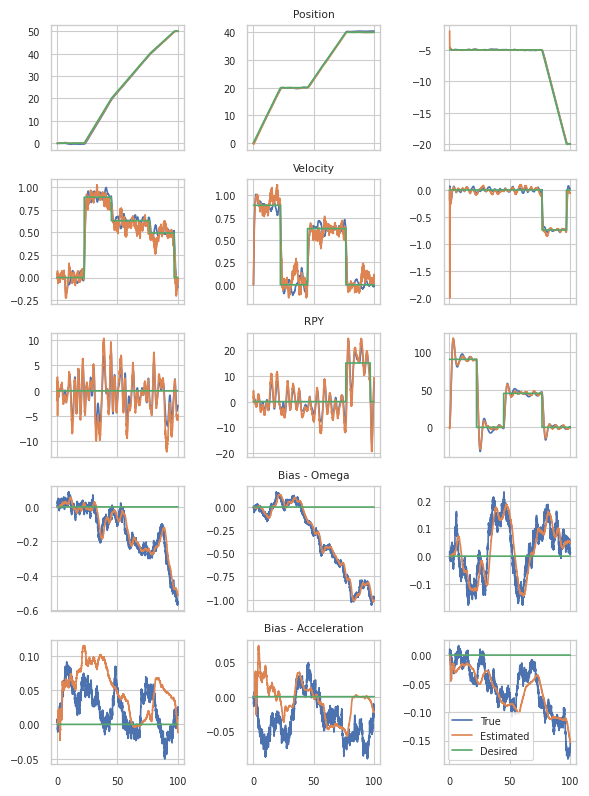

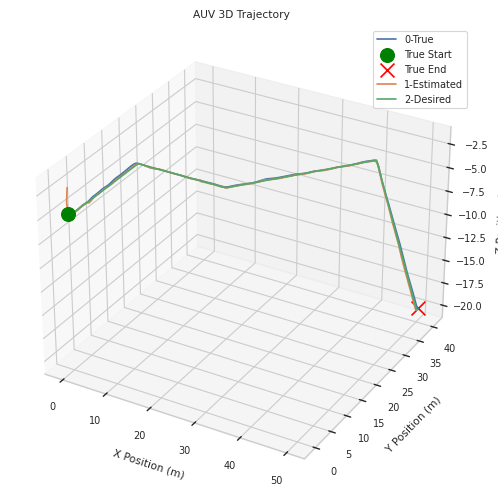

Plot updated in Jupyter Notebook.


In [4]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="aco")

this Dijkstra way


100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 247.68it/s]


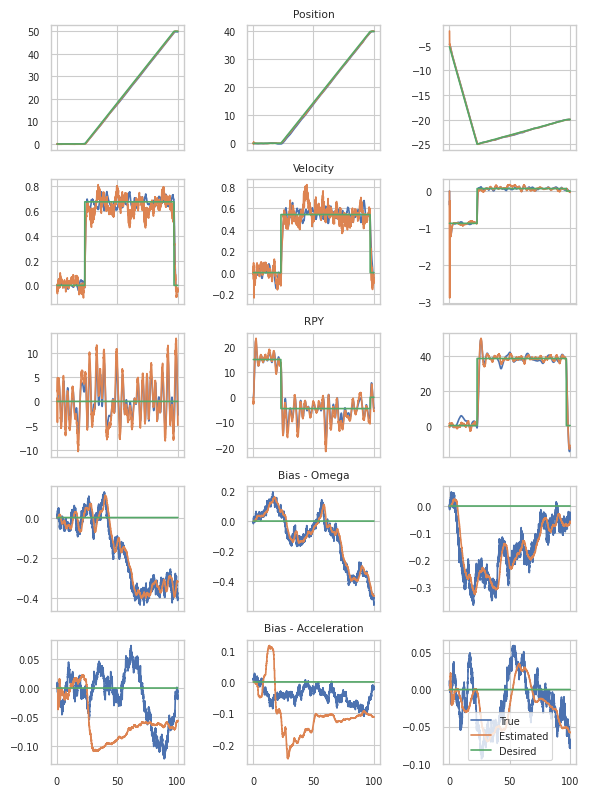

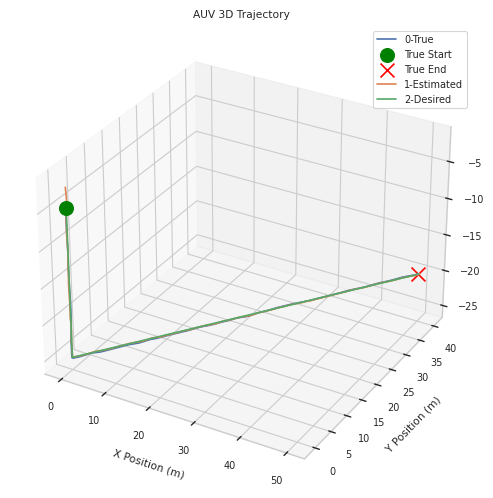

Plot updated in Jupyter Notebook.


In [4]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="djs")

In [4]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="astar")

KeyboardInterrupt: 

this RRT way


100%|████████████████████████████████████| 10000/10000 [00:39<00:00, 250.83it/s]


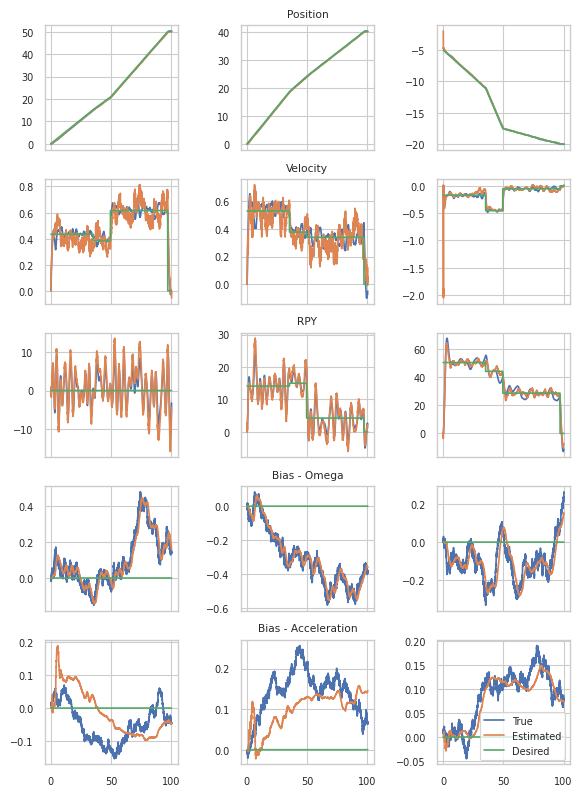

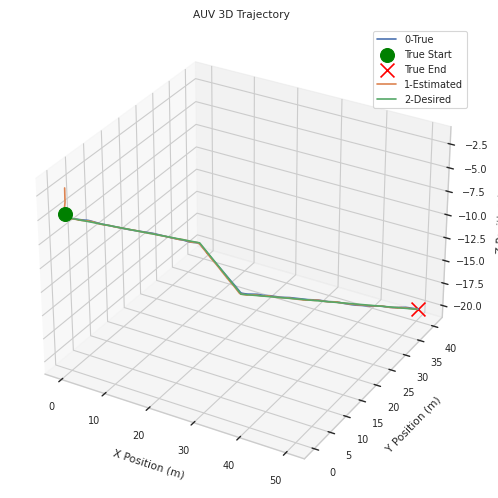

Plot updated in Jupyter Notebook.


In [5]:
main(num_seconds=100, show=False, plot=True, verbose=False,route="rrt")